In [30]:
import os

os.makedirs("../models/general_dam", exist_ok=True)
os.makedirs("../models/Omerli", exist_ok=True)
os.makedirs("../models/Darlik", exist_ok=True)
os.makedirs("../models/Elmali", exist_ok=True)
os.makedirs("../models/Terkos", exist_ok=True)
os.makedirs("../models/Alibey", exist_ok=True)
os.makedirs("../models/Buyukcekmece", exist_ok=True)
os.makedirs("../models/Sazlidere", exist_ok=True)
os.makedirs("../models/Kazandere", exist_ok=True)
os.makedirs("../models/Pabucdere", exist_ok=True)
os.makedirs("../models/Istrancalar", exist_ok=True)


## Prophet Forecasting on Cleaned General Dam Dataset

Processing Prophet model for general dam occupancy...
  > Reading extended dam occupancy data.
  > Data prepared for Prophet model, aggregated from all dams.
  > Training Prophet model for general dam occupancy.


15:45:40 - cmdstanpy - INFO - Chain [1] start processing
15:45:43 - cmdstanpy - INFO - Chain [1] done processing


  > Prophet model training completed.
  > Generating forecast up to: 2025-12-28 00:00:00
  > Plotting Prophet forecast for general dam occupancy with future projection...
  > Plot saved: ../results/plots/prophet_general_dam_only_occupancy_forecast_with_future.png


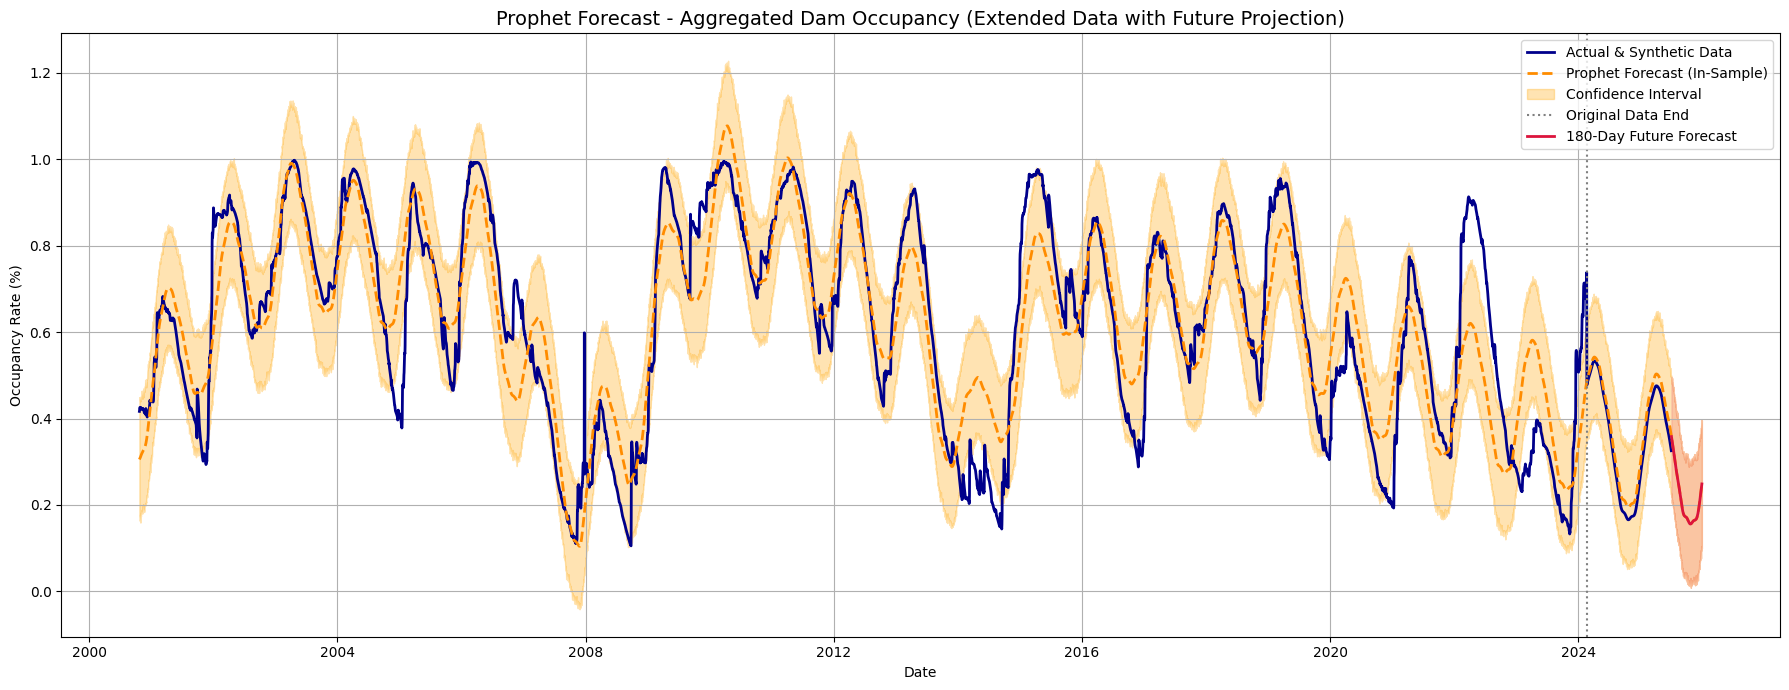

  > Evaluating model performance on test set...
  > Prophet MAE (Test Set): 0.0292
  > Prophet RMSE (Test Set): 0.0292
  > Prophet model saved: ../models/general_dam\prophet_general_dam_only_occupancy_model.pkl
  > Metrics saved: ../models/general_dam\prophet_general_dam_only_occupancy_metrics.txt

Prophet model training and saving process completed for general dam occupancy.


In [4]:
# Importing necessary libraries
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.dates as mdates
import joblib

# --- 1. Dizinleri Oluşturma ---
os.makedirs("../models/general_dam", exist_ok=True)
os.makedirs("../results/plots", exist_ok=True)

print("Processing Prophet model for general dam occupancy...")

# --- 2. Veri Yükleme ve Hazırlık ---
file_path_occupancy_synthetic = "../data/processed/istanbul-dams-daily-occupancy-rates-cleaned_with_synthetic.csv"
df_occupancy_synthetic = pd.read_csv(file_path_occupancy_synthetic)
df_occupancy_synthetic['Tarih'] = pd.to_datetime(df_occupancy_synthetic['Tarih'])
print("  > Reading extended dam occupancy data.")

df_occupancy_synthetic.ffill(inplace=True)
df_occupancy_synthetic.bfill(inplace=True)

dam_cols_for_general_prophet = [col for col in df_occupancy_synthetic.columns if col != 'Tarih']

if not dam_cols_for_general_prophet:
    raise ValueError("No dam occupancy columns found in the synthetic occupancy data. Cannot create aggregated occupancy.")

df_occupancy_synthetic['Aggregated_Dam_Occupancy_Rate'] = df_occupancy_synthetic[dam_cols_for_general_prophet].mean(axis=1)

df_prophet = df_occupancy_synthetic.rename(columns={'Tarih': 'ds', 'Aggregated_Dam_Occupancy_Rate': 'y'})
df_prophet = df_prophet[['ds', 'y']]
print("  > Data prepared for Prophet model, aggregated from all dams.")

# --- 3. Defining and fitting the model ---
model = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=False
)
print("  > Training Prophet model for general dam occupancy.")
model.fit(df_prophet)
print("  > Prophet model training completed.")

# --- 4. Creating future dataframe for IN-SAMPLE + FUTURE forecast ---
FORECAST_FUTURE_DAYS = 180 

future_in_sample_and_forecast = model.make_future_dataframe(periods=FORECAST_FUTURE_DAYS)
forecast_full = model.predict(future_in_sample_and_forecast)

# Test seti için değerlendirme
test_period_days = 180 # Test seti için sabit 180 gün kullanılıyor

# df_prophet'in sonundaki gerçek/sentetik verileri alır
# DÜZELTME: test_df'i doğrudan df_prophet'ten alalım, böylece test_df['ds'] doğru olur
test_df = df_prophet.tail(test_period_days)
actual_test_set_df = test_df.copy() # actual_test_set_df, test_df'in kopyası

# DÜZELTME: forecast_full'dan test setine karşılık gelen tahminleri alırken,
# test_df'in 'ds' sütunundaki tarihlere göre filtreleme yapıyoruz.
predicted_test_set_df = forecast_full[forecast_full['ds'].isin(test_df['ds'])].copy()

actual_test_set = actual_test_set_df['y'].values
predicted_test_set = predicted_test_set_df['yhat'].values

# Boyut kontrolü
if len(actual_test_set) != len(predicted_test_set):
    print(f"  ! Warning: Actual ({len(actual_test_set)}) and Predicted ({len(predicted_test_set)}) test set lengths mismatch during evaluation. Adjusting.")
    # Tarih indeksine göre birleştirip eksik değerleri temizleyebiliriz
    # Bu kısım artık daha az tetiklenmeli, ama yine de sağlamlık için kalsın.
    combined_test_df = pd.DataFrame({'actual': actual_test_set_df['y'].values, 'predicted': predicted_test_set_df['yhat'].values}, index=actual_test_set_df['ds'])
    combined_test_df.dropna(inplace=True)
    actual_test_set = combined_test_df['actual'].values
    predicted_test_set = combined_test_df['predicted'].values


print(f"  > Generating forecast up to: {forecast_full['ds'].max()}")


# --- 5. Plotting the forecast (Updated to include future forecast) ---
print("  > Plotting Prophet forecast for general dam occupancy with future projection...")
plt.figure(figsize=(18, 7))

plt.plot(df_prophet['ds'], df_prophet['y'], color='darkblue', linewidth=2, label='Actual & Synthetic Data')

plt.plot(forecast_full['ds'], forecast_full['yhat'], color='darkorange', linestyle='--', linewidth=2, label='Prophet Forecast (In-Sample)')
plt.fill_between(forecast_full['ds'], forecast_full['yhat_lower'], forecast_full['yhat_upper'],
                 color='orange', alpha=0.3, label='Confidence Interval')

original_data_end_date = pd.to_datetime('2024-02-19')
plt.axvline(original_data_end_date, color='gray', linestyle=':', linewidth=1.5, label='Original Data End')

future_forecast_section = forecast_full[forecast_full['ds'] > df_prophet['ds'].max()]
if not future_forecast_section.empty:
    plt.plot(future_forecast_section['ds'], future_forecast_section['yhat'], color='crimson', linestyle='-', linewidth=2, label=f'{FORECAST_FUTURE_DAYS}-Day Future Forecast')
    plt.fill_between(future_forecast_section['ds'], future_forecast_section['yhat_lower'], future_forecast_section['yhat_upper'],
                     color='lightcoral', alpha=0.3)

plt.title("Prophet Forecast - Aggregated Dam Occupancy (Extended Data with Future Projection)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()

plot_save_path = "../results/plots/prophet_general_dam_only_occupancy_forecast_with_future.png"
plt.savefig(plot_save_path)
print(f"  > Plot saved: {plot_save_path}")
plt.show()


# --- 6. Evaluating performance on test set ---
print("  > Evaluating model performance on test set...")

mae = mean_absolute_error(actual_test_set, predicted_test_set)
rmse = np.sqrt(mean_squared_error(actual_test_set, predicted_test_set))

print(f"  > Prophet MAE (Test Set): {mae:.4f}")
print(f"  > Prophet RMSE (Test Set): {rmse:.4f}")

# --- 7. Saving the trained model and metrics ---
model_save_dir = "../models/general_dam"
model_save_path = os.path.join(model_save_dir, "prophet_general_dam_only_occupancy_model.pkl")

joblib.dump(model, model_save_path)
print(f"  > Prophet model saved: {model_save_path}")

metrics_save_path = os.path.join(model_save_dir, "prophet_general_dam_only_occupancy_metrics.txt")
with open(metrics_save_path, "w") as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
print(f"  > Metrics saved: {metrics_save_path}")

print("\nProphet model training and saving process completed for general dam occupancy.")

## SARIMA Forecasting on Cleaned General Dam Dataset


In [ ]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
import joblib # joblib kütüphanesi eklendi
import matplotlib.dates as mdates # Tarih formatlama için

warnings.filterwarnings("ignore")

# --- 1. Dizinleri Oluşturma ---
os.makedirs("../models/general_dam", exist_ok=True)
os.makedirs("../results/plots", exist_ok=True)

print("Processing SARIMA model for general dam occupancy...")

# --- 2. Veri Yükleme ve Hazırlık ---
# DÜZELTME: Sentetik verilerle genişletilmiş genel baraj verisi dosyasını okuyoruz
df_general = pd.read_csv("../data/processed/merged_general_dam_extended.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])
df_general.set_index('DATE', inplace=True)
print("  > Reading extended general dam data.")

# Eksik değerleri temizle (ffill/bfill)
df_general.ffill(inplace=True)
df_general.bfill(inplace=True)

# DÜZELTME: 'Aggregated_Dam_Occupancy_Rate' sütununu oluşturma
dam_fill_columns = [col for col in df_general.columns if col.endswith('_Fill')]
if not dam_fill_columns:
    if 'GENERAL_DAM_OCCUPANCY_RATE' in df_general.columns:
        df_general['Aggregated_Dam_Occupancy_Rate'] = df_general['GENERAL_DAM_OCCUPANCY_RATE']
    else:
        raise ValueError("No _Fill columns or 'GENERAL_DAM_OCCUPANCY_RATE' found. Cannot aggregate occupancy.")
else:
    df_general['Aggregated_Dam_Occupancy_Rate'] = df_general[dam_fill_columns].mean(axis=1)

# Selecting target variable
series = df_general['Aggregated_Dam_Occupancy_Rate']
print("  > Target series selected: Aggregated_Dam_Occupancy_Rate.")

# --- 3. Splitting into train and test ---
# Veri seti 2025-07-01'e kadar uzadığı için, test seti de bu yeni zaman çizelgesine göre belirlenmeli.
# Son 180 günü test seti olarak alalım (Prophet ile tutarlı).
test_period_days = 180
train_size = len(series) - test_period_days
train, test = series[:train_size], series[train_size:]
print(f"  > Data split into train ({len(train)} samples) and test ({len(test)} samples).")


# --- 4. Automatically selecting SARIMA parameters ---
print("  > Automatically selecting SARIMA parameters using auto_arima (this may take time)...")
# DÜZELTME: seasonal=True olmalıydı m=365 ile.
stepwise_model = auto_arima(train, seasonal=True, m=365, # m=365 için seasonal=True
                            suppress_warnings=True, stepwise=True,
                            error_action="ignore", trace=False)

order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print(f"  > Selected SARIMA Order: {order}, Seasonal Order: {seasonal_order}")

# --- 5. Fitting SARIMA model ---
# Modelin mevsimsel parametreleri otomatik olarak auto_arima tarafından belirlendi.
model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
print("  > Training SARIMA model (this may take time)...")
sarima_result = model.fit(disp=False)
print("  > SARIMA model training completed.")

# --- 6. Forecasting (Test Set + Future Forecast) ---
FORECAST_FUTURE_DAYS = 180 # Gelecek için 6 ay (180 gün) tahmin
total_forecast_steps = len(test) + FORECAST_FUTURE_DAYS

# get_forecast ile hem tahminleri hem de güven aralıklarını al
forecast_result = sarima_result.get_forecast(steps=total_forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int(alpha=0.05) # %95 güven aralığı

# Test seti tahminlerini ayır
test_forecast = forecast_mean[:len(test)]
test_conf_int_lower = forecast_conf_int.iloc[:len(test), 0]
test_conf_int_upper = forecast_conf_int.iloc[:len(test), 1]

# Gelecek tahminlerini ayır
future_forecast = forecast_mean[len(test):]
future_conf_int_lower = forecast_conf_int.iloc[len(test):, 0]
future_conf_int_upper = forecast_conf_int.iloc[len(test):, 1]

print(f"  > Generating forecast for {len(test)} test days and {FORECAST_FUTURE_DAYS} future days.")


# --- 7. Plotting the forecast (Prophet stiliyle) ---
print("  > Plotting SARIMA forecast for general dam occupancy...")
plt.figure(figsize=(18, 7))

# Tarihsel (gerçek ve sentetik birleşik) veriyi çiz
plt.plot(series.index, series, color='darkblue', linewidth=2, label='Actual & Synthetic Data')

# SARIMA tahminini çiz (test seti üzerinde)
plt.plot(test_forecast.index, test_forecast, color='darkorange', linestyle='--', linewidth=2, label='SARIMA Forecast (Test)')
# Test seti güven aralığını çiz
plt.fill_between(test_conf_int_lower.index, test_conf_int_lower, test_conf_int_upper,
                 color='orange', alpha=0.3, label='Test Confidence Interval')


# Gelecek Tahminini çiz
plt.plot(future_forecast.index, future_forecast, color='crimson', linestyle='-', linewidth=2, label=f'{FORECAST_FUTURE_DAYS}-Day Future Forecast')
# Gelecek tahmin güven aralığını çiz
plt.fill_between(future_conf_int_lower.index, future_conf_int_lower, future_conf_int_upper,
                 color='lightcoral', alpha=0.3, label='Future Confidence Interval')


# Orijinal verinin bittiği noktayı işaretleyelim (sentetik verinin başladığı yer)
original_data_end_date = pd.to_datetime('2024-02-19')
plt.axvline(original_data_end_date, color='gray', linestyle=':', linewidth=1.5, label='Original Data End')

plt.title("SARIMA Forecast - Aggregated Dam Occupancy (Extended Data with Future Projection)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Plotu kaydetme
plot_save_path = "../results/plots/sarima_general_dam_only_occupancy_forecast_with_future.png"
plt.savefig(plot_save_path)
print(f"  > Plot saved: {plot_save_path}")
plt.show()

# --- 8. Evaluating performance (only on test set) ---
print("  > Evaluating model performance on test set...")
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))

print(f"  > SARIMA MAE (Test Set): {mae:.4f}")
print(f"  > SARIMA RMSE (Test Set): {rmse:.4f}")

# --- 9. Saving the trained model and metrics ---
model_save_dir = "../models/general_dam"
model_save_path = os.path.join(model_save_dir, "sarima_general_dam_only_occupancy_model.pkl")

joblib.dump(sarima_result, model_save_path) # sarima_result objesini kaydet
print(f"  > SARIMA model saved: {model_save_path}")

metrics_save_path = os.path.join(model_save_dir, "sarima_general_dam_only_occupancy_metrics.txt")
with open(metrics_save_path, "w") as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
print(f"  > Metrics saved: {metrics_save_path}")

print("\nSARIMA model training and saving process completed for general dam occupancy.")
print("\n--- Next Task Reminder ---")
print("Please share the code for the next model you want to update (e.g., individual dam SARIMA or LSTM).")

Processing SARIMA model for general dam occupancy...
  > Reading extended general dam data.
  > Target series selected: Aggregated_Dam_Occupancy_Rate.
  > Data split into train (3570 samples) and test (180 samples).
  > Automatically selecting SARIMA parameters using auto_arima (this may take time)...


KeyboardInterrupt: 

## Univariate LSTM Forecasting on Cleaned General Dam Dataset

Processing LSTM model for general dam occupancy...
  > Reading extended dam occupancy data.
  > Creating lag and rolling features...
  > Lag and rolling features created, missing values handled.
  > Features and target scaled.
  > Sequences created with TIME_STEPS = 60.
  > Data split into Train (7143), Validation (892), Test (894) sets.
  > LSTM model built.


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 60, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

  > Training the LSTM model...
Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0396 - val_loss: 0.0017
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0051 - val_loss: 9.3352e-04
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0042 - val_loss: 8.3173e-04
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0034 - val_loss: 8.6552e-04
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0033 - val_loss: 8.5145e-04
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0032 - val_loss: 8.5954e-04
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0029 - val_loss: 7.2266e-04
Epoch 10/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0025 - val_loss: 7.2093e-04
Epoch 11/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - los

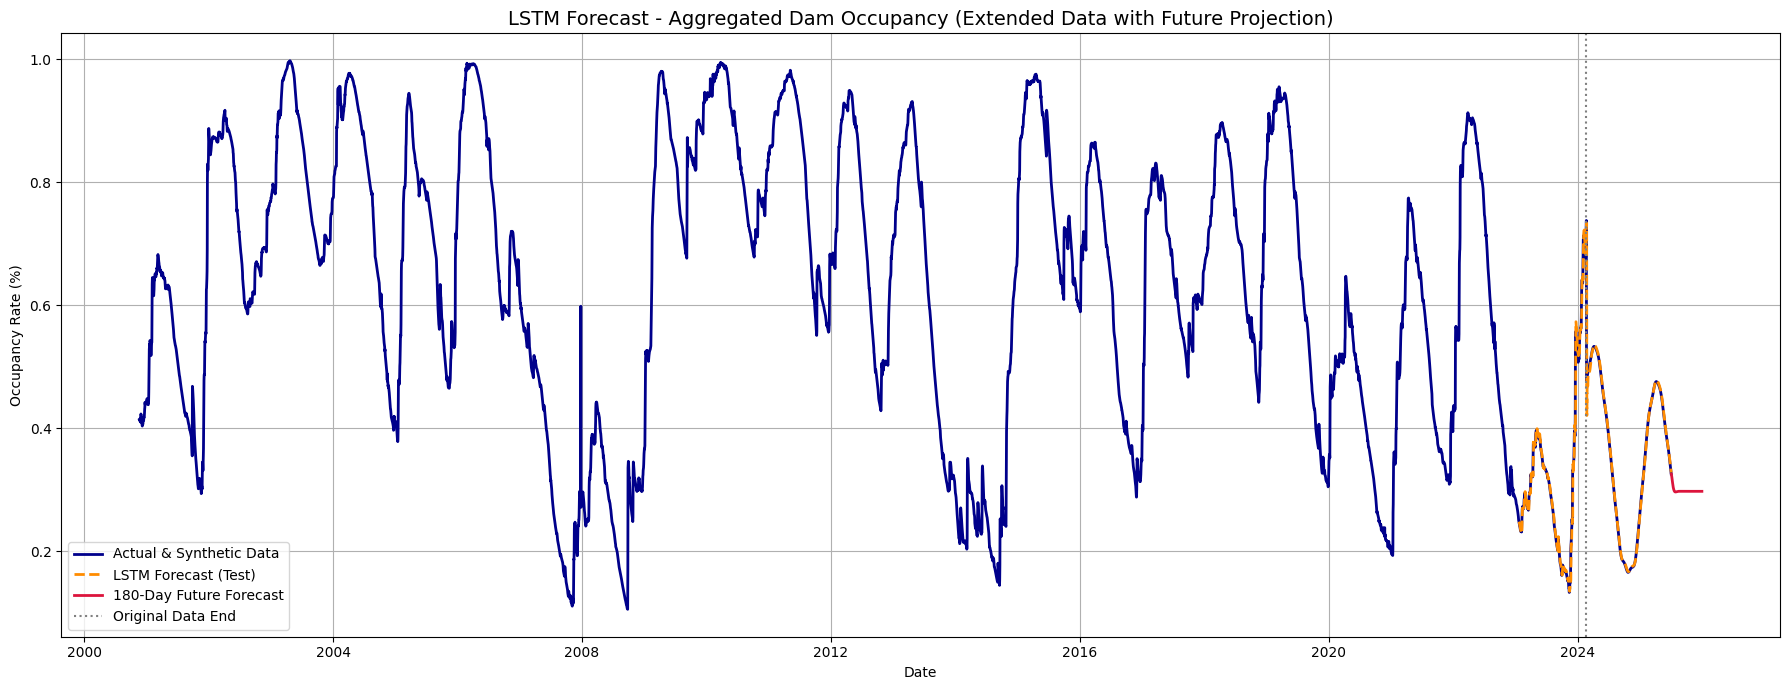

  > Saving trained model and scalers...
  > LSTM model saved: ../models/general_dam\lstm_general_dam_only_occupancy_model.h5
  > Scaler_X saved: ../models/general_dam\scaler_X_general_dam_only_occupancy.pkl
  > Scaler_y saved: ../models/general_dam\scaler_y_general_dam_only_occupancy.pkl
  > Metrics saved: ../models/general_dam\lstm_general_dam_only_occupancy_metrics.txt

LSTM model training and saving process completed for general dam occupancy.

--- Next Task Reminder ---
Please share the code for the next model you want to update (e.g., individual dam SARIMA).


In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input # Input katmanı eklendi
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping eklendi
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import joblib # joblib kütüphanesi eklendi
import os # os kütüphanesi eklendi

# --- 1. Dizinleri Oluşturma ---
os.makedirs("../models/general_dam", exist_ok=True)
os.makedirs("../results/plots", exist_ok=True)

print("Processing LSTM model for general dam occupancy...")

# --- 2. Veri Yükleme ve Hazırlık ---
# DÜZELTME: Sentetik verilerle genişletilmiş dam occupancy dosyasını okuyoruz
file_path_occupancy_synthetic = "../data/processed/istanbul-dams-daily-occupancy-rates-cleaned_with_synthetic.csv"
df_occupancy_synthetic = pd.read_csv(file_path_occupancy_synthetic)
df_occupancy_synthetic['Tarih'] = pd.to_datetime(df_occupancy_synthetic['Tarih'])
print("  > Reading extended dam occupancy data.")

df_occupancy_synthetic.ffill(inplace=True)
df_occupancy_synthetic.bfill(inplace=True)

# DÜZELTME: Genel doluluk oranı sütununu oluşturma
dam_cols_for_general_lstm = [col for col in df_occupancy_synthetic.columns if col != 'Tarih']
if not dam_cols_for_general_lstm:
    raise ValueError("No dam occupancy columns found in the synthetic occupancy data. Cannot create aggregated occupancy.")

df_occupancy_synthetic['Aggregated_Dam_Occupancy_Rate'] = df_occupancy_synthetic[dam_cols_for_general_lstm].mean(axis=1)

# df_lstm, df_occupancy_synthetic'ten türetiliyor
df_lstm = df_occupancy_synthetic.copy()
# df_lstm'de 'Tarih' zaten bir sütun, index değil.

print("  > Creating lag and rolling features...")
# Creating lag and rolling features on the 'Aggregated_Dam_Occupancy_Rate'
df_lstm['Aggregated_Dam_Occupancy_Rate_lag1'] = df_lstm['Aggregated_Dam_Occupancy_Rate'].shift(1)
df_lstm['Aggregated_Dam_Occupancy_Rate_rolling7'] = df_lstm['Aggregated_Dam_Occupancy_Rate'].rolling(window=7).mean()
df_lstm['Aggregated_Dam_Occupancy_Rate_rolling30'] = df_lstm['Aggregated_Dam_Occupancy_Rate'].rolling(window=30).mean()

# Dropping NaNs created by shift and rolling operations
df_lstm = df_lstm.dropna().reset_index(drop=True)
print("  > Lag and rolling features created, missing values handled.")


# Selecting features and target
feature_cols = ['Aggregated_Dam_Occupancy_Rate_lag1', 'Aggregated_Dam_Occupancy_Rate_rolling7', 'Aggregated_Dam_Occupancy_Rate_rolling30']
target_col = 'Aggregated_Dam_Occupancy_Rate'

# Aligning dates with sequences
# time_steps = 60, bu değer create_sequences içinde kullanılacak
# df_lstm'de dropna yapıldığı için, dates_aligned başlangıcı doğru olacaktır.
dates_aligned = df_lstm['Tarih'].reset_index(drop=True) # Bu, X_seq/y_seq ile aynı boyutta olacak

# --- 3. Scaling ---
# Scaler'ları kaydedeceğiz, bu yüzden ayrı ayrı tanımlıyoruz
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_lstm[feature_cols])
y_scaled = scaler_y.fit_transform(df_lstm[[target_col]]) # Target column needs to be 2D
print("  > Features and target scaled.")

# --- 4. Creating sequences ---
TIME_STEPS = 60 # Orijinal kodda da 60 idi

def create_sequences(X, y, time_steps): # time_steps parametre olarak alınır
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)
print(f"  > Sequences created with TIME_STEPS = {TIME_STEPS}.")


# --- 5. Splitting into train/val/test ---
# Oranlar orijinal koddan alındı
train_size = int(len(X_seq) * 0.8)
val_size = int(len(X_seq) * 0.1)
# Kalan %0.1 test olacak
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Test seti için tarihler
dates_test = dates_aligned[train_size + val_size + TIME_STEPS:].reset_index(drop=True) # Time_steps ek kaydırma

print(f"  > Data split into Train ({len(X_train)}), Validation ({len(X_val)}), Test ({len(X_test)}) sets.")


# --- 6. Building the model ---
# Modelin giriş şekli: (TIME_STEPS, number_of_features)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1)) # Tek çıktı (Aggregated_Dam_Occupancy_Rate)
model.compile(optimizer='adam', loss='mse')
print("  > LSTM model built.")
model.summary()

# --- 7. Training the model ---
# DÜZELTME: Overfit kontrolü için EarlyStopping eklendi
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
print("  > Training the LSTM model...")
history = model.fit(
    X_train, y_train, 
    epochs=100, # Epoch sayısı artırıldı, EarlyStopping kontrol edecek
    batch_size=32,
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping], # EarlyStopping callback'i eklendi
    verbose=1
)
print("  > LSTM model training completed.")

# --- 8. Making predictions on test set ---
print("  > Making predictions on test set...")
y_pred_scaled = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# --- 9. Calculating performance ---
print("  > Calculating performance metrics on test set...")
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"  > LSTM MAE (Test Set): {mae:.4f}") # 4 ondalık basamağa yuvarlandı
print(f"  > LSTM RMSE (Test Set): {rmse:.4f}") # 4 ondalık basamağa yuvarlandı


# --- 10. Generating Future Forecast ---
FORECAST_FUTURE_DAYS = 180 # Sonraki 6 ay

print(f"  > Generating {FORECAST_FUTURE_DAYS}-day future forecast...")

# Son bilinen sekansı al
last_sequence = X_scaled[-TIME_STEPS:].reshape(1, TIME_STEPS, X_scaled.shape[1])
future_preds_scaled = []

for _ in range(FORECAST_FUTURE_DAYS):
    next_pred_scaled = model.predict(last_sequence, verbose=0)[0,0] # Tahmin edilen tek değer
    future_preds_scaled.append(next_pred_scaled)
    
    
    
    # Get last actual value in original scale
    last_actual_val_unscaled = scaler_y.inverse_transform(y_scaled[-1].reshape(1,1))[0,0]

    
    
    # Method: Generate a full row of unscaled features based on the new prediction, then scale it.
    new_lag1_unscaled = scaler_y.inverse_transform(np.array(next_pred_scaled).reshape(1,1))[0,0]
    
    
    # Create the new feature vector for the next time step in scaled form
    new_input_feature_vector_scaled = np.array([
        next_pred_scaled, # New lag1 is the current prediction
        last_sequence[0, -1, 1], # Use previous rolling7 value (simplification)
        last_sequence[0, -1, 2]  # Use previous rolling30 value (simplification)
    ]).reshape(1,1,-1) # Shape (1, 1, num_features)
    
    # Update the sequence for the next prediction
    last_sequence = np.append(last_sequence[:, 1:, :], new_input_feature_vector_scaled, axis=1)

future_preds_inv = scaler_y.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

future_dates = pd.date_range(dates_test.iloc[-1] + pd.Timedelta(days=1), periods=FORECAST_FUTURE_DAYS)
print(f"  > Future forecast generated up to: {future_dates.max()}")


# --- 11. Plotting forecast vs actual (Updated to include Future Forecast) ---
print("  > Plotting forecast with future projection...")
plt.figure(figsize=(18, 7)) # Boyut biraz artırıldı

# Tüm df_lstm'deki geçmiş veriyi çiz (gerçek + sentetik)
plt.plot(df_lstm['Tarih'], df_lstm[target_col], color='darkblue', linewidth=2, label='Actual & Synthetic Data')

# Test seti tahminlerini çiz (turuncu kesikli)
plt.plot(dates_test, y_pred_inv, color='darkorange', linestyle='--', linewidth=2, label='LSTM Forecast (Test)')

# Gelecek tahminini çiz (kırmızı düz çizgi)
plt.plot(future_dates, future_preds_inv, color='crimson', linestyle='-', linewidth=2, label=f'{FORECAST_FUTURE_DAYS}-Day Future Forecast')

# Orijinal verinin bittiği noktayı işaretle
original_data_end_date = pd.to_datetime('2024-02-19')
plt.axvline(original_data_end_date, color='gray', linestyle=':', linewidth=1.5, label='Original Data End')

plt.title("LSTM Forecast - Aggregated Dam Occupancy (Extended Data with Future Projection)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Plotu kaydetme
plot_save_path = "../results/plots/lstm_general_dam_only_occupancy_forecast_with_future.png"
plt.savefig(plot_save_path)
print(f"  > Plot saved: {plot_save_path}")
plt.show()


# --- 12. Saving the trained model and scalers ---
print("  > Saving trained model and scalers...")
model_save_dir = "../models/general_dam"

# Modelin kaydedilmesi
model_save_path = os.path.join(model_save_dir, "lstm_general_dam_only_occupancy_model.h5")
model.save(model_save_path)
print(f"  > LSTM model saved: {model_save_path}")

# Scaler'ların kaydedilmesi
scaler_X_save_path = os.path.join(model_save_dir, "scaler_X_general_dam_only_occupancy.pkl")
scaler_y_save_path = os.path.join(model_save_dir, "scaler_y_general_dam_only_occupancy.pkl")
joblib.dump(scaler_X, scaler_X_save_path)
joblib.dump(scaler_y, scaler_y_save_path)
print(f"  > Scaler_X saved: {scaler_X_save_path}")
print(f"  > Scaler_y saved: {scaler_y_save_path}")

# Metriklerin kaydedilmesi
metrics_save_path = os.path.join(model_save_dir, "lstm_general_dam_only_occupancy_metrics.txt")
with open(metrics_save_path, "w") as f:
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
print(f"  > Metrics saved: {metrics_save_path}")

print("\nLSTM model training and saving process completed for general dam occupancy.")
print("\n--- Next Task Reminder ---")
print("Please share the code for the next model you want to update (e.g., individual dam SARIMA).")

## Forecasting Next 60 Days Using Recursive LSTM Predictions (General Dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

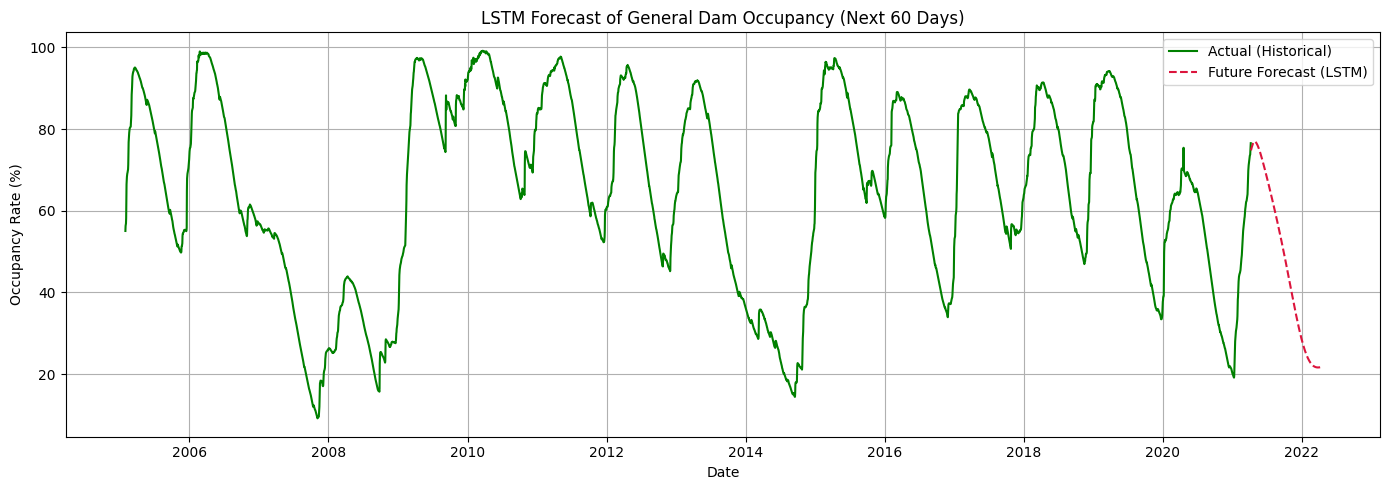

In [10]:
# Forecasting future values using last available sequence
future_steps = 365  # Number of days to forecast
last_sequence = X_seq[-1]  # Taking the last 60-day sequence from original data
forecast_sequence = last_sequence.copy()

future_predictions = []

# Recursive prediction loop
for _ in range(future_steps):
    input_seq = np.expand_dims(forecast_sequence, axis=0)  # (1, 60, 3)
    next_pred = model.predict(input_seq)[0]
    future_predictions.append(next_pred)

    # Creating the next timestep input
    next_input = forecast_sequence[-1].copy()
    next_input[0] = next_pred  # lag1 = predicted value
    # Updating rolling features by simple shifting (can be refined further)
    next_input[1] = (forecast_sequence[-7:, 0].mean() + next_pred[0]) / 2  # new rolling7
    next_input[2] = (forecast_sequence[-30:, 0].mean() + next_pred[0]) / 2  # new rolling30

    forecast_sequence = np.vstack([forecast_sequence[1:], next_input])

# Inverse scaling
future_predictions_inv = scaler_y.inverse_transform(np.array(future_predictions))

# Generating future dates
last_date = df_lstm['DATE'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Plotting actual + future forecast
plt.figure(figsize=(14, 5))
plt.plot(df_lstm['DATE'], df_lstm['GENERAL_DAM_OCCUPANCY_RATE'], label="Actual (Historical)", color='green')
plt.plot(future_dates, future_predictions_inv, label="Future Forecast (LSTM)", color='crimson', linestyle='--')
plt.title("LSTM Forecast of General Dam Occupancy (Next 60 Days)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Multivariate LSTM Forecasting on Cleaned General Dam Dataset


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Multivariate LSTM MAE (Test Set): 0.65
Multivariate LSTM RMSE (Test Set): 0.97


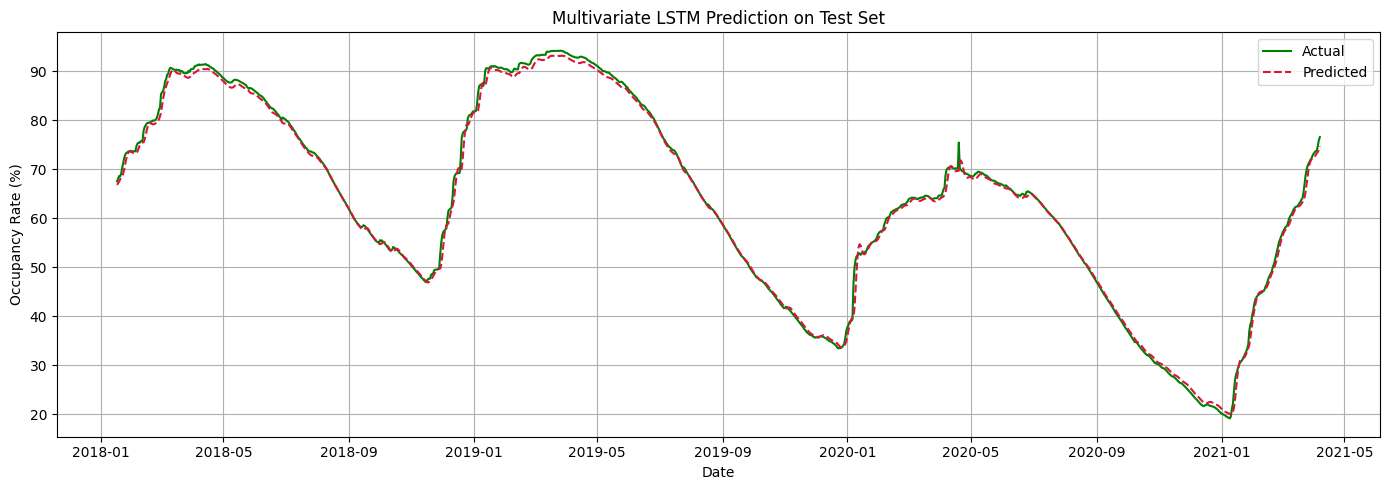

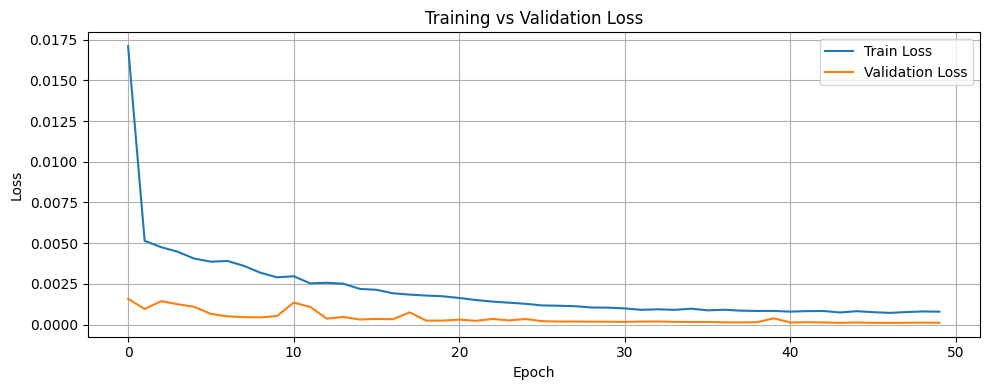

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

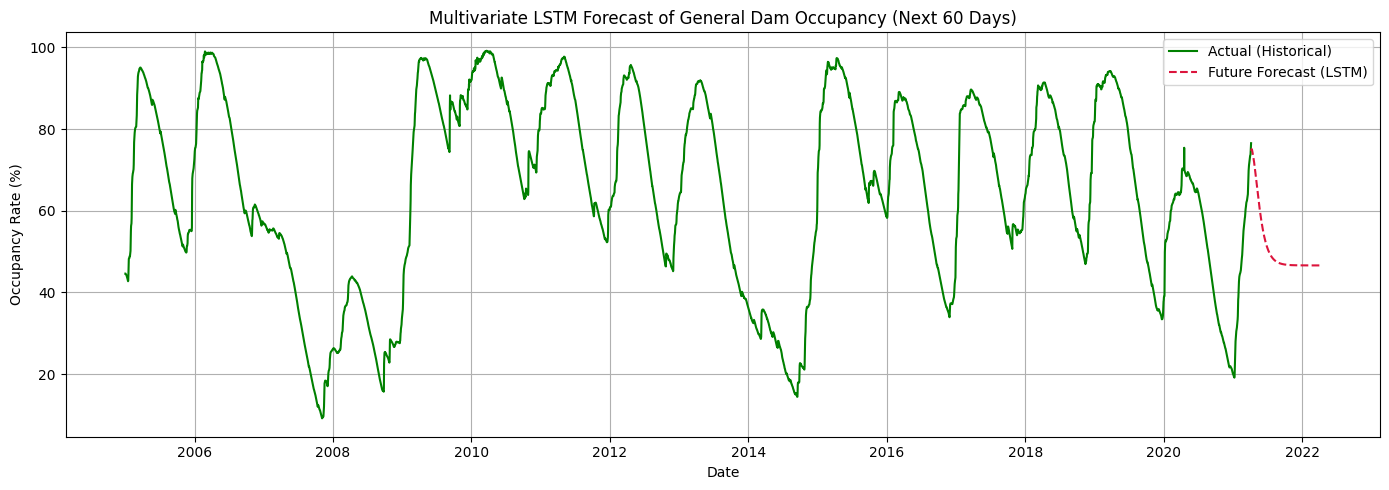

In [32]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Loading cleaned general dam dataset
df_multi = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_multi['DATE'] = pd.to_datetime(df_multi['DATE'])

# Selecting features and target (multivariate inputs)
features = ['GENERAL_DAM_RESERVED_WATER']
target = ['GENERAL_DAM_OCCUPANCY_RATE']
df_model = df_multi[features + target].copy()

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_model[features])
y_scaled = scaler_y.fit_transform(df_model[target])

# Creating input sequences
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)
date_seq = df_multi['DATE'][60:].reset_index(drop=True)

# Train/val/test split
train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.1)
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
date_test = date_seq[train_size + val_size:]

# Building the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Test set prediction
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Evaluation metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Multivariate LSTM MAE (Test Set): {round(mae, 2)}")
print(f"Multivariate LSTM RMSE (Test Set): {round(rmse, 2)}")

# Plotting predictions vs actual
plt.figure(figsize=(14, 5))
plt.plot(date_test, y_test_inv, label="Actual", color='green')
plt.plot(date_test, y_pred_inv, label="Predicted", color='crimson', linestyle='--')
plt.title("Multivariate LSTM Prediction on Test Set")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting loss curve
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# Forecasting next 60 days
# ==============================

future_steps = 365
forecast_input = X_seq[-1]
future_forecast = []

for _ in range(future_steps):
    input_seq = np.expand_dims(forecast_input, axis=0)
    next_pred = model.predict(input_seq)[0]
    future_forecast.append(next_pred)

    next_input = forecast_input[-1].copy()
    next_input[0] = next_pred[0]
    forecast_input = np.vstack([forecast_input[1:], next_input])

# Inverse scaling
future_forecast_inv = scaler_y.inverse_transform(np.array(future_forecast))
last_date = df_multi['DATE'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Plotting actual + future forecast
plt.figure(figsize=(14, 5))
plt.plot(df_multi['DATE'], df_multi['GENERAL_DAM_OCCUPANCY_RATE'], label="Actual (Historical)", color='green')
plt.plot(future_dates, future_forecast_inv, label="Future Forecast (LSTM)", color='crimson', linestyle='--')
plt.title("Multivariate LSTM Forecast of General Dam Occupancy (Next 60 Days)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.save("../models/general_dam/lstm_multivariate_only_occupancy_general.h5")



## Prophet Forecasting for Each Dam (Occupancy Only)


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None


DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\s46tf30q.json



Training Prophet model for: Omerli


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\wp9jnkh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=67066', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\s46tf30q.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\wp9jnkh1.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelquk99enc\\prophet_model-20250629215818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Omerli - Prophet MAE: 0.1 | RMSE: 0.13


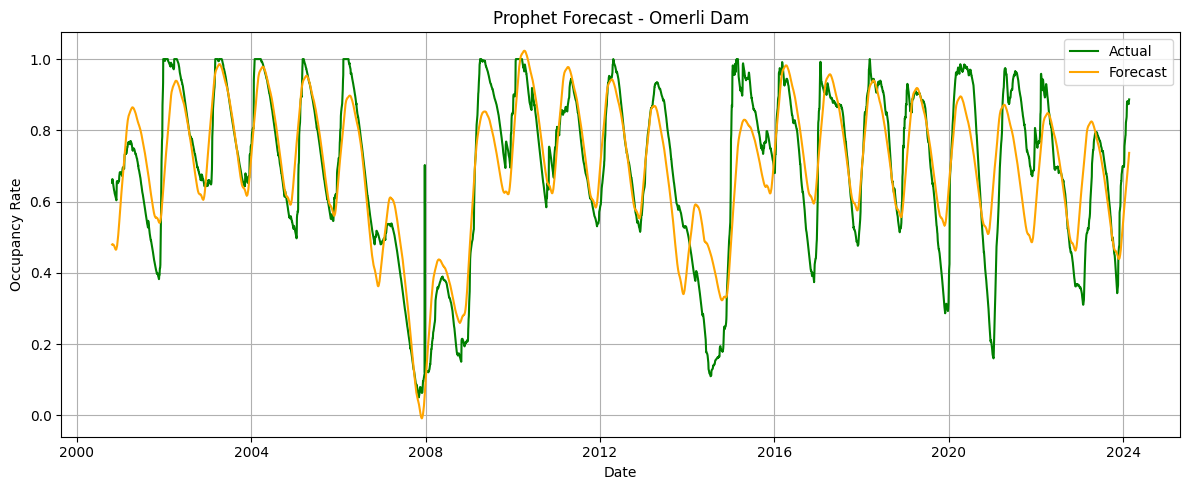

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


Model saved as: ../models/multivariate_models_only_occupancy/prophet_omerli.pkl

Training Prophet model for: Darlik


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\04mavgsp.json
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\9gjdsndo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=63183', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\04mavgsp.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\9gjdsndo.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelrgkeknmh\\prophet_model-20250629215822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:26 - cmdstanpy - INFO - Chain [1] done processing
INFO

Darlik - Prophet MAE: 0.14 | RMSE: 0.17


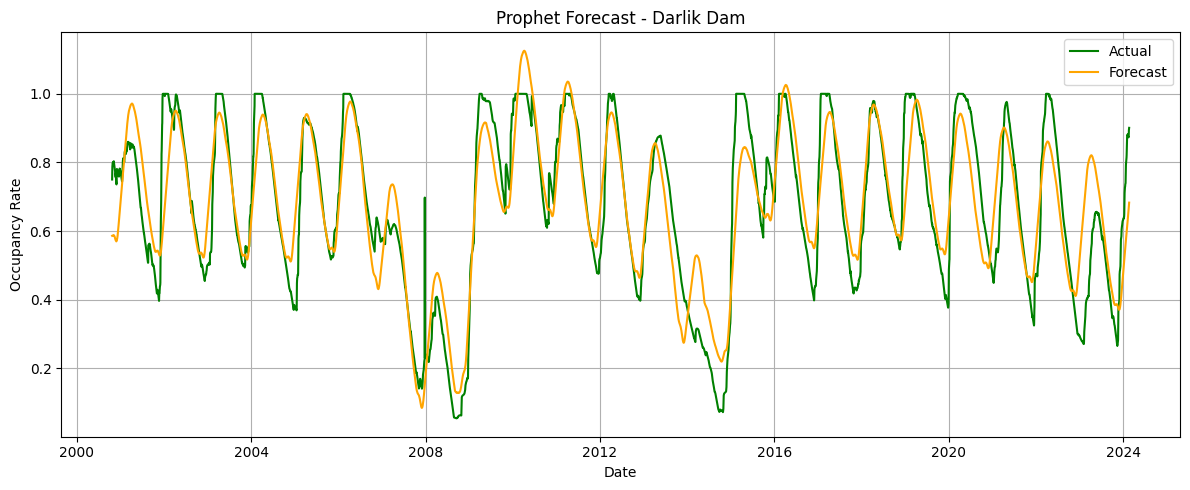

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


Model saved as: ../models/multivariate_models_only_occupancy/prophet_darlik.pkl

Training Prophet model for: Elmali


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\l0j_2d8_.json
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\4cmkvrzf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=66959', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\l0j_2d8_.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\4cmkvrzf.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelod4nwe1x\\prophet_model-20250629215829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO

Elmali - Prophet MAE: 0.3 | RMSE: 0.3


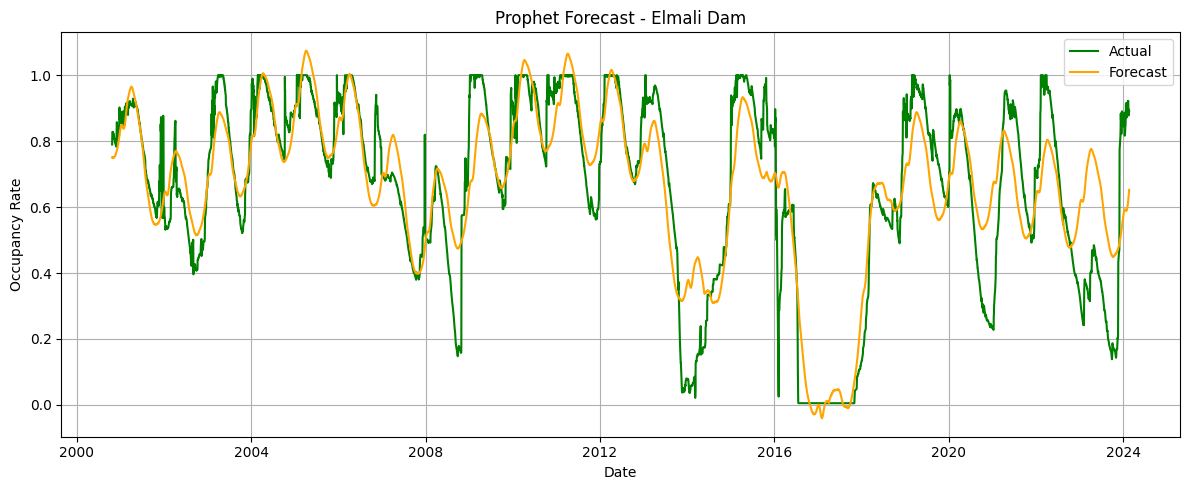

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


Model saved as: ../models/multivariate_models_only_occupancy/prophet_elmali.pkl

Training Prophet model for: Terkos


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\wocks6zr.json
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\c_7va0hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=46631', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\wocks6zr.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\c_7va0hd.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelzb_y3fd7\\prophet_model-20250629215834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:36 - cmdstanpy - INFO - Chain [1] done processing
INFO

Terkos - Prophet MAE: 0.22 | RMSE: 0.23


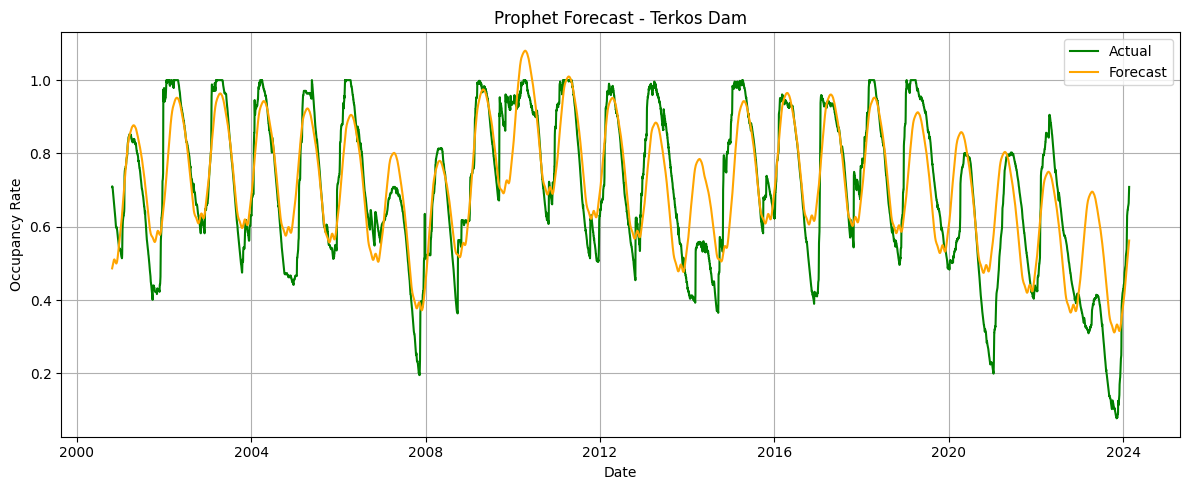

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None


Model saved as: ../models/multivariate_models_only_occupancy/prophet_terkos.pkl

Training Prophet model for: Alibey


DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\ip38ahkm.json
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\fqcsyg0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=60337', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\ip38ahkm.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\fqcsyg0t.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_model17wp0v7j\\prophet_model-20250629215838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:41 - cm

Alibey - Prophet MAE: 0.23 | RMSE: 0.28


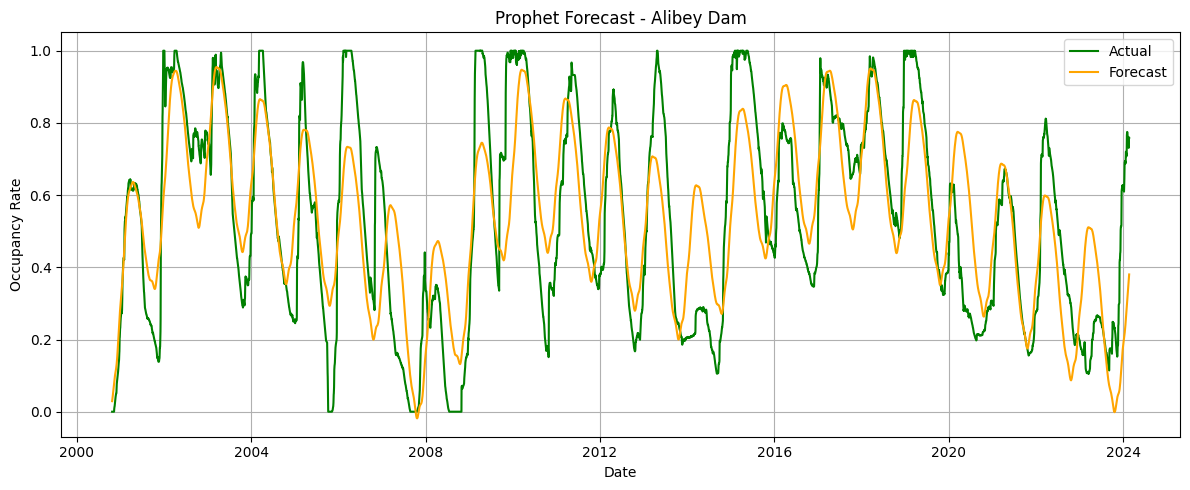

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\7_nwoijr.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_alibey.pkl

Training Prophet model for: Buyukcekmece


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\03jvlgpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=98297', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\7_nwoijr.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\03jvlgpl.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_model8h8m__72\\prophet_model-20250629215843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Buyukcekmece - Prophet MAE: 0.27 | RMSE: 0.29


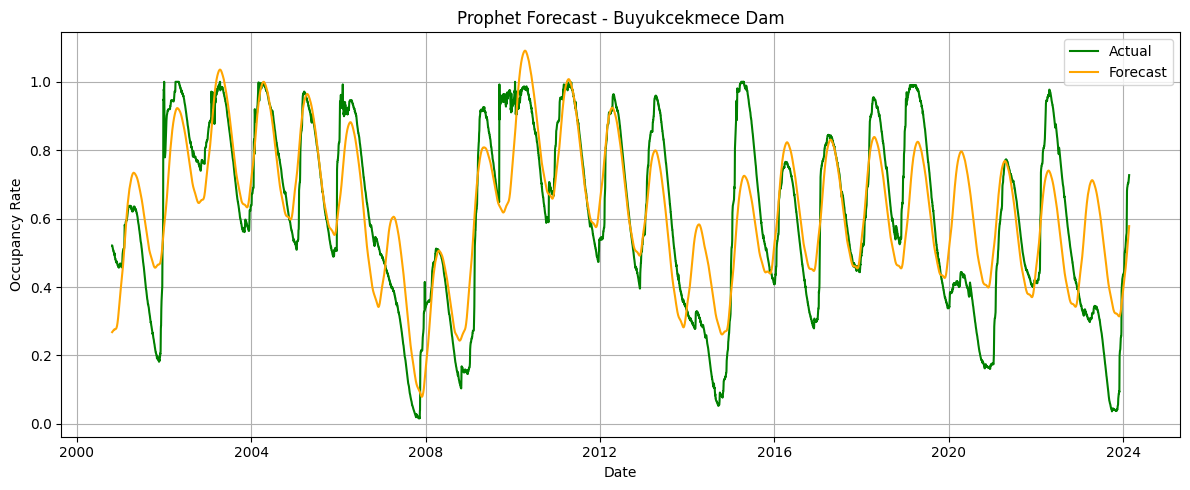

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\ol97arz7.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_buyukcekmece.pkl

Training Prophet model for: Sazlidere


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\os47ylb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=68811', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\ol97arz7.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\os47ylb3.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelbj2wqruq\\prophet_model-20250629215848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Sazlidere - Prophet MAE: 0.17 | RMSE: 0.19


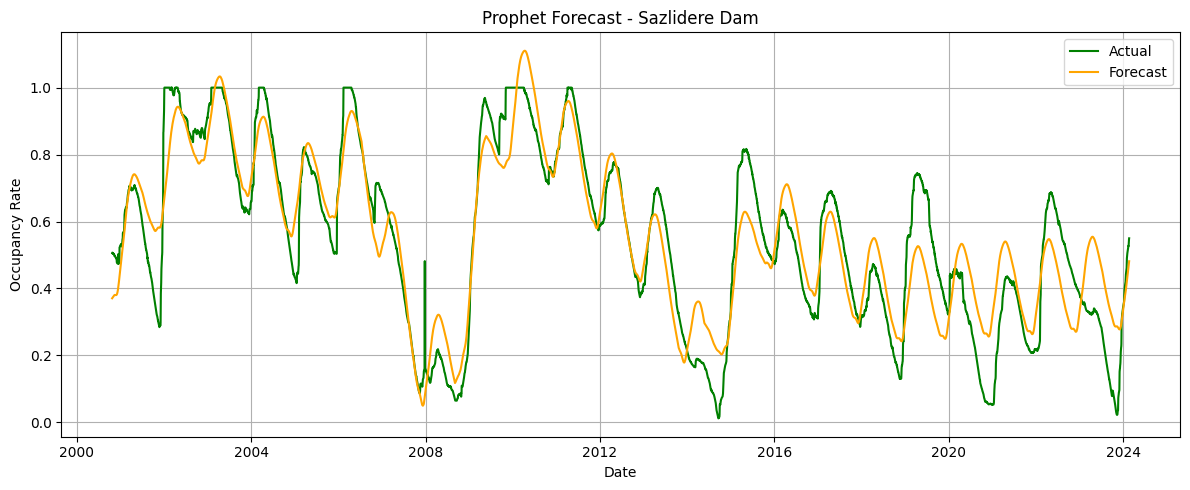

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\_sg8ukm0.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_sazlidere.pkl

Training Prophet model for: Kazandere


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\q8kn8n5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=78817', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\_sg8ukm0.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\q8kn8n5v.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_model0fpyghu7\\prophet_model-20250629215854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:58:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Kazandere - Prophet MAE: 0.21 | RMSE: 0.24


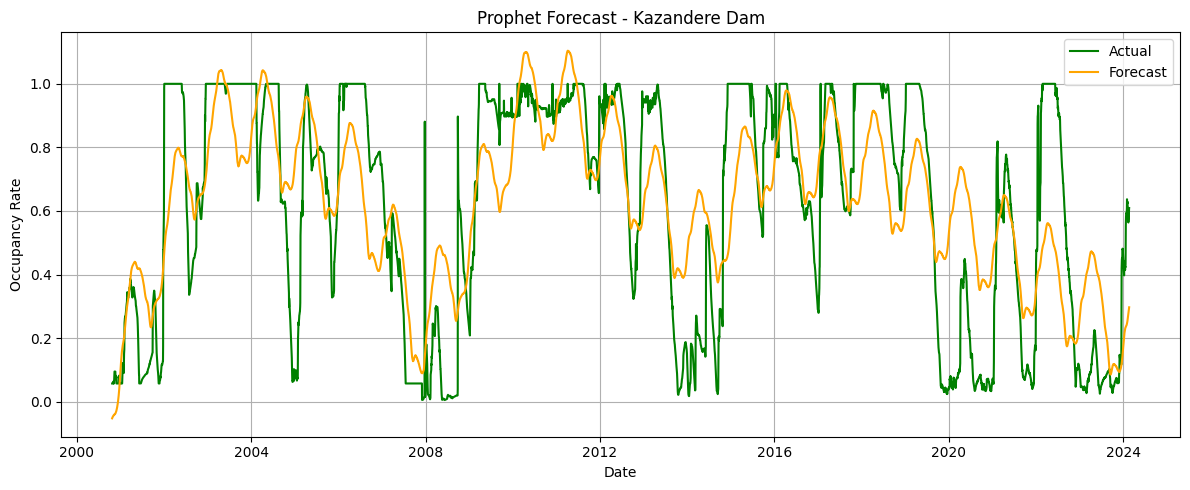

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\8hipdjnl.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_kazandere.pkl

Training Prophet model for: Pabucdere


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\4oq845q6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=43276', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\8hipdjnl.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\4oq845q6.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelsvqeh4nf\\prophet_model-20250629215859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:58:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Pabucdere - Prophet MAE: 0.16 | RMSE: 0.19


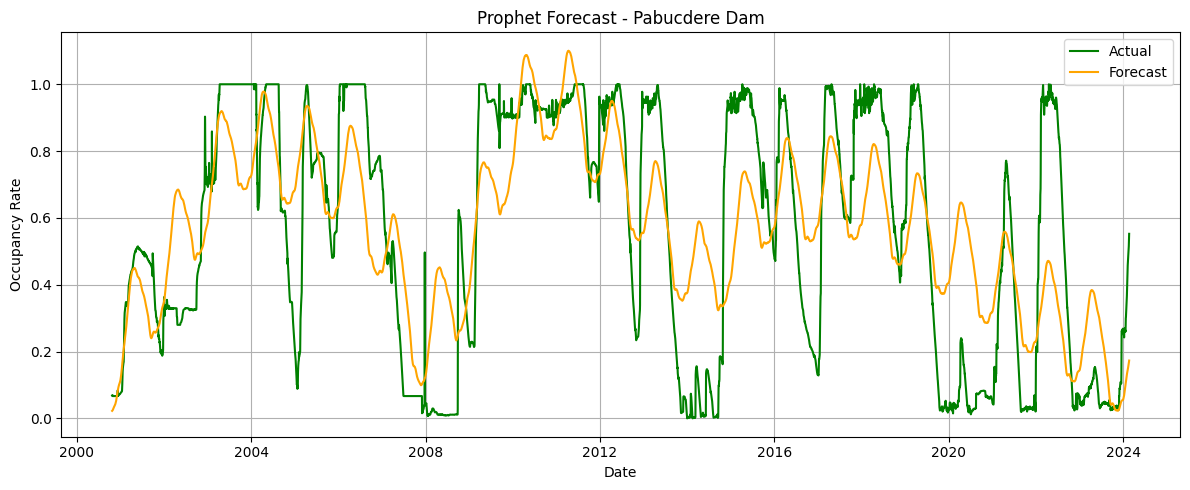

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\6m7lifjv.json


Model saved as: ../models/multivariate_models_only_occupancy/prophet_pabucdere.pkl

Training Prophet model for: Istrancalar


DEBUG:cmdstanpy:input tempfile: C:\Users\merta\AppData\Local\Temp\tmp6eg44a3x\m7mtj0wk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\merta\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=16693', 'data', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\6m7lifjv.json', 'init=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\m7mtj0wk.json', 'output', 'file=C:\\Users\\merta\\AppData\\Local\\Temp\\tmp6eg44a3x\\prophet_modelpu2knzwy\\prophet_model-20250629215904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:59:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Istrancalar - Prophet MAE: 0.13 | RMSE: 0.17


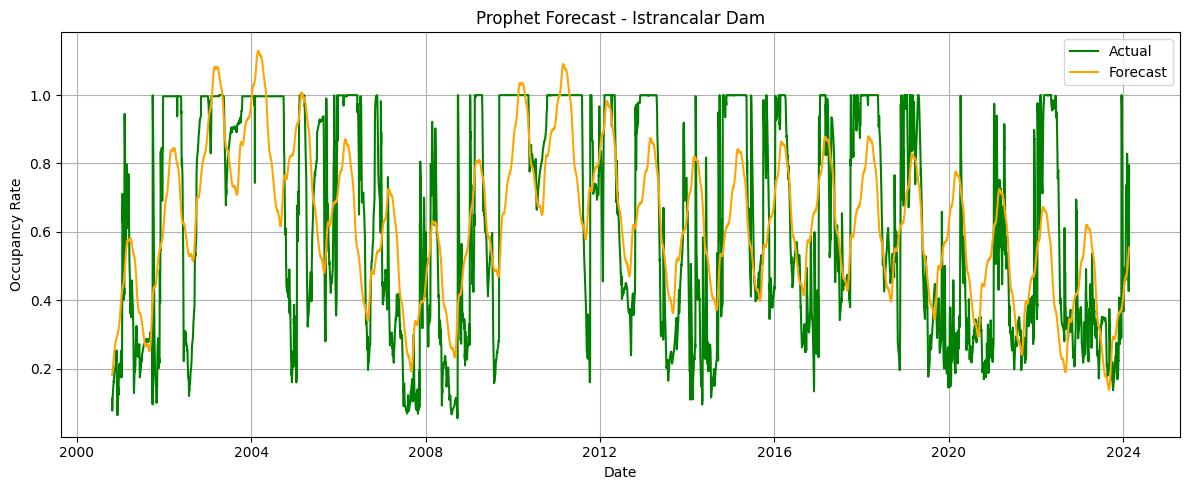

Model saved as: ../models/multivariate_models_only_occupancy/prophet_istrancalar.pkl


In [21]:
# Importing necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Creating output directory for models if not exists
os.makedirs("../models/prophet_dam_specific", exist_ok=True)

# Iterating over each dam column
dam_columns = df_dams.columns.drop('Tarih')

for dam in dam_columns:
    print(f"\nTraining Prophet model for: {dam}")

    # Preparing dataset for Prophet
    df_prophet = df_dams[['Tarih', dam]].rename(columns={'Tarih': 'ds', dam: 'y'})

    # Splitting into train and test (last 60 days as test)
    df_train = df_prophet[:-360]
    df_test = df_prophet[-360:]

    # Initializing and fitting the model
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(df_train)

    # Forecasting future including test period
    future = model.make_future_dataframe(periods=360)
    forecast = model.predict(future)

    # Extracting prediction corresponding to test dates
    forecast_test = forecast.set_index('ds').loc[df_test['ds']]
    predicted = forecast_test['yhat'].values
    actual = df_test['y'].values

    # Calculating metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"{dam} - Prophet MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual", color="green")
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="orange")
    plt.title(f"Prophet Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    import joblib

    # Saving the trained Prophet model
    joblib.dump(model, f"../models/multivariate_models_only_occupancy/prophet_{dam.lower()}.pkl")
    print(f"Model saved as: ../models/multivariate_models_only_occupancy/prophet_{dam.lower()}.pkl")






## SARIMA Forecasting on Dam-Specific Datasets


Training SARIMA model for: Omerli
Selected SARIMA Order for Omerli: (3, 1, 4)
Omerli - SARIMA MAE: 0.11 | RMSE: 0.14


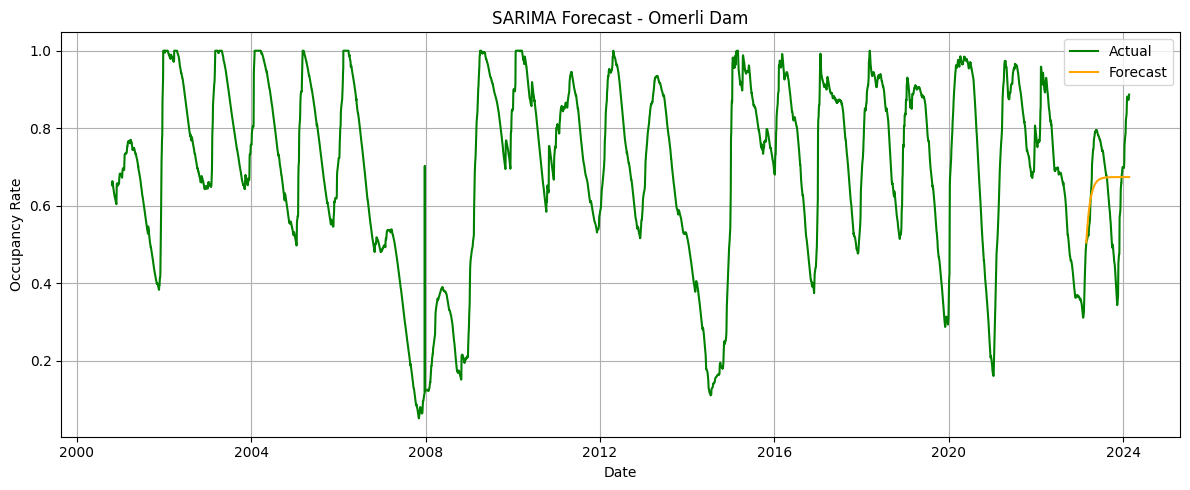

Model saved: ../models/multivariate_models_only_occupancy/sarima_omerli.pkl

Training SARIMA model for: Darlik
Selected SARIMA Order for Darlik: (4, 1, 2)
Darlik - SARIMA MAE: 0.12 | RMSE: 0.16


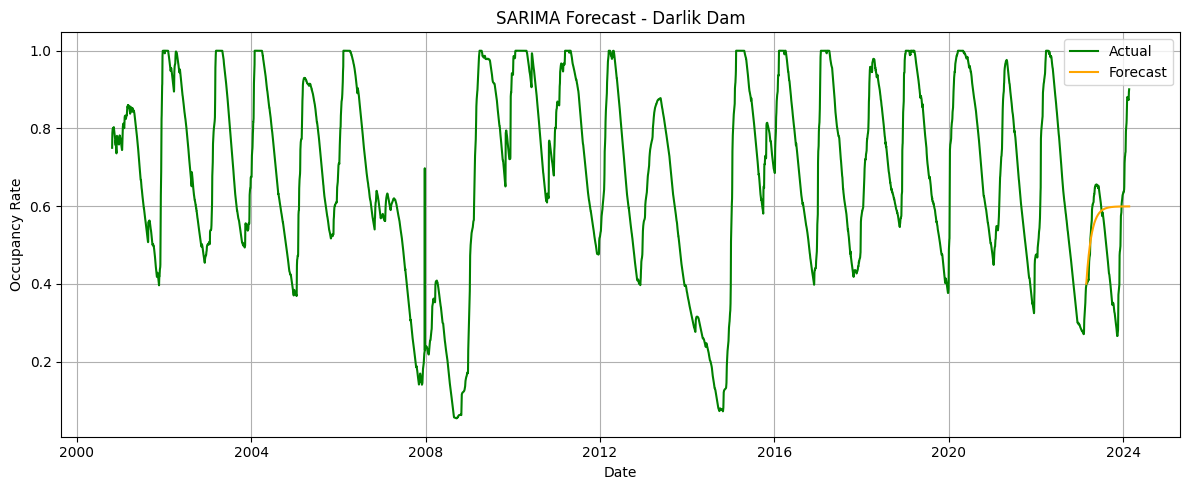

Model saved: ../models/multivariate_models_only_occupancy/sarima_darlik.pkl

Training SARIMA model for: Elmali
Selected SARIMA Order for Elmali: (4, 1, 2)
Elmali - SARIMA MAE: 0.19 | RMSE: 0.25


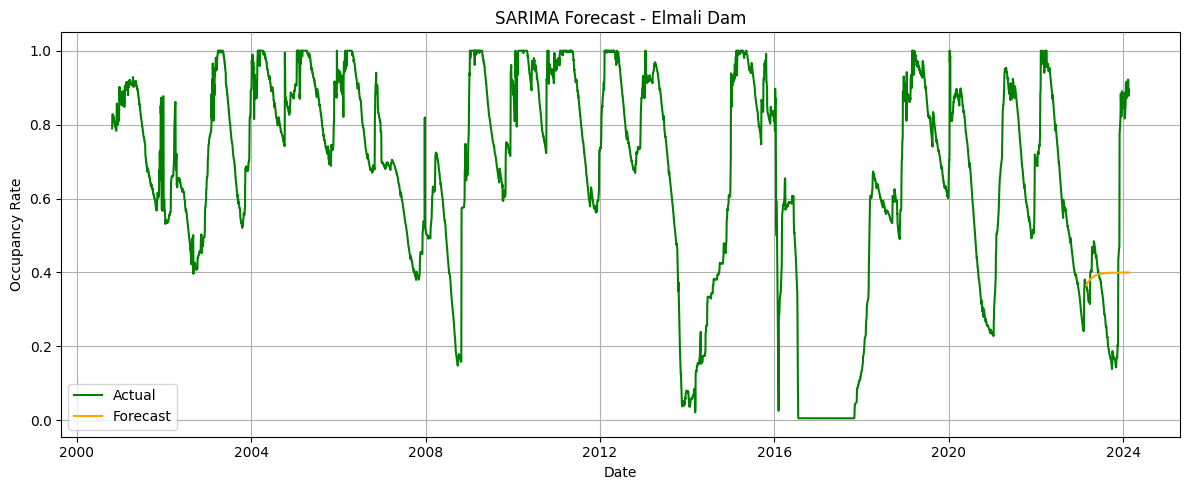

Model saved: ../models/multivariate_models_only_occupancy/sarima_elmali.pkl

Training SARIMA model for: Terkos
Selected SARIMA Order for Terkos: (1, 1, 3)
Terkos - SARIMA MAE: 0.12 | RMSE: 0.15


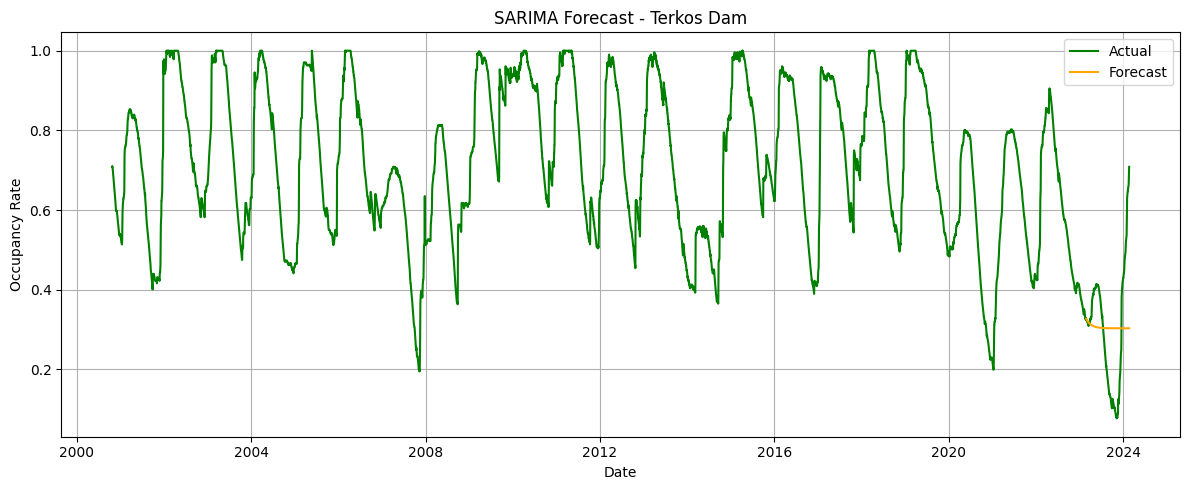

Model saved: ../models/multivariate_models_only_occupancy/sarima_terkos.pkl

Training SARIMA model for: Alibey
Selected SARIMA Order for Alibey: (1, 1, 3)
Alibey - SARIMA MAE: 0.21 | RMSE: 0.29


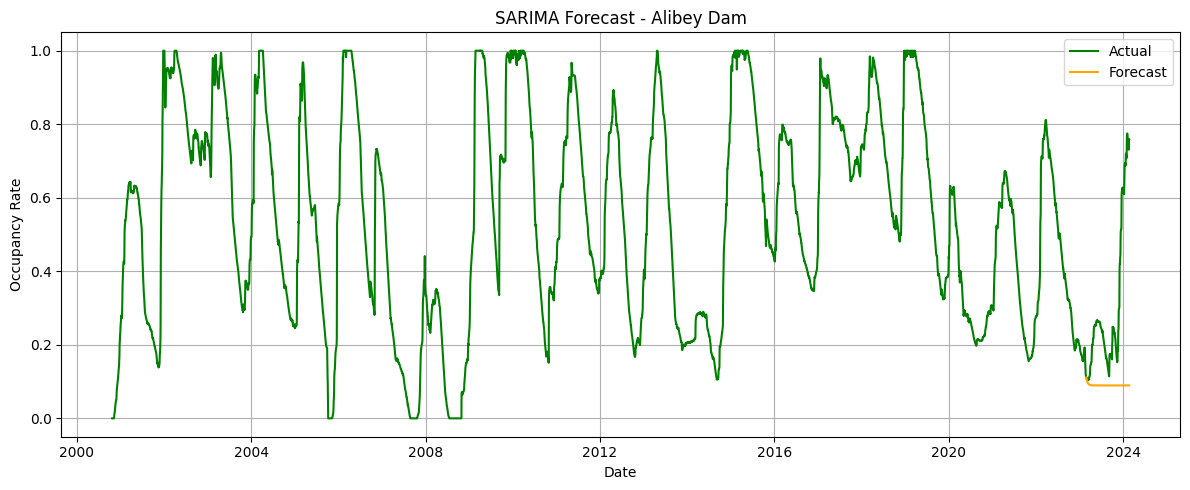

Model saved: ../models/multivariate_models_only_occupancy/sarima_alibey.pkl

Training SARIMA model for: Buyukcekmece
Selected SARIMA Order for Buyukcekmece: (1, 1, 0)
Buyukcekmece - SARIMA MAE: 0.14 | RMSE: 0.19


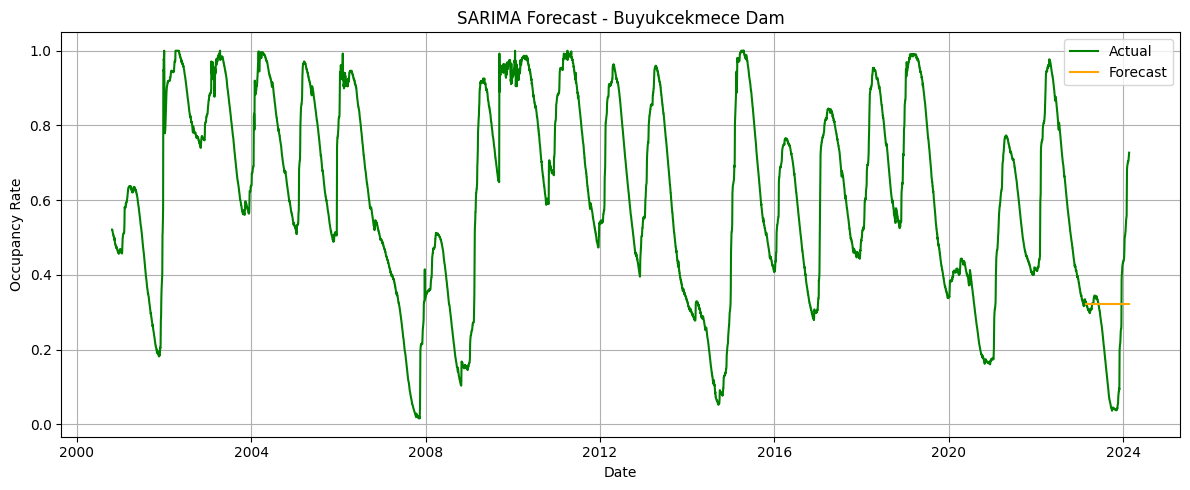

Model saved: ../models/multivariate_models_only_occupancy/sarima_buyukcekmece.pkl

Training SARIMA model for: Sazlidere
Selected SARIMA Order for Sazlidere: (3, 1, 5)
Sazlidere - SARIMA MAE: 0.11 | RMSE: 0.14


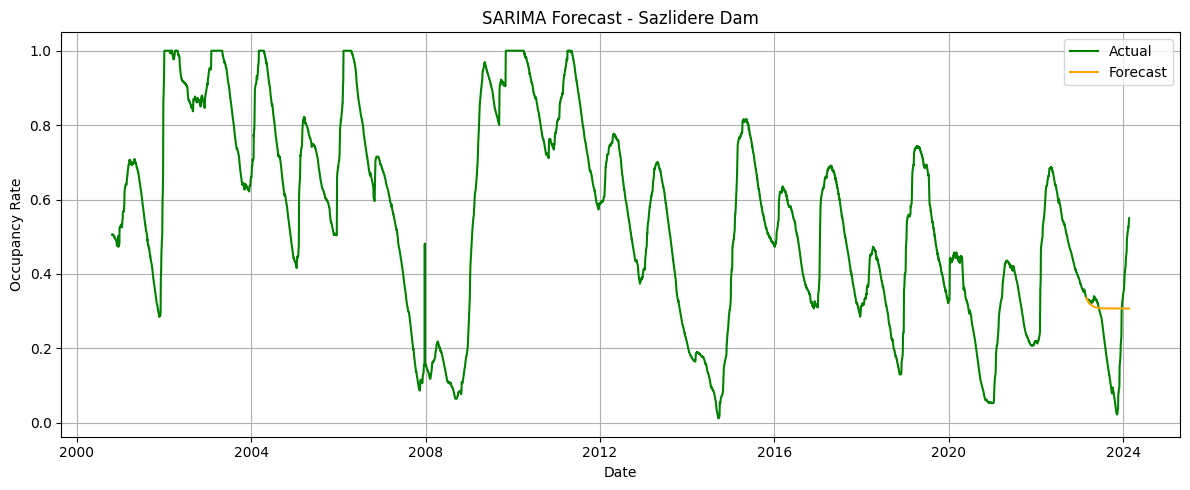

Model saved: ../models/multivariate_models_only_occupancy/sarima_sazlidere.pkl

Training SARIMA model for: Kazandere
Selected SARIMA Order for Kazandere: (1, 1, 3)
Kazandere - SARIMA MAE: 0.13 | RMSE: 0.22


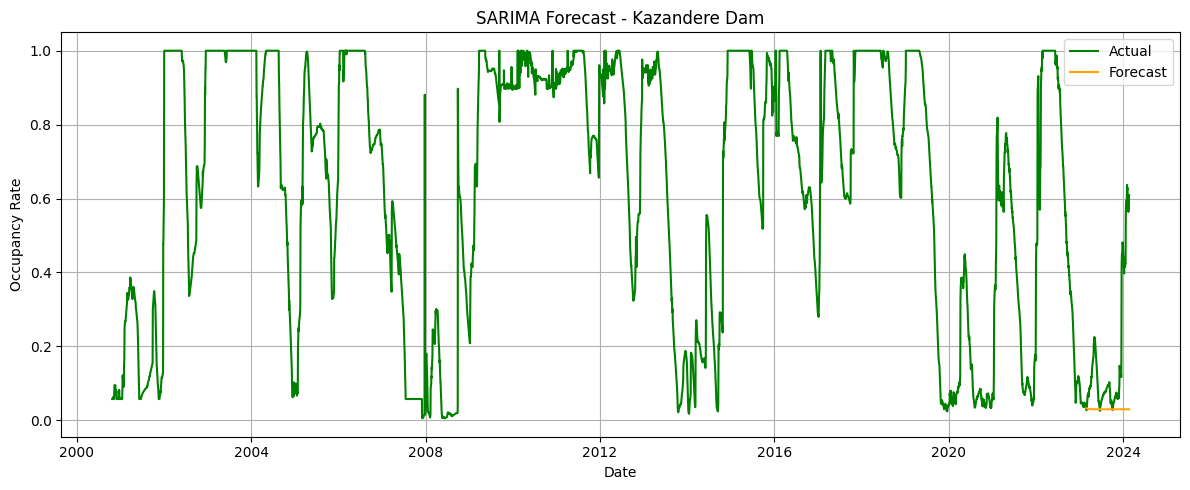

Model saved: ../models/multivariate_models_only_occupancy/sarima_kazandere.pkl

Training SARIMA model for: Pabucdere
Selected SARIMA Order for Pabucdere: (2, 1, 1)
Pabucdere - SARIMA MAE: 0.07 | RMSE: 0.12


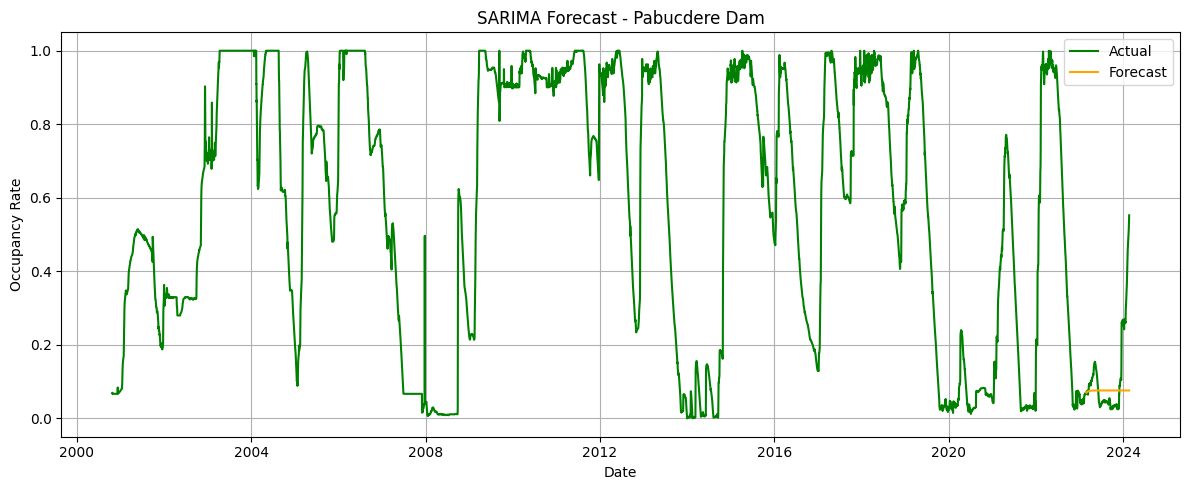

Model saved: ../models/multivariate_models_only_occupancy/sarima_pabucdere.pkl

Training SARIMA model for: Istrancalar
Selected SARIMA Order for Istrancalar: (3, 1, 4)
Istrancalar - SARIMA MAE: 0.13 | RMSE: 0.17


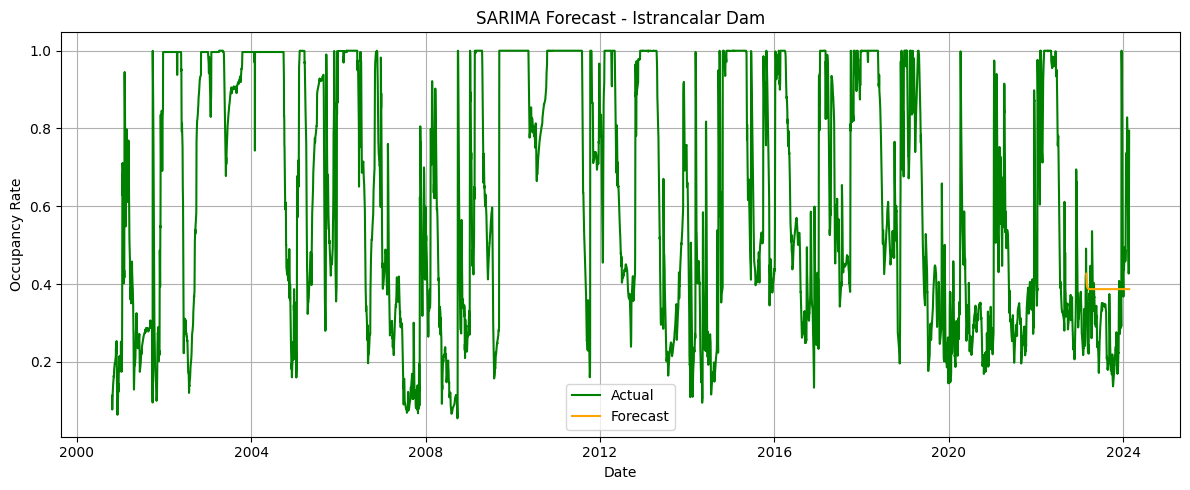

Model saved: ../models/multivariate_models_only_occupancy/sarima_istrancalar.pkl


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import warnings
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Output directory
os.makedirs("../models/multivariate_models_only_occupancy", exist_ok=True)

# List of dam columns (excluding date)
dam_columns = df_dams.columns.drop('Tarih')

for dam in dam_columns:
    print(f"\nTraining SARIMA model for: {dam}")
    
    # Preparing time series
    series = df_dams.set_index('Tarih')[dam]

    # Splitting (last 60 days as test)
    train = series[:-360]
    test = series[-360:]

    # Finding best SARIMA parameters
    model_auto = auto_arima(train, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True)
    order = model_auto.order
    print(f"Selected SARIMA Order for {dam}: {order}")

    # Fitting the model
    model = sm.tsa.ARIMA(train, order=order)
    results = model.fit()

    # Forecasting
    forecast = results.forecast(steps=360)

    # Evaluation
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f"{dam} - SARIMA MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(series.index, series.values, label="Actual", color="green")
    plt.plot(test.index, forecast, label="Forecast", color="orange")
    plt.title(f"SARIMA Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Saving the model
    model_path = f"../models/multivariate_models_only_occupancy/sarima_{dam.lower()}.pkl"
    joblib.dump(results, model_path)
    print(f"Model saved: {model_path}")


## Univariate LSTM for Dam-Specific Forecasting

Processing Univariate LSTM models for each dam...
  > Reading extended dam occupancy data.

  > Training Univariate LSTM for: Omerli
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0504 - val_loss: 0.0033
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0068 - val_loss: 9.5640e-04
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0056 - val_loss: 7.5267e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0048 - val_loss: 7.6411e-04
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0041 - val_loss: 6.9148e-04
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0041 - val_loss: 5.7620e-04
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0039 - val_loss: 6.8452e-04
Epoch 8/100
196/196 ━━

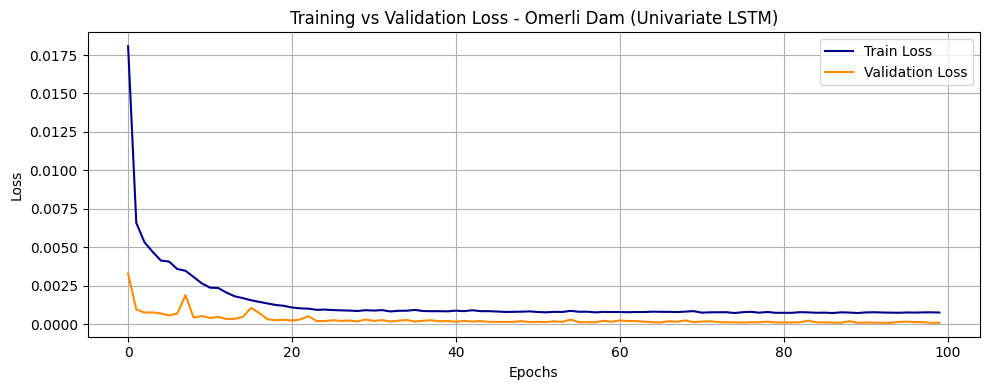

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0034
    > LSTM RMSE (Test Set): 0.0070
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_omerli_forecast_with_future.png


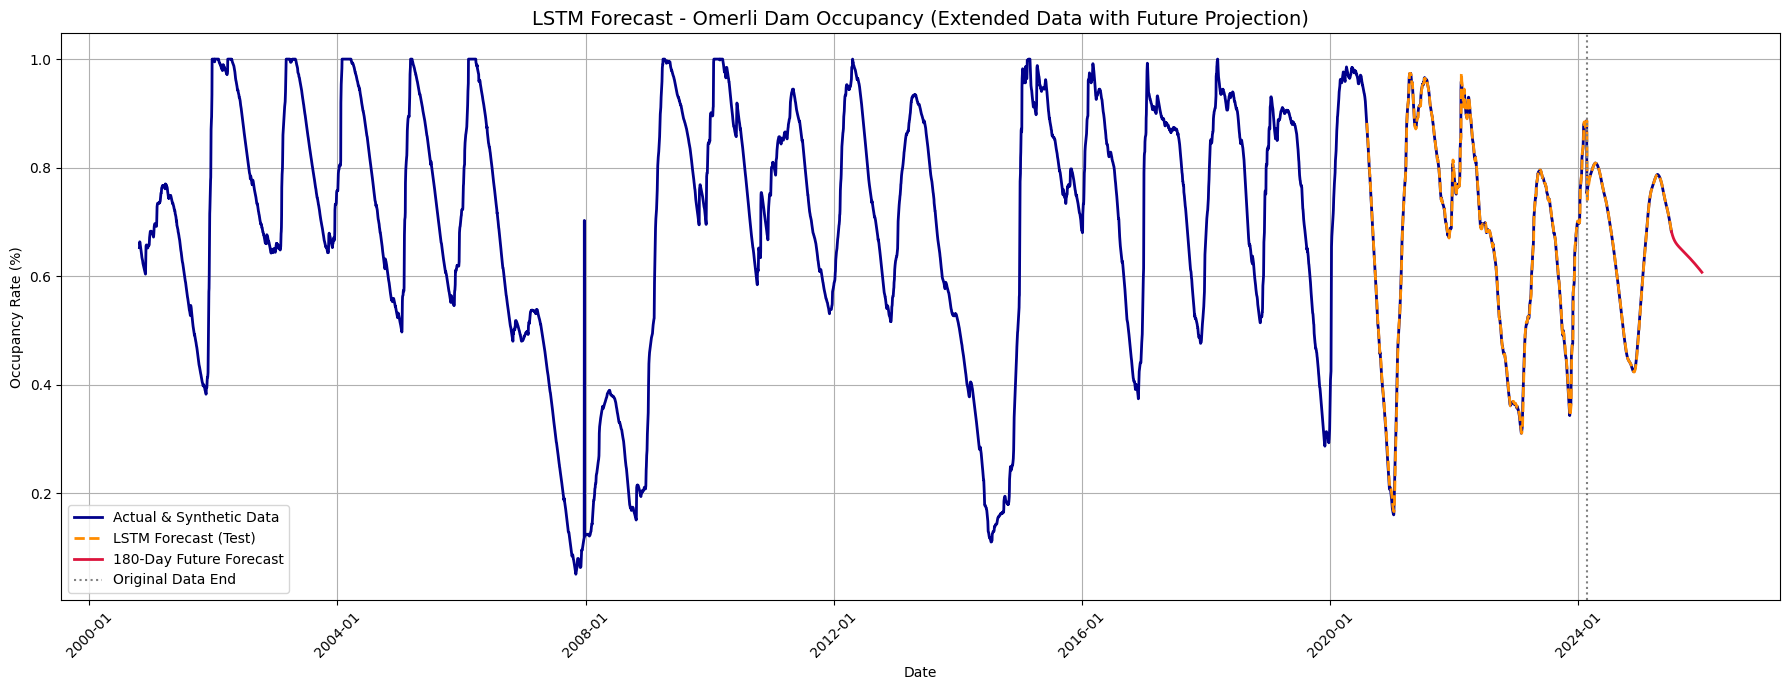

    > Saving trained model and scaler...
    > LSTM model saved: ../models\omerli\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\omerli\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\omerli\lstm_univariate_only_occupancy_metrics.txt

  > Training Univariate LSTM for: Darlik
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0867 - val_loss: 0.0017
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0076 - val_loss: 0.0012
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━

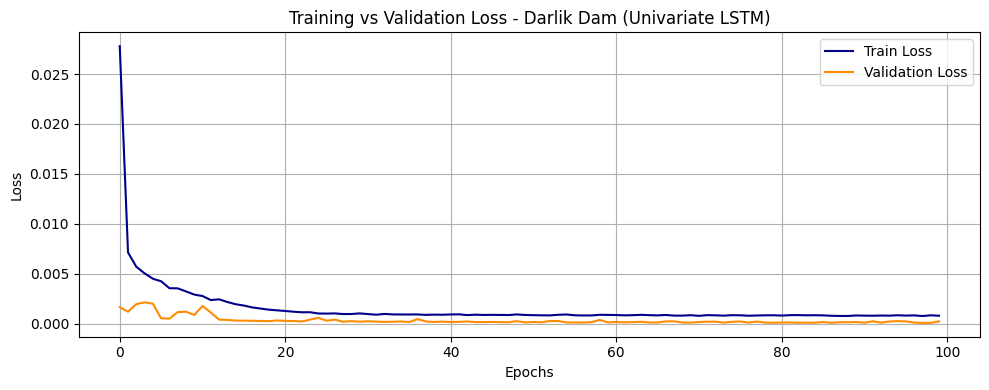

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0042
    > LSTM RMSE (Test Set): 0.0087
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_darlik_forecast_with_future.png


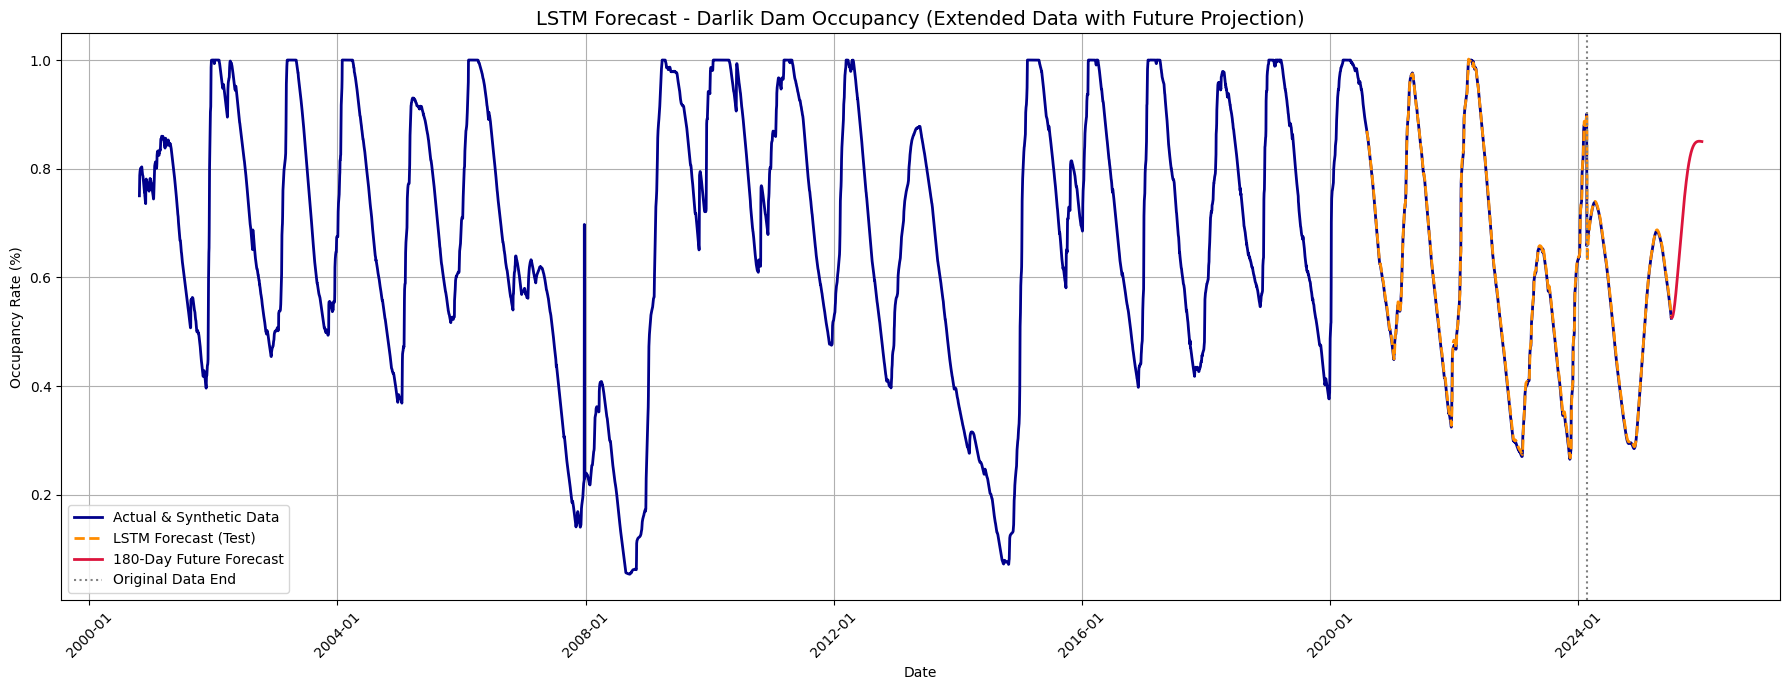

    > Saving trained model and scaler...
    > LSTM model saved: ../models\darlik\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\darlik\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\darlik\lstm_univariate_only_occupancy_metrics.txt

  > Training Univariate LSTM for: Elmali
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0358 - val_loss: 0.0017
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0063 - val_loss: 0.0014
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0050 - val_loss: 9.9863e-04
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 6/100
196/196 ━━━━━━━━━━━━

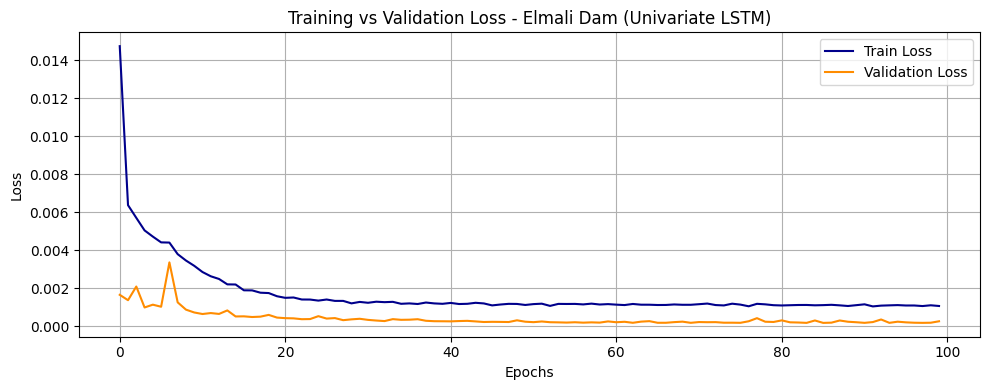

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
    > LSTM MAE (Test Set): 0.0042
    > LSTM RMSE (Test Set): 0.0137
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_elmali_forecast_with_future.png


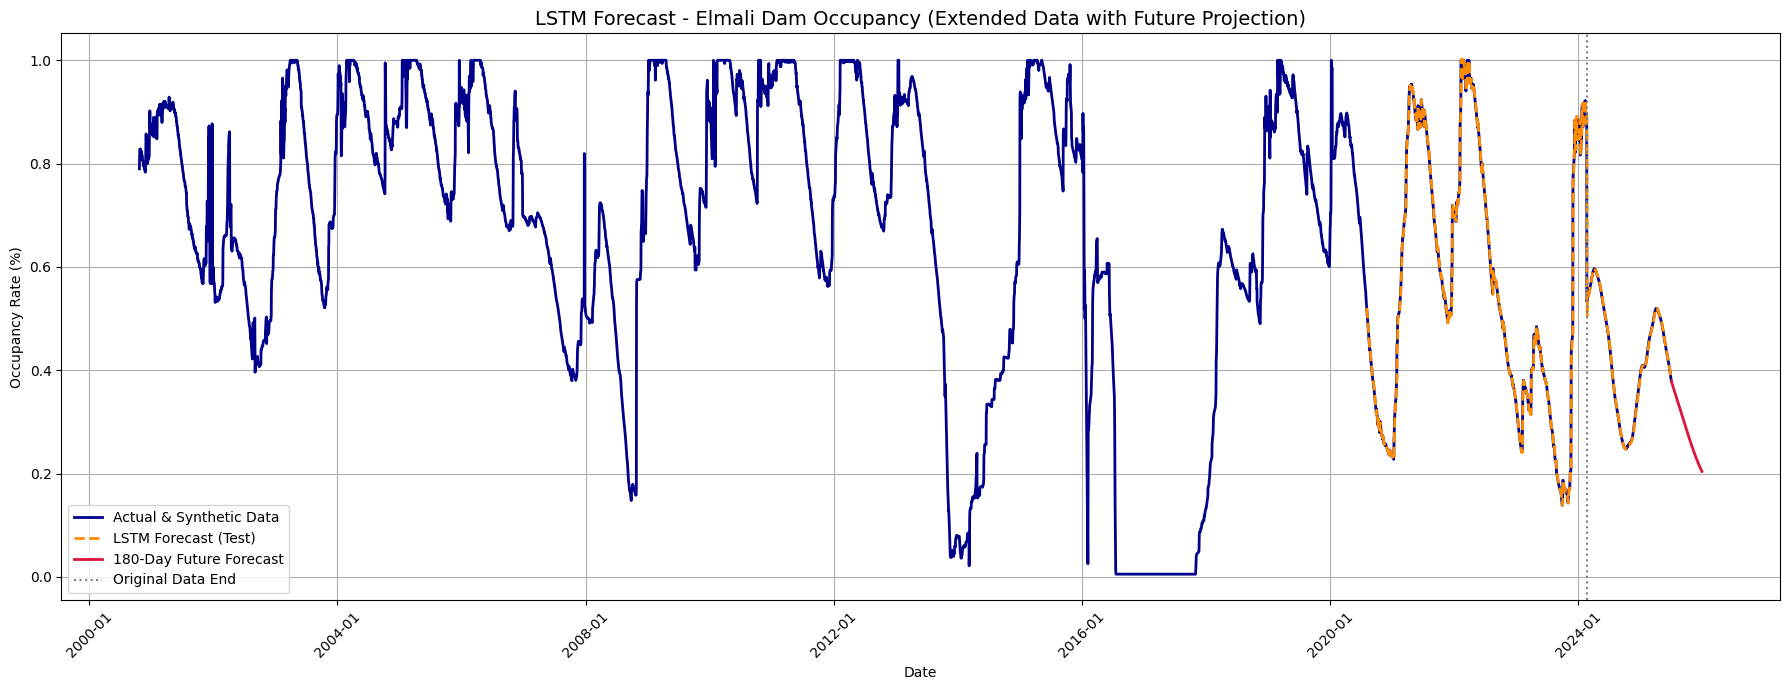

    > Saving trained model and scaler...
    > LSTM model saved: ../models\elmali\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\elmali\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\elmali\lstm_univariate_only_occupancy_metrics.txt

  > Training Univariate LSTM for: Terkos
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0609 - val_loss: 0.0018
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0074 - val_loss: 5.4531e-04
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0056 - val_loss: 7.0585e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0053 - val_loss: 4.9698e-04
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0048 - val_loss: 5.9005e-04
Epoch 6/100
196/196 

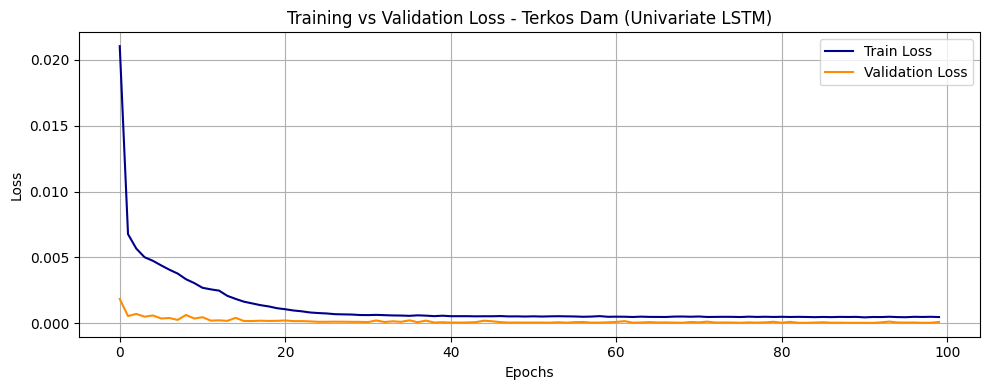

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
    > LSTM MAE (Test Set): 0.0024
    > LSTM RMSE (Test Set): 0.0072
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_terkos_forecast_with_future.png


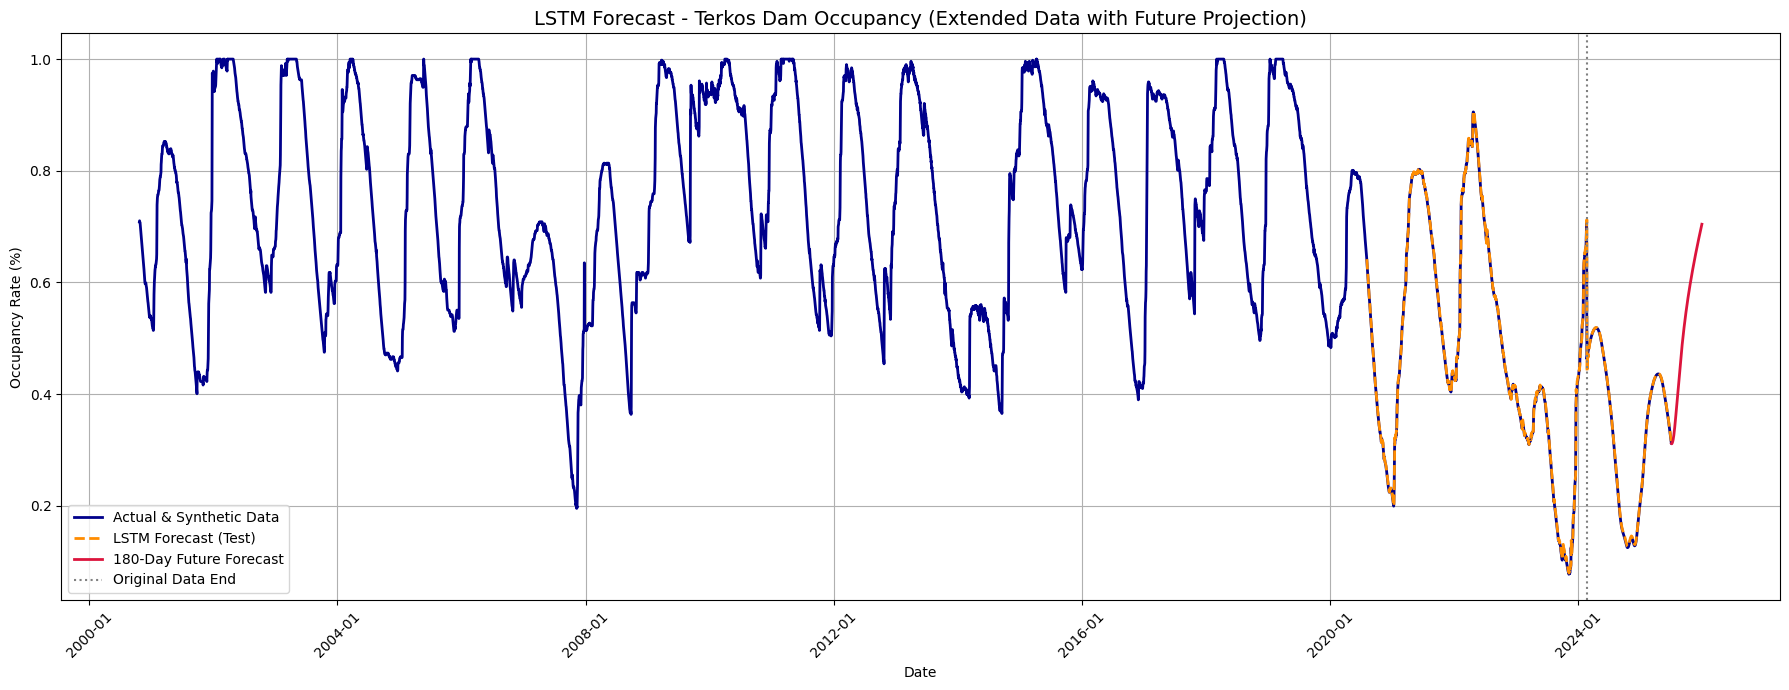

    > Saving trained model and scaler...
    > LSTM model saved: ../models\terkos\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\terkos\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\terkos\lstm_univariate_only_occupancy_metrics.txt

  > Training Univariate LSTM for: Alibey
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0588 - val_loss: 0.0016
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0062 - val_loss: 0.0024
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0054 - val_loss: 5.8712e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0047 - val_loss: 7.5165e-04
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0041 - val_loss: 7.1943e-04
Epoch 6/100
196/196 ━━━━

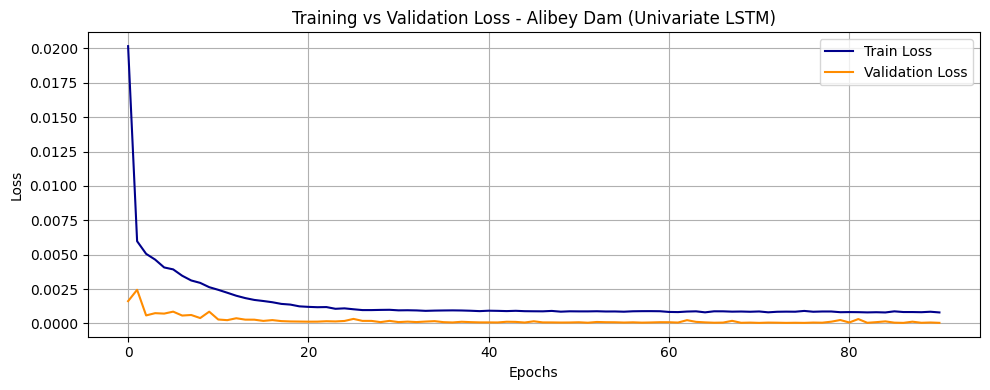

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
    > LSTM MAE (Test Set): 0.0035
    > LSTM RMSE (Test Set): 0.0102
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_alibey_forecast_with_future.png


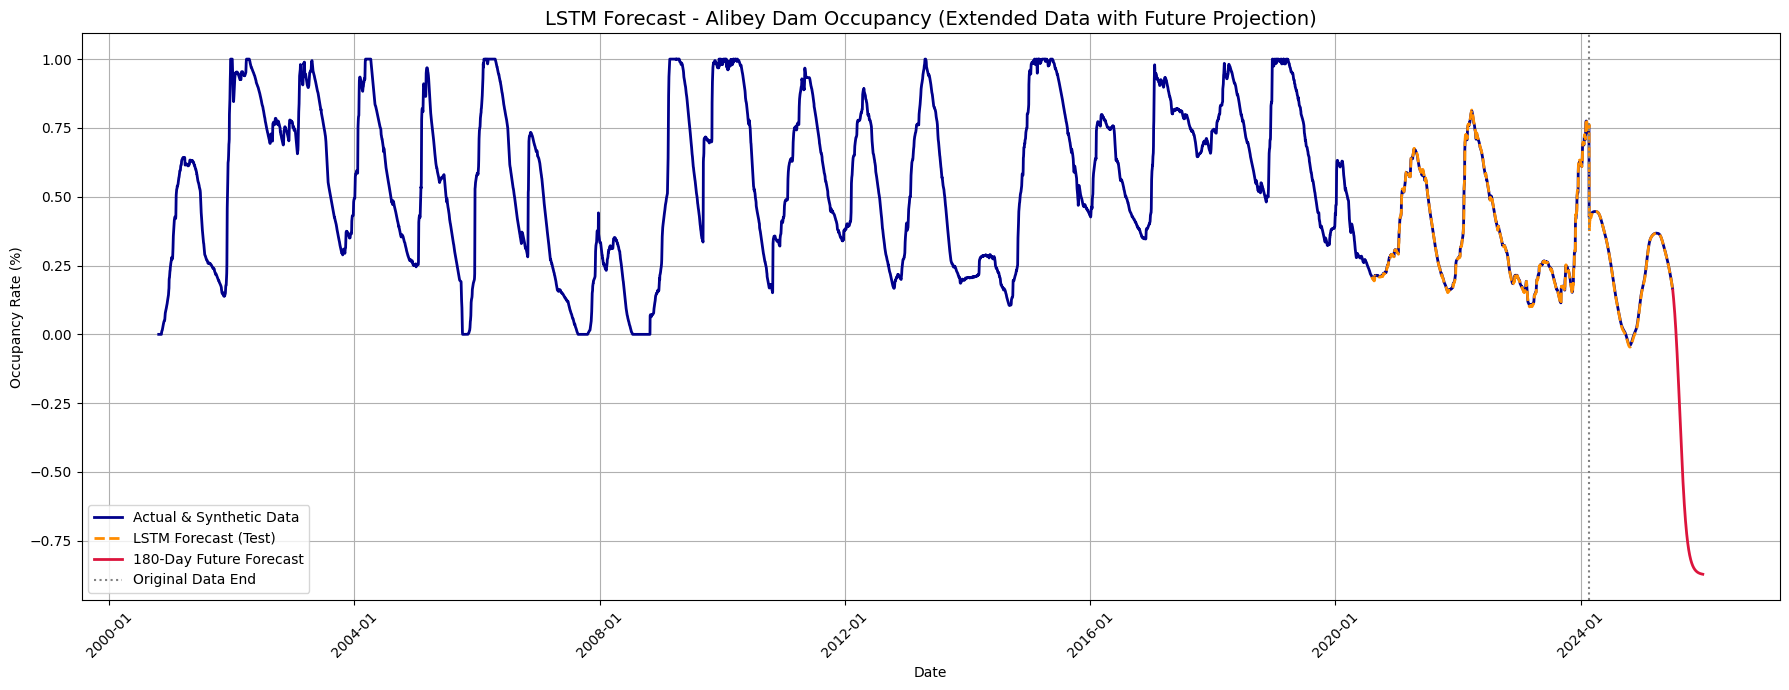

    > Saving trained model and scaler...
    > LSTM model saved: ../models\alibey\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\alibey\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\alibey\lstm_univariate_only_occupancy_metrics.txt

  > Training Univariate LSTM for: Buyukcekmece
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0491 - val_loss: 6.6103e-04
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0057 - val_loss: 5.3500e-04
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0047 - val_loss: 3.1794e-04
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0042 - val_loss: 4.3091e-04
Epoch 6/100
19

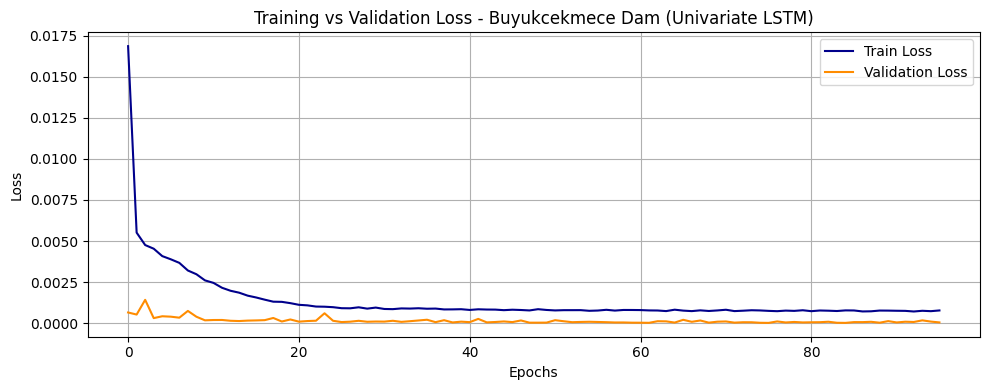

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
    > LSTM MAE (Test Set): 0.0034
    > LSTM RMSE (Test Set): 0.0090
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_buyukcekmece_forecast_with_future.png


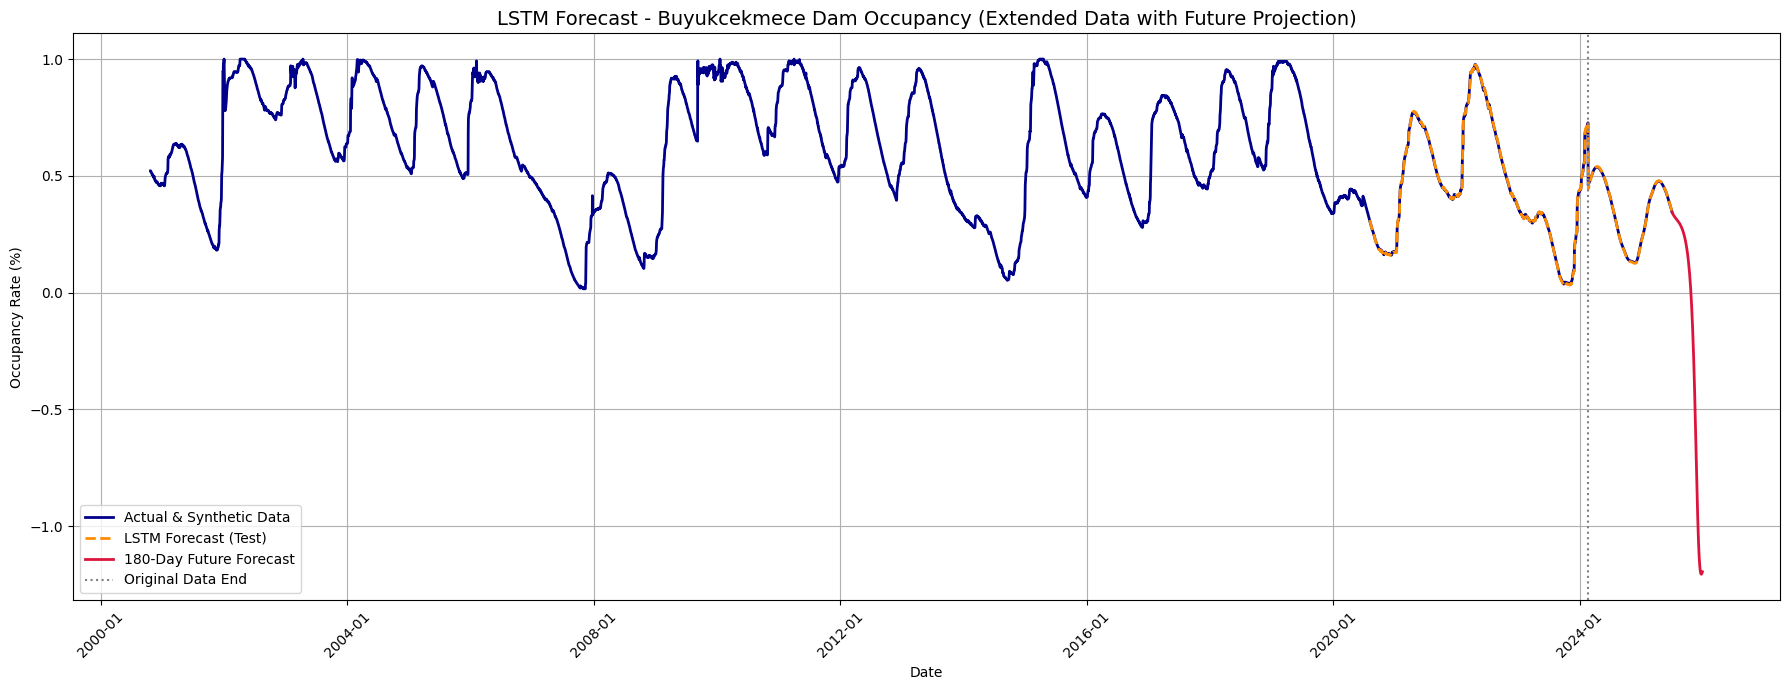

    > Saving trained model and scaler...
    > LSTM model saved: ../models\buyukcekmece\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\buyukcekmece\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\buyukcekmece\lstm_univariate_only_occupancy_metrics.txt

  > Training Univariate LSTM for: Sazlidere
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0529 - val_loss: 8.0111e-04
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0057 - val_loss: 6.3355e-04
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0043 - val_loss: 3.6227e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0040 - val_loss: 5.7990e-04
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0037 - val_loss: 3.7658

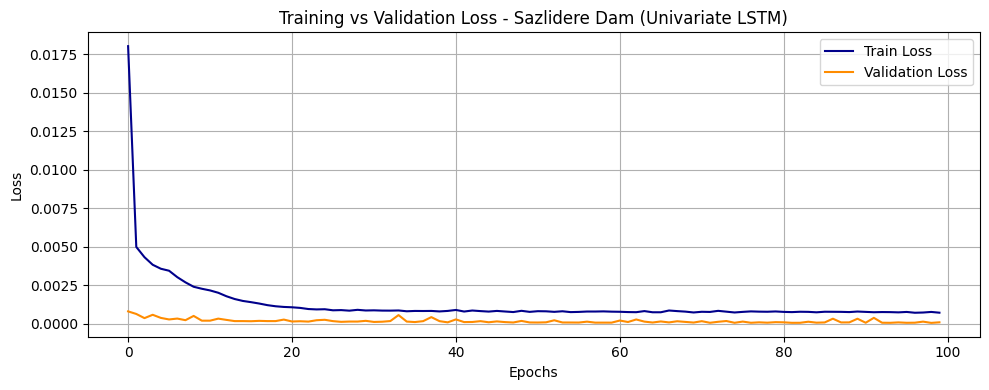

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
    > LSTM MAE (Test Set): 0.0026
    > LSTM RMSE (Test Set): 0.0067
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_sazlidere_forecast_with_future.png


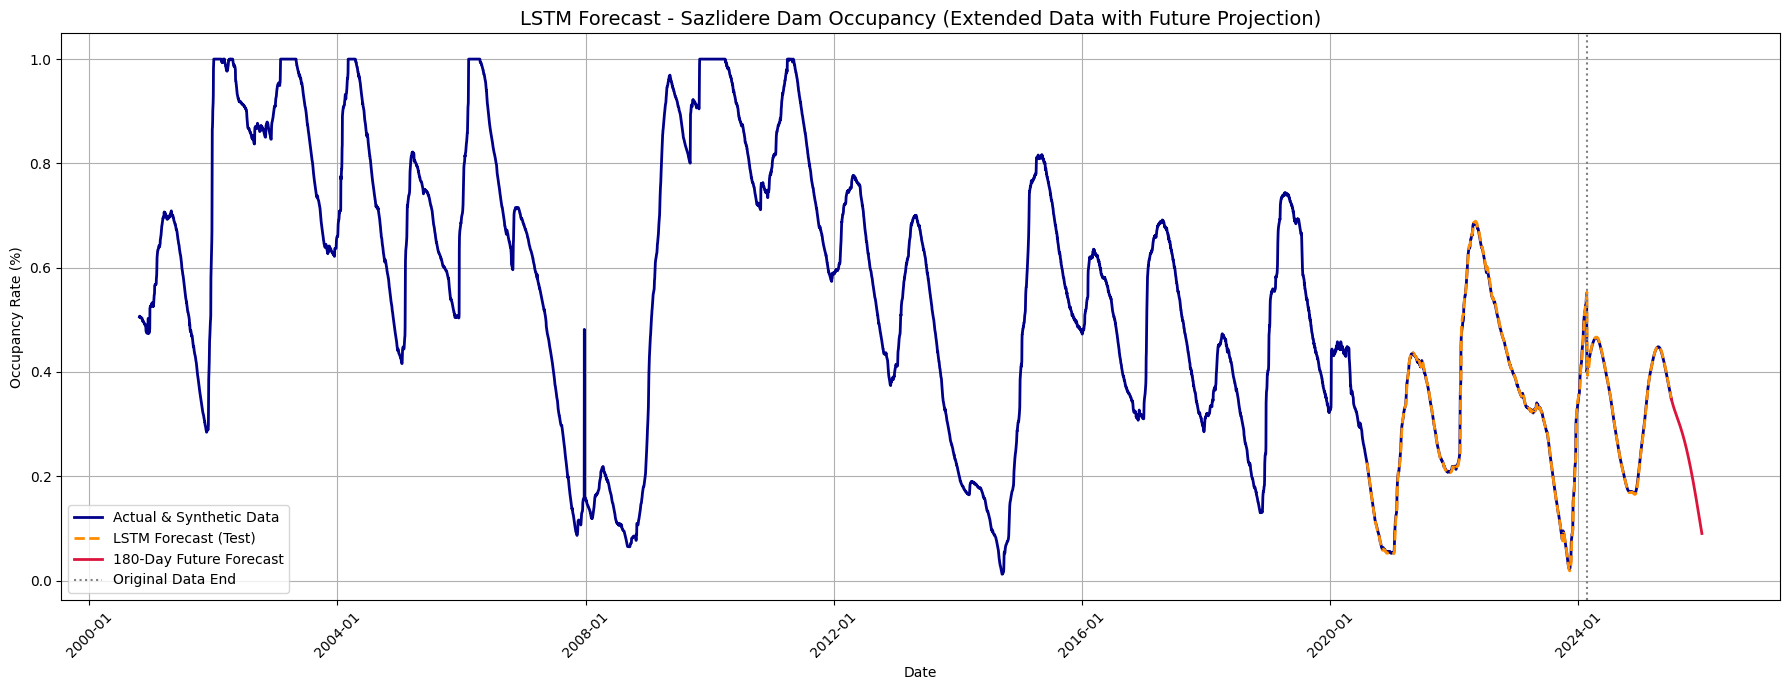

    > Saving trained model and scaler...
    > LSTM model saved: ../models\sazlidere\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\sazlidere\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\sazlidere\lstm_univariate_only_occupancy_metrics.txt

  > Training Univariate LSTM for: Kazandere
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0650 - val_loss: 0.0013
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0092 - val_loss: 0.0026
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0080 - val_loss: 9.3619e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0066 - val_loss: 5.9412e-04
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0063 - val_loss: 5.1882e-04
Epoch 6/100


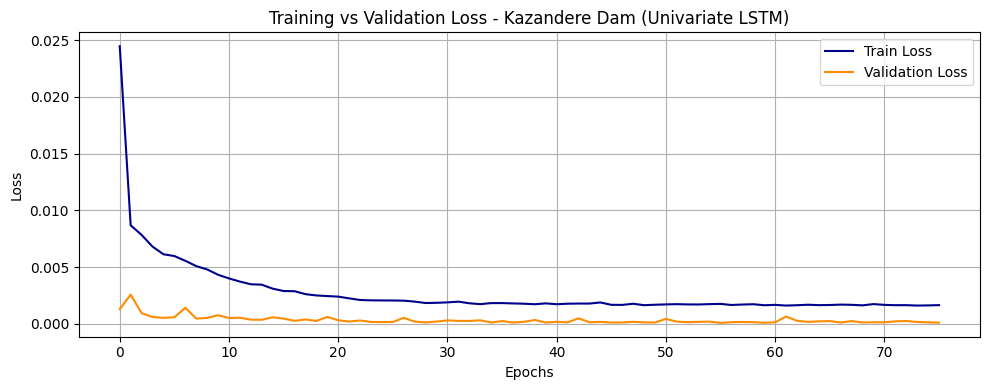

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
    > LSTM MAE (Test Set): 0.0055
    > LSTM RMSE (Test Set): 0.0168
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_kazandere_forecast_with_future.png


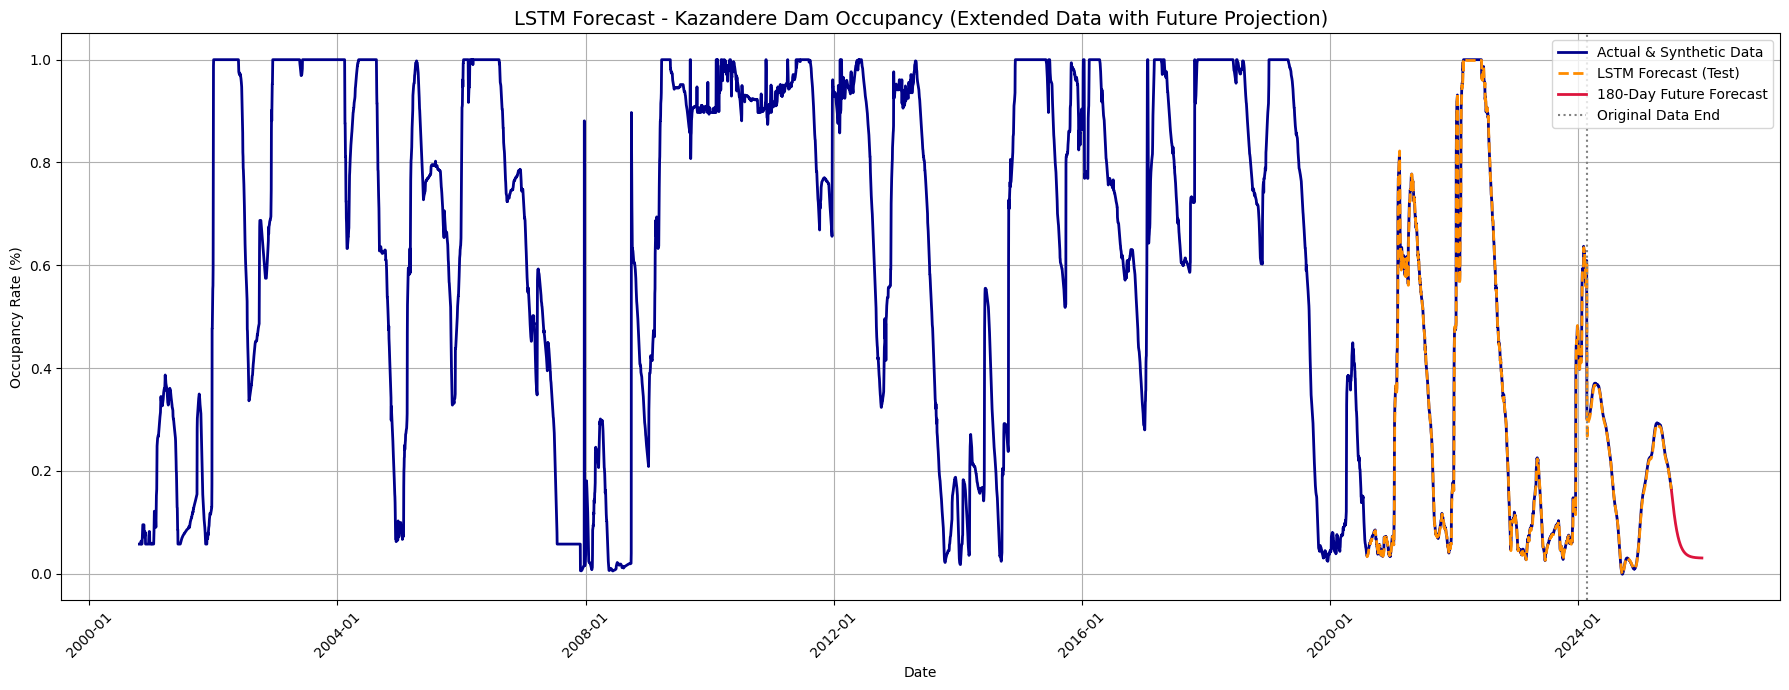

    > Saving trained model and scaler...
    > LSTM model saved: ../models\kazandere\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\kazandere\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\kazandere\lstm_univariate_only_occupancy_metrics.txt

  > Training Univariate LSTM for: Pabucdere
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0375 - val_loss: 8.5853e-04
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0070 - val_loss: 6.4180e-04
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0065 - val_loss: 4.9662e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0055 - val_loss: 5.7654e-04
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0047 - val_loss: 5.1096e-04
Epo

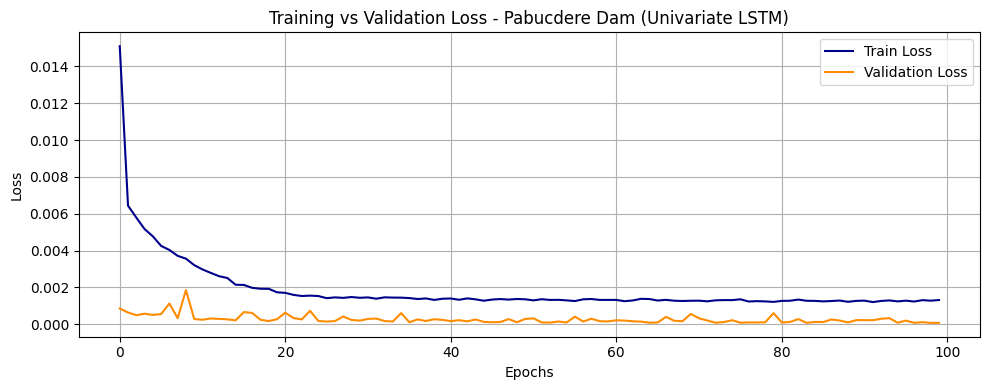

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0048
    > LSTM RMSE (Test Set): 0.0126
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_pabucdere_forecast_with_future.png


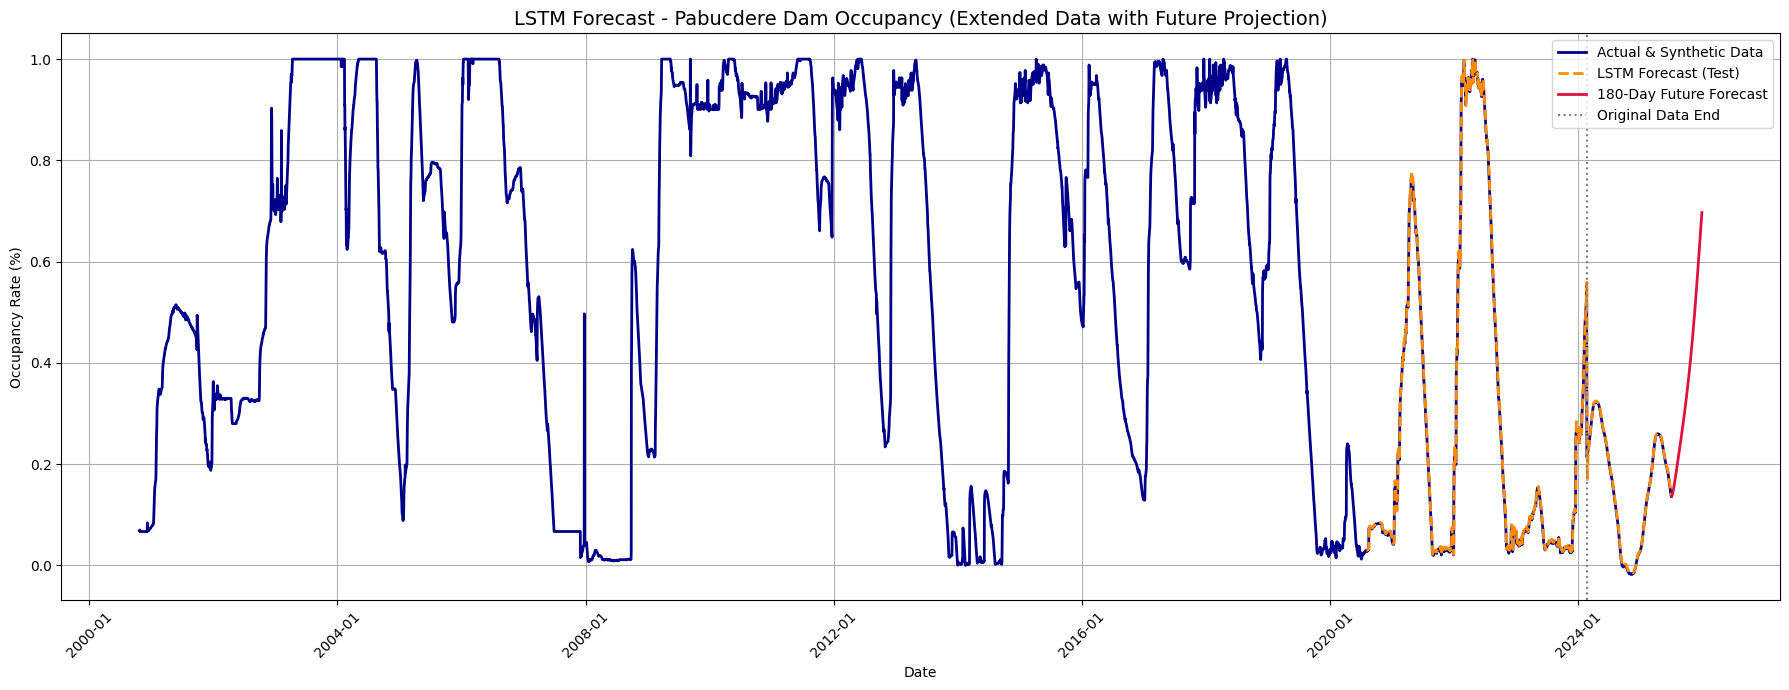

    > Saving trained model and scaler...
    > LSTM model saved: ../models\pabucdere\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\pabucdere\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\pabucdere\lstm_univariate_only_occupancy_metrics.txt

  > Training Univariate LSTM for: Istrancalar
    > Data scaling completed.
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0876 - val_loss: 0.0095
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0163 - val_loss: 0.0070
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0123 - val_loss: 0.0052
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0114 - val_loss: 0.0044
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 6/100
196/196 ━━

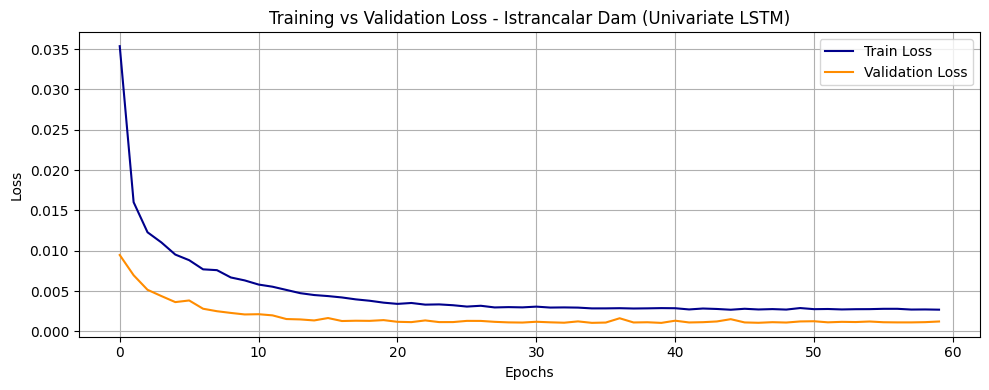

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
    > LSTM MAE (Test Set): 0.0143
    > LSTM RMSE (Test Set): 0.0354
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_univariate_only_occupancy_istrancalar_forecast_with_future.png


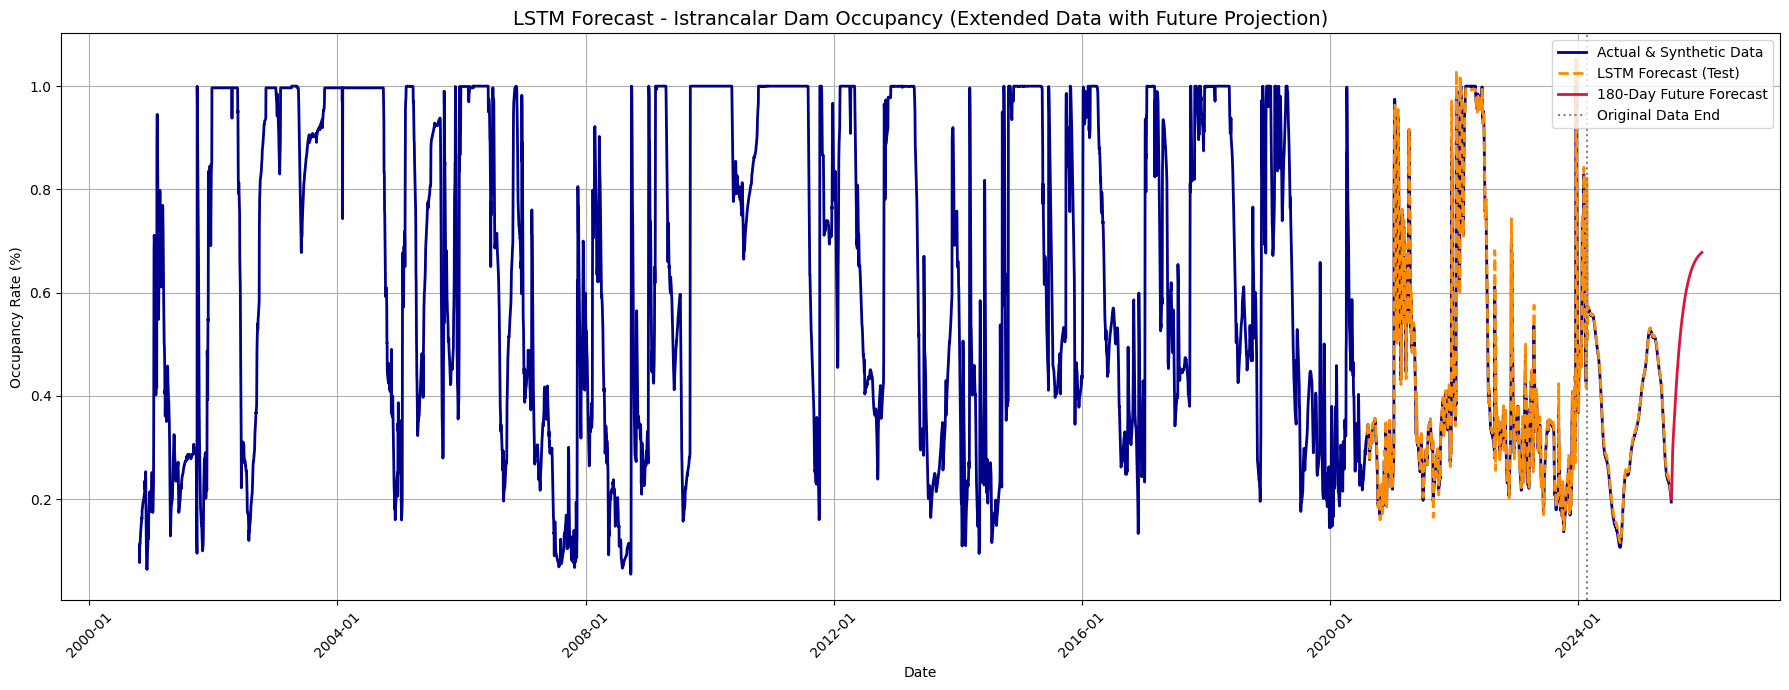

    > Saving trained model and scaler...
    > LSTM model saved: ../models\istrancalar\lstm_univariate_only_occupancy_model.h5
    > Scaler saved: ../models\istrancalar\scaler_univariate_only_occupancy.pkl
    > Metrics saved: ../models\istrancalar\lstm_univariate_only_occupancy_metrics.txt

Univariate LSTM model training and saving process completed for all dams.

--- Next Task Reminder ---
Please share the code for the next model you want to update.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Tarih formatlama için
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping eklendi
import os
import joblib

# --- 1. Dizinleri Oluşturma ---
# Her baraj için ayrı klasörler önceden oluşturulmuş olmalı (örn: ../models/omerli)
# Plotları kaydetmek için klasör
os.makedirs("../results/plots", exist_ok=True)

print("Processing Univariate LSTM models for each dam...")

# --- 2. Veri Yükleme ve Hazırlık ---
# DÜZELTME: Sentetik verilerle genişletilmiş dam occupancy dosyasını okuyoruz
file_path_occupancy_synthetic = "../data/processed/istanbul-dams-daily-occupancy-rates-cleaned_with_synthetic.csv"
df_occupancy_synthetic = pd.read_csv(file_path_occupancy_synthetic)
df_occupancy_synthetic['Tarih'] = pd.to_datetime(df_occupancy_synthetic['Tarih'])
print("  > Reading extended dam occupancy data.")

df_occupancy_synthetic.ffill(inplace=True)
df_occupancy_synthetic.bfill(inplace=True)

# Sadece baraj doluluk sütunları
dam_columns = df_occupancy_synthetic.columns.drop('Tarih').tolist()

# --- 3. Sekans Oluşturma Fonksiyonu ---
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Sabit TIME_STEPS
TIME_STEPS = 60

# --- 4. Her Baraj İçin Döngü ---
for dam_name in dam_columns:
    print(f"\n  > Training Univariate LSTM for: {dam_name}")

    # Modelin eğitildiği seriyi al
    series = df_occupancy_synthetic[[dam_name]].values # DataFrame'den 2D array olarak al

    # Normalizing
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series)
    print("    > Data scaling completed.")

    # Creating sequences
    X_seq, y_seq = create_sequences(series_scaled, TIME_STEPS)
    print(f"    > Sequences created with TIME_STEPS = {TIME_STEPS}.")

    # Train/val/test split
    # Oranlar orijinal koddan alındı
    train_size = int(len(X_seq) * 0.7)
    val_size = int(len(X_seq) * 0.1)
    # Kalan %0.2 test olacak
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
    X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

    # Test seti için tarihler
    # df_occupancy_synthetic'in orijinal indeksi kullanılıyor, ancak df_occupancy_synthetic.index[-len(y_test)] doğru olmalı.
    # Sekanslar oluşturulduktan sonraki tarihler.
    dates_full_series = df_occupancy_synthetic['Tarih'].iloc[TIME_STEPS:].reset_index(drop=True)
    dates_test = dates_full_series[train_size + val_size:].reset_index(drop=True)
    print(f"    > Data split into Train ({len(X_train)}), Validation ({len(X_val)}), Test ({len(X_test)}) sets.")


    # Model building
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1))) # Tek değişkenli olduğu için input_shape'in son boyutu 1
    model.add(Dropout(0.2)) # Dropout eklendi
    model.add(LSTM(32, activation='tanh'))
    model.add(Dropout(0.2)) # Dropout eklendi
    model.add(Dense(1)) # Tek çıktı
    model.compile(optimizer='adam', loss='mse')
    print("    > LSTM model built.")

    # Training
    # DÜZELTME: EarlyStopping eklendi
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    print("    > Training the LSTM model...")
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=100, # Epoch sayısı artırıldı, EarlyStopping kontrol edecek
                        batch_size=32, 
                        callbacks=[early_stopping], # EarlyStopping callback'i eklendi
                        verbose=1)
    print("    > LSTM model training completed.")

    # Kayıp grafiği (overfit kontrolü)
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss', color='darkblue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
    plt.title(f"Training vs Validation Loss - {dam_name} Dam (Univariate LSTM)", fontsize=12)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plot_loss_path = f"../results/plots/lstm_univariate_only_occupancy_{dam_name.lower()}_loss_curve.png"
    plt.savefig(plot_loss_path)
    print(f"    > Loss curve plot saved: {plot_loss_path}")
    plt.show()


    # Evaluation on test set
    y_pred_scaled = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred_scaled)
    y_test_inv = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"    > LSTM MAE (Test Set): {mae:.4f}")
    print(f"    > LSTM RMSE (Test Set): {rmse:.4f}")


    # --- Gelecek Tahmini (Future Forecast) ---
    FORECAST_FUTURE_DAYS = 180 # Sonraki 6 ay
    print(f"    > Generating {FORECAST_FUTURE_DAYS}-day future forecast...")

    # Son bilinen sekansı al
    last_sequence_scaled = series_scaled[-TIME_STEPS:].reshape(1, TIME_STEPS, 1) # Son sequence, 3D olmalı
    future_preds_scaled = []

    for _ in range(FORECAST_FUTURE_DAYS):
        next_pred_scaled = model.predict(last_sequence_scaled, verbose=0)[0,0] # Tahmin edilen tek değer
        future_preds_scaled.append(next_pred_scaled)
        
        # Sekansı güncelle: İlk elemanı at, yeni tahmini sona ekle
        # Tek değişkenli modelde bu daha basit: sadece yeni tahmini ekle
        next_input_feature_vector_scaled = np.array([next_pred_scaled]).reshape(1,1,1) # Shape (1, 1, 1)
        last_sequence_scaled = np.append(last_sequence_scaled[:, 1:, :], next_input_feature_vector_scaled, axis=1)

    future_preds_inv = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

    # Gelecek tarihler
    future_dates = pd.date_range(dates_test.iloc[-1] + pd.Timedelta(days=1), periods=FORECAST_FUTURE_DAYS)
    print(f"    > Future forecast generated up to: {future_dates.max()}")


    # --- Plotting forecast vs actual (Updated to include Future Forecast) ---
    print("    > Plotting forecast with future projection...")
    plt.figure(figsize=(18, 7))

    # Tüm df_occupancy_synthetic'teki geçmiş veriyi çiz (gerçek + sentetik)
    plt.plot(df_occupancy_synthetic['Tarih'], df_occupancy_synthetic[dam_name], color='darkblue', linewidth=2, label='Actual & Synthetic Data')

    # Test seti tahminlerini çiz (turuncu kesikli)
    plt.plot(dates_test, y_pred_inv, color='darkorange', linestyle='--', linewidth=2, label='LSTM Forecast (Test)')

    # Gelecek tahminini çiz (kırmızı düz çizgi)
    plt.plot(future_dates, future_preds_inv, color='crimson', linestyle='-', linewidth=2, label=f'{FORECAST_FUTURE_DAYS}-Day Future Forecast')

    # Orijinal verinin bittiği noktayı işaretle
    original_data_end_date = pd.to_datetime('2024-02-19')
    plt.axvline(original_data_end_date, color='gray', linestyle=':', linewidth=1.5, label='Original Data End')

    plt.title(f"LSTM Forecast - {dam_name} Dam Occupancy (Extended Data with Future Projection)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Plotu kaydetme
    plot_save_path = f"../results/plots/lstm_univariate_only_occupancy_{dam_name.lower()}_forecast_with_future.png"
    plt.savefig(plot_save_path)
    print(f"    > Plot saved: {plot_save_path}")
    plt.show()

    # --- Saving the trained model and scaler ---
    print("    > Saving trained model and scaler...")
    # Yeni klasör yapısına uygun olarak kaydedilecek: ../models/barajadi/lstm_univariate_only_occupancy_model.h5
    model_save_dir = os.path.join("../models", dam_name.lower())
    
    model_save_path = os.path.join(model_save_dir, "lstm_univariate_only_occupancy_model.h5")
    model.save(model_save_path)
    print(f"    > LSTM model saved: {model_save_path}")

    # Scaler'ın kaydedilmesi (her barajın kendi klasörüne)
    scaler_save_path = os.path.join(model_save_dir, "scaler_univariate_only_occupancy.pkl")
    joblib.dump(scaler, scaler_save_path)
    print(f"    > Scaler saved: {scaler_save_path}")

    # Metriklerin kaydedilmesi
    metrics_save_path = os.path.join(model_save_dir, "lstm_univariate_only_occupancy_metrics.txt")
    with open(metrics_save_path, "w") as f:
        f.write(f"MAE: {mae:.4f}\n")
        f.write(f"RMSE: {rmse:.4f}\n")
    print(f"    > Metrics saved: {metrics_save_path}")

print("\nUnivariate LSTM model training and saving process completed for all dams.")

## Multivariate LSTM for Dam-Specific Forecasting 

Processing Multivariate LSTM models (occupancy only) for each dam...
  > Reading extended dam occupancy data.

  > Training Multivariate LSTM (Occupancy Only) for: Omerli
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0280 - val_loss: 0.0042
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0066 - val_loss: 0.0032
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━

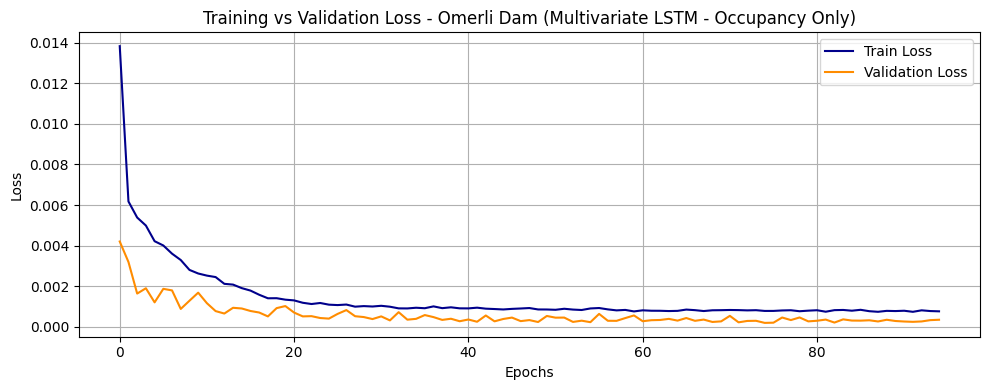

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0104
    > LSTM RMSE (Test Set): 0.0151
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_omerli_forecast_with_future.png


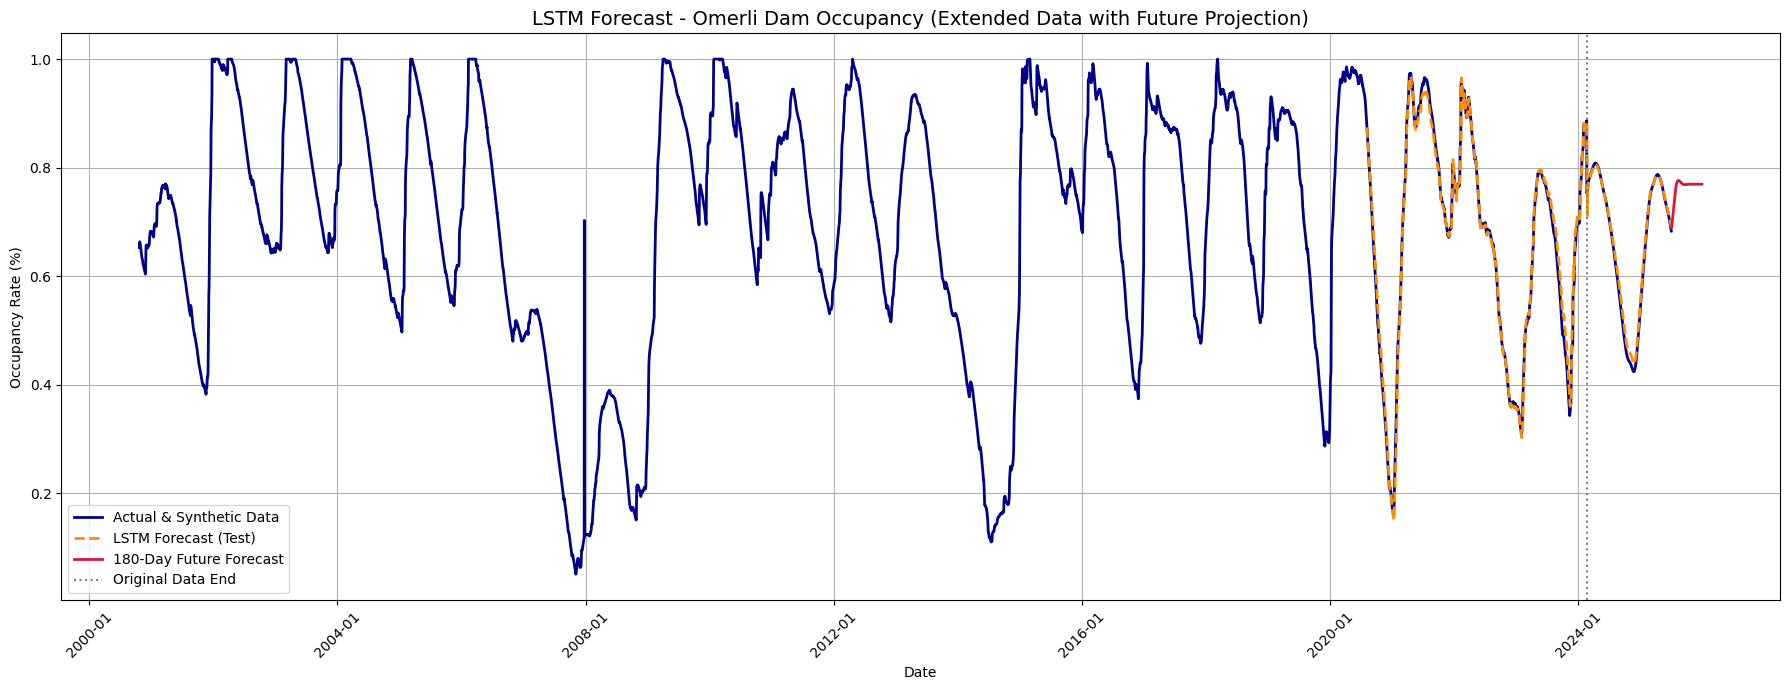

    > Saving trained model and scalers...
    > LSTM model saved: ../models\omerli\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\omerli\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\omerli\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\omerli\lstm_multivariate_occupancy_only_metrics.txt

  > Training Multivariate LSTM (Occupancy Only) for: Darlik
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0616 - val_loss: 0.0021
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0055 - val_loss: 0.0013
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 

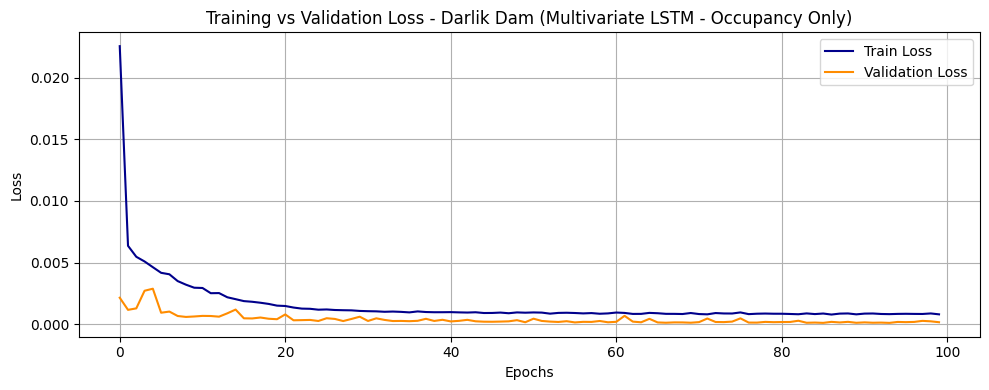

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0063
    > LSTM RMSE (Test Set): 0.0108
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_darlik_forecast_with_future.png


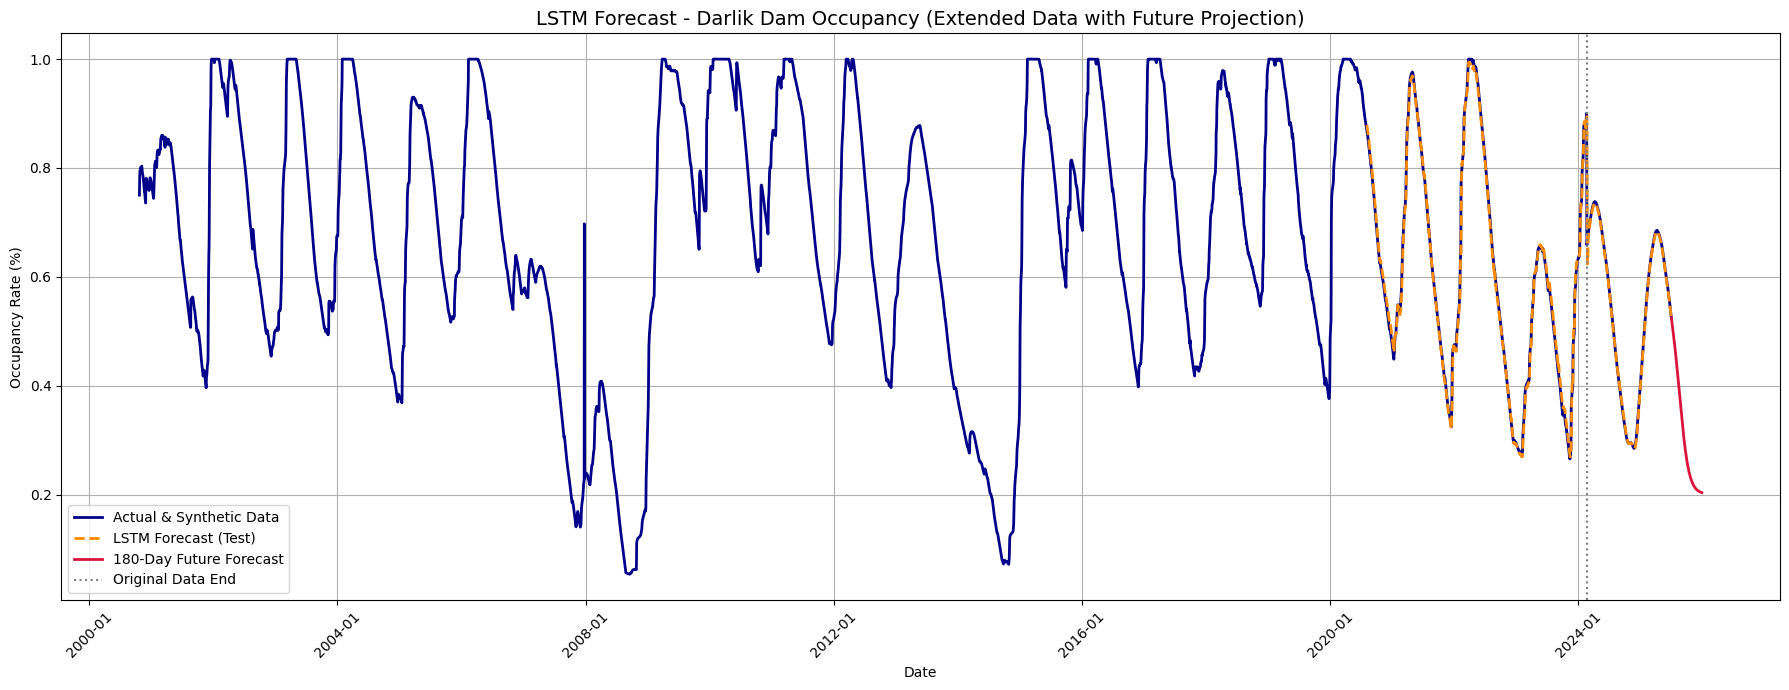

    > Saving trained model and scalers...
    > LSTM model saved: ../models\darlik\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\darlik\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\darlik\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\darlik\lstm_multivariate_occupancy_only_metrics.txt

  > Training Multivariate LSTM (Occupancy Only) for: Elmali
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0770 - val_loss: 0.0024
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0087 - val_loss: 0.0029
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0069 - val_loss: 0.0014
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 

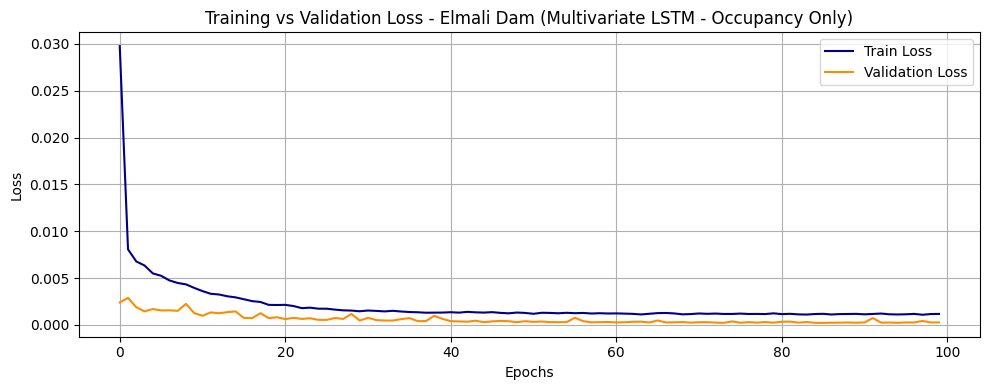

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0062
    > LSTM RMSE (Test Set): 0.0150
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_elmali_forecast_with_future.png


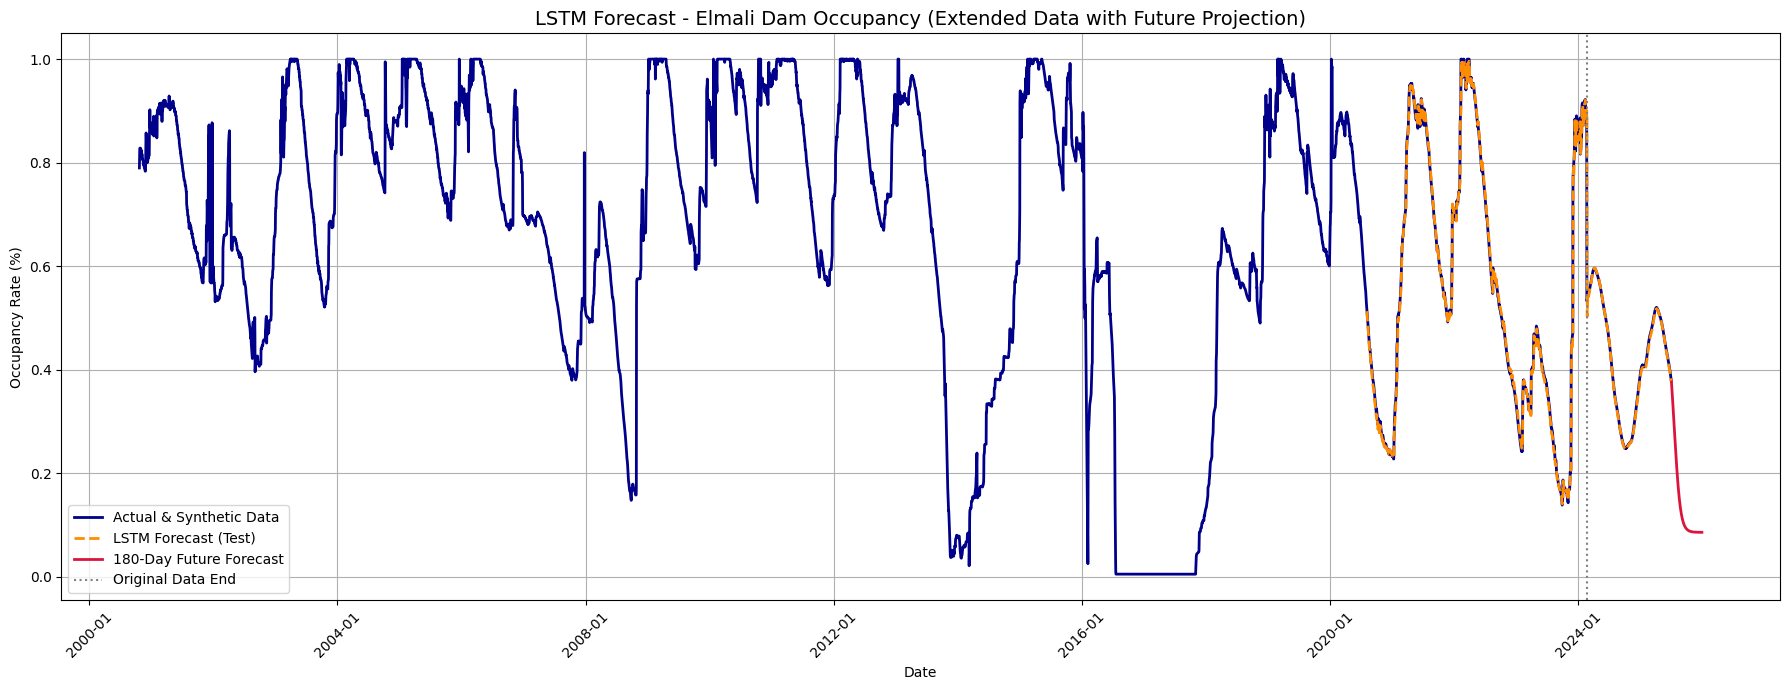

    > Saving trained model and scalers...
    > LSTM model saved: ../models\elmali\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\elmali\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\elmali\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\elmali\lstm_multivariate_occupancy_only_metrics.txt

  > Training Multivariate LSTM (Occupancy Only) for: Terkos
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0379 - val_loss: 0.0016
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0079 - val_loss: 0.0020
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0060 - val_loss: 0.0010
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 

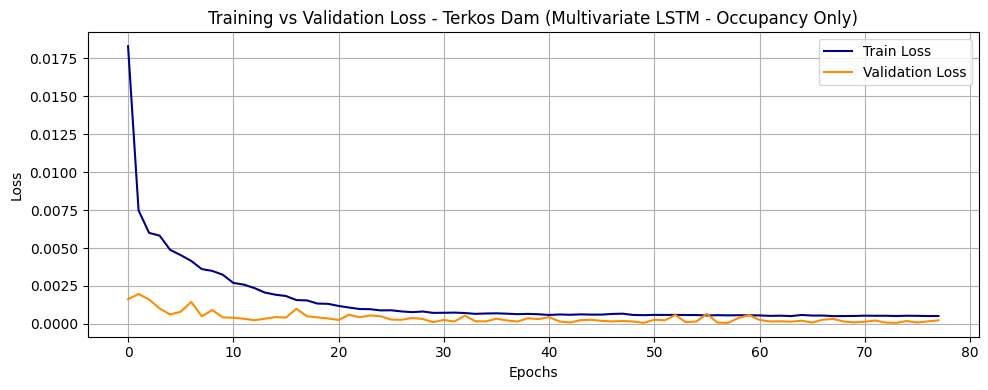

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0080
    > LSTM RMSE (Test Set): 0.0140
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_terkos_forecast_with_future.png


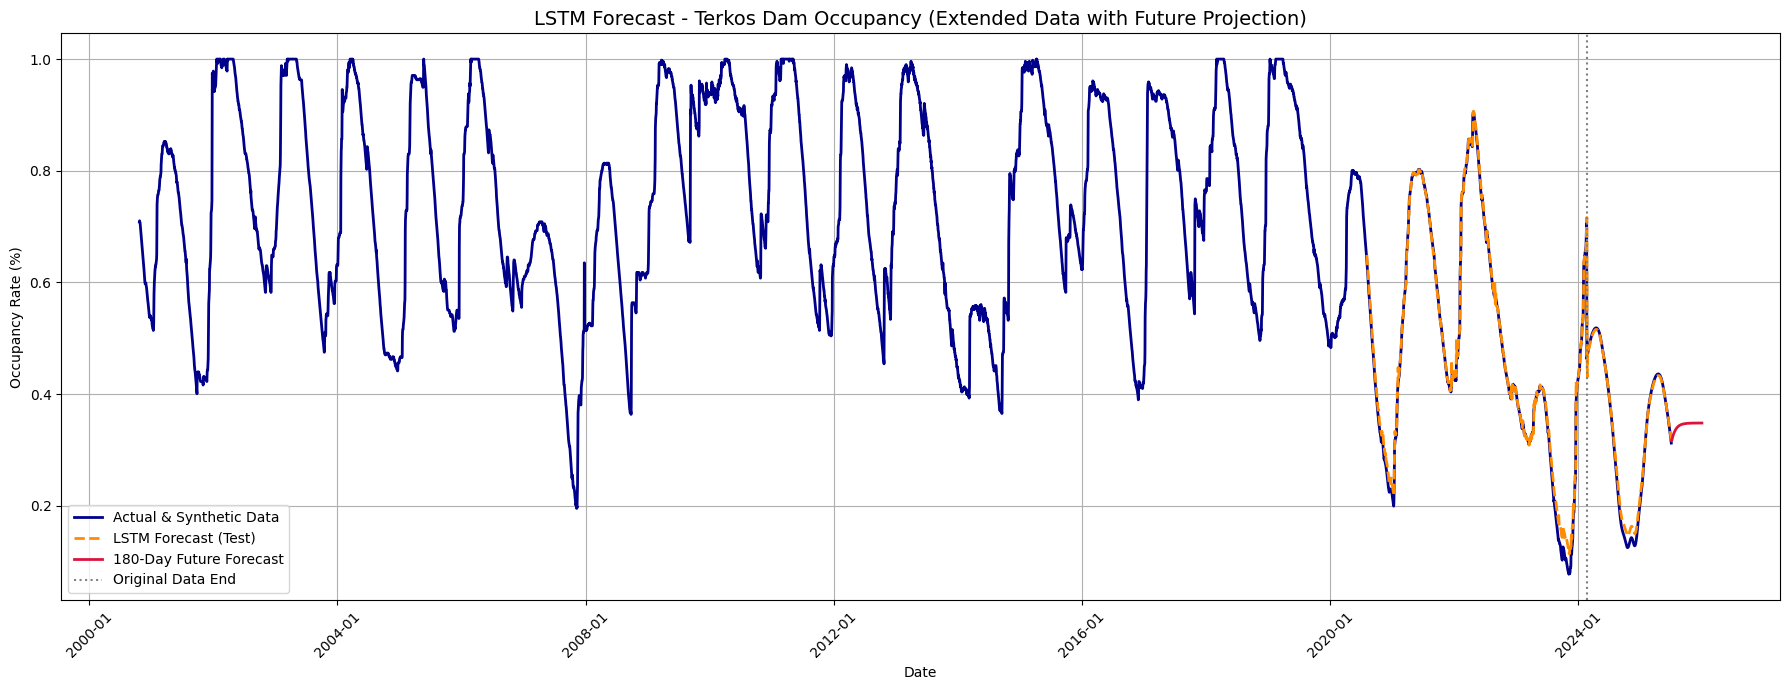

    > Saving trained model and scalers...
    > LSTM model saved: ../models\terkos\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\terkos\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\terkos\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\terkos\lstm_multivariate_occupancy_only_metrics.txt

  > Training Multivariate LSTM (Occupancy Only) for: Alibey
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0774 - val_loss: 0.0022
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0073 - val_loss: 0.0029
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 

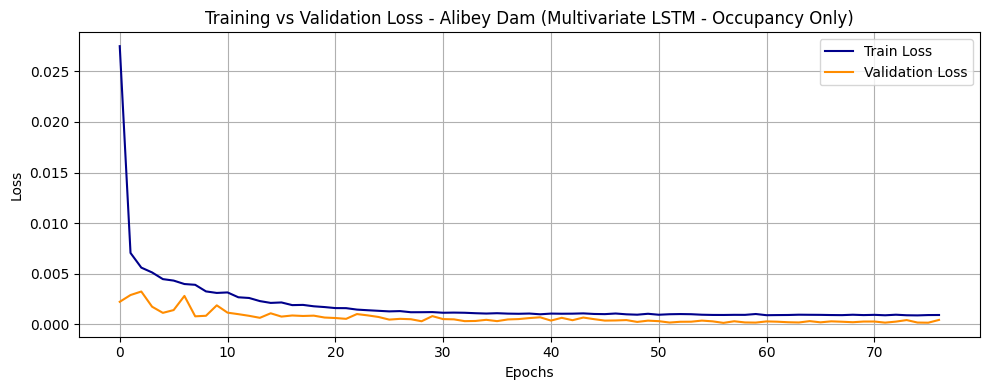

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0076
    > LSTM RMSE (Test Set): 0.0136
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_alibey_forecast_with_future.png


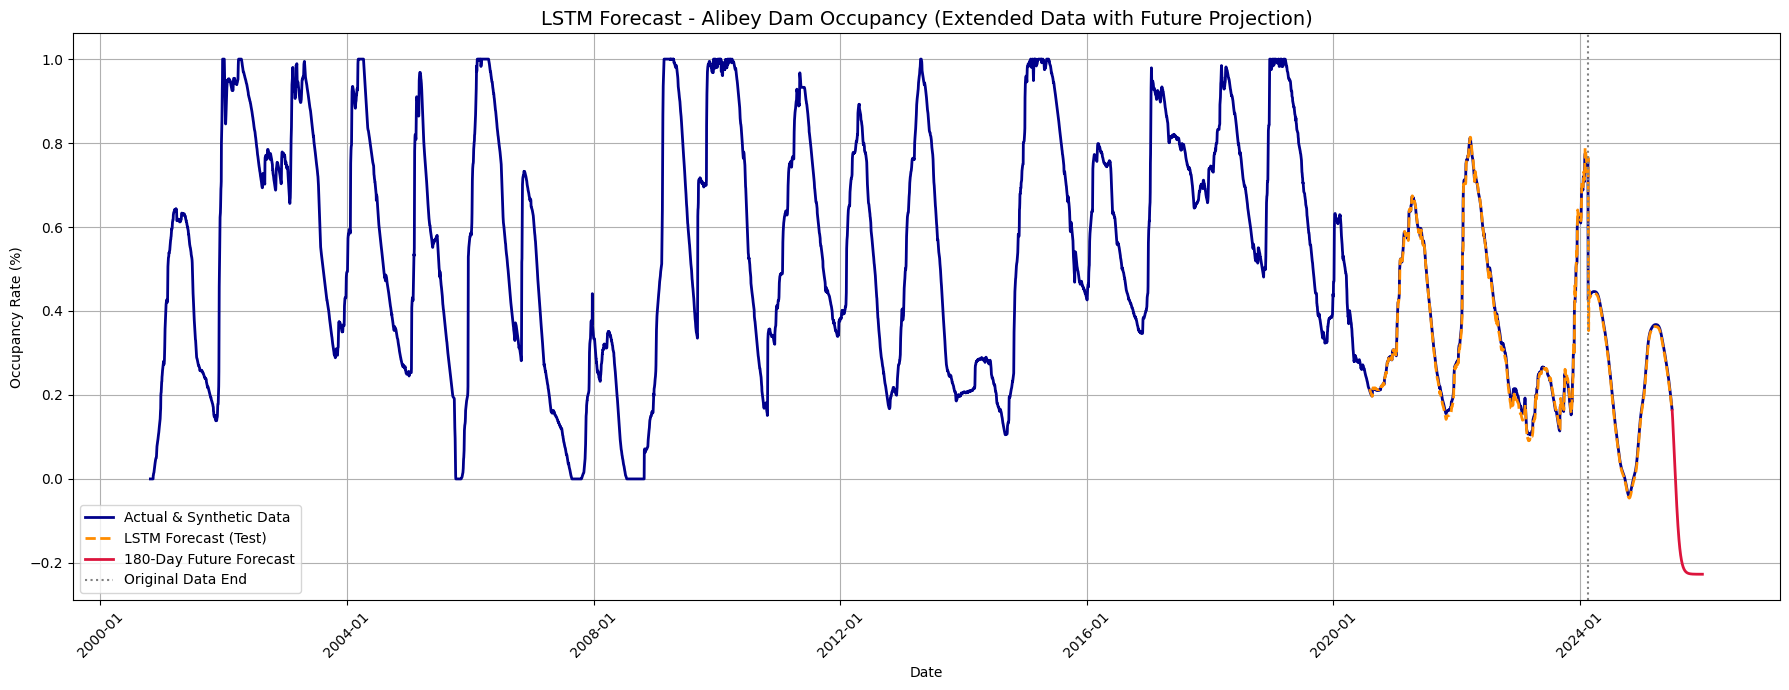

    > Saving trained model and scalers...
    > LSTM model saved: ../models\alibey\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\alibey\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\alibey\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\alibey\lstm_multivariate_occupancy_only_metrics.txt

  > Training Multivariate LSTM (Occupancy Only) for: Buyukcekmece
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0445 - val_loss: 0.0051
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━

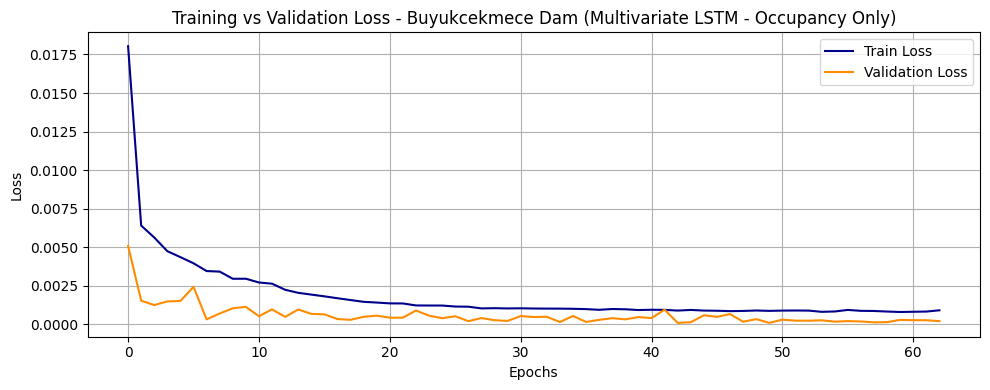

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0105
    > LSTM RMSE (Test Set): 0.0160
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_buyukcekmece_forecast_with_future.png


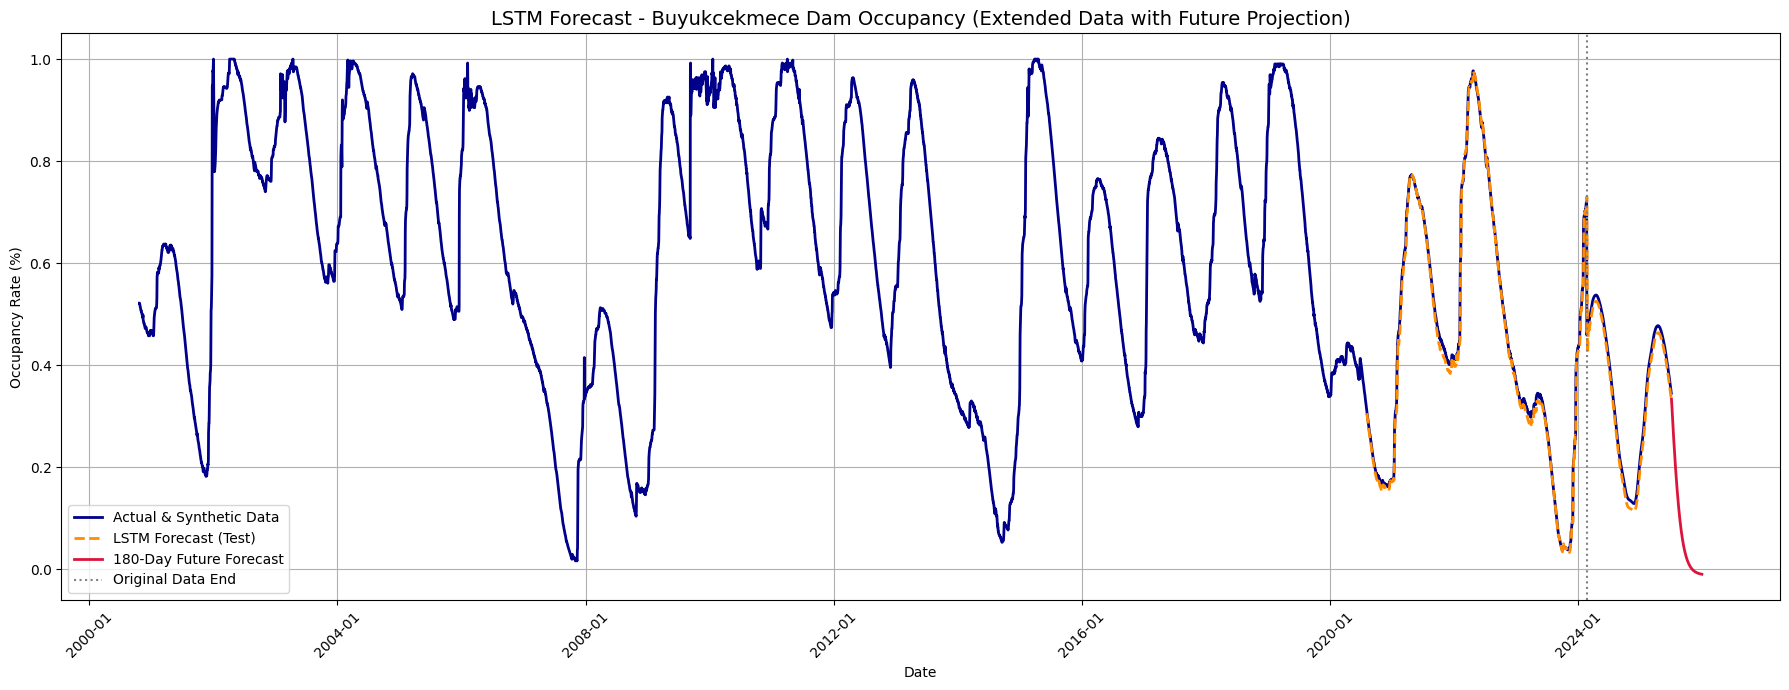

    > Saving trained model and scalers...
    > LSTM model saved: ../models\buyukcekmece\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\buyukcekmece\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\buyukcekmece\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\buyukcekmece\lstm_multivariate_occupancy_only_metrics.txt

  > Training Multivariate LSTM (Occupancy Only) for: Sazlidere
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0579 - val_loss: 0.0068
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 5/100
196/1

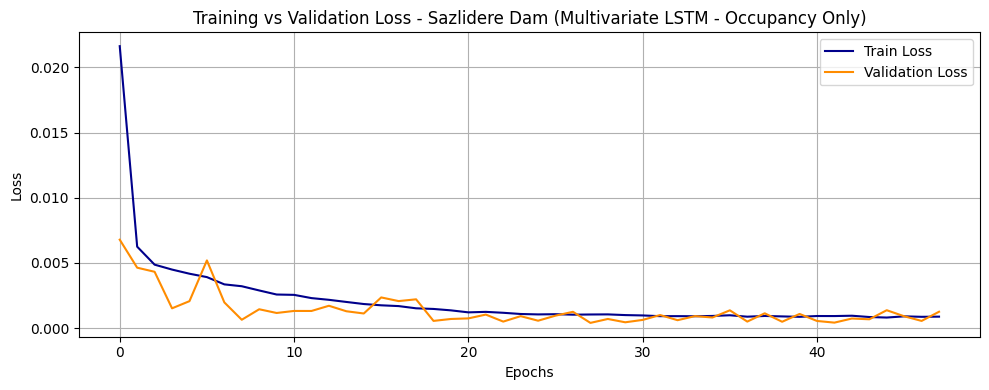

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0086
    > LSTM RMSE (Test Set): 0.0139
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_sazlidere_forecast_with_future.png


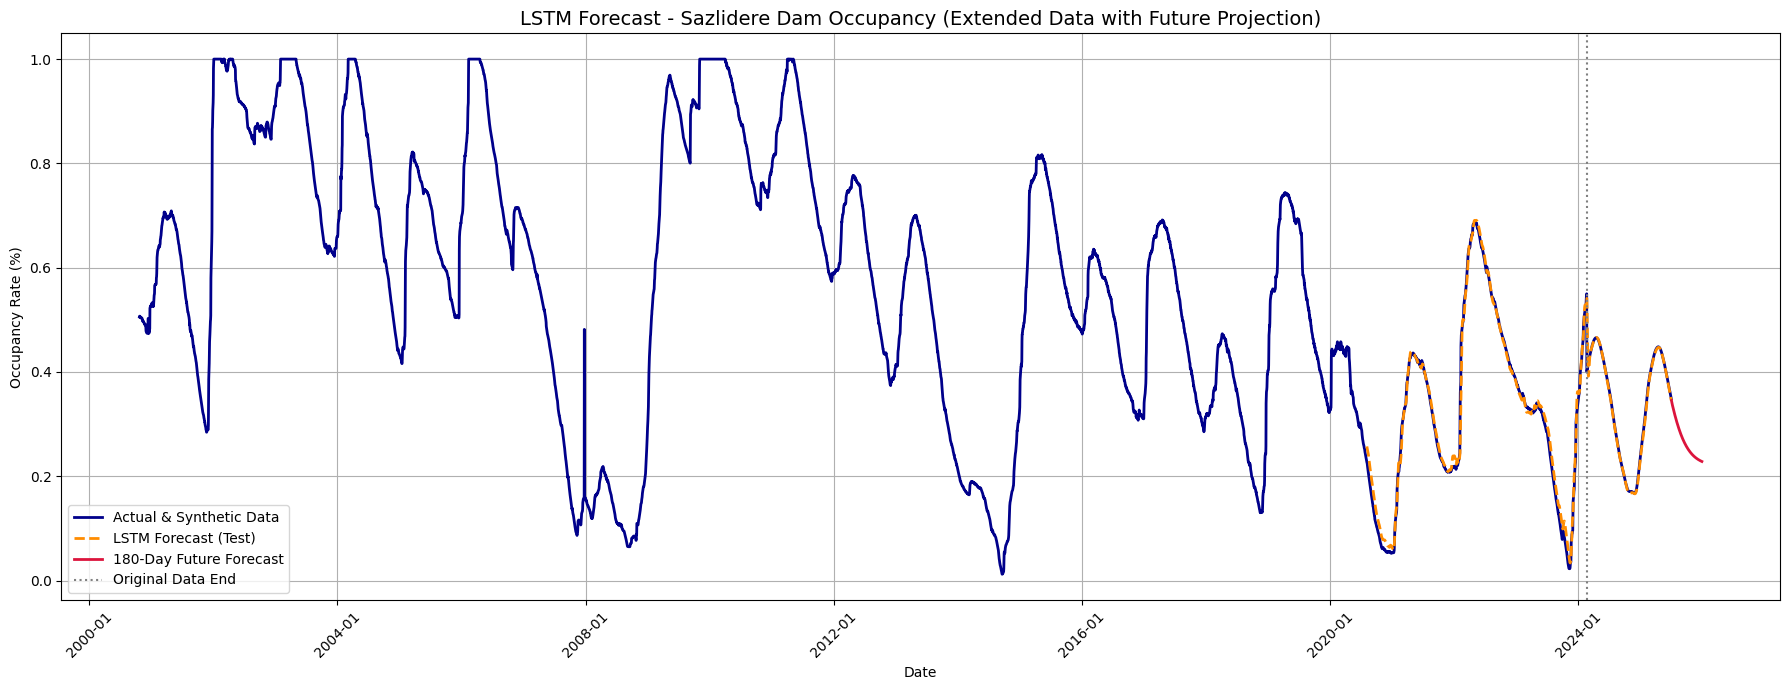

    > Saving trained model and scalers...
    > LSTM model saved: ../models\sazlidere\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\sazlidere\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\sazlidere\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\sazlidere\lstm_multivariate_occupancy_only_metrics.txt

  > Training Multivariate LSTM (Occupancy Only) for: Kazandere
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0652 - val_loss: 0.0013
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0096 - val_loss: 0.0033
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0083 - val_loss: 0.0012
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0071 - val_loss: 0.0013
Epoch 5/100
196/196 ━━━━━━━━━

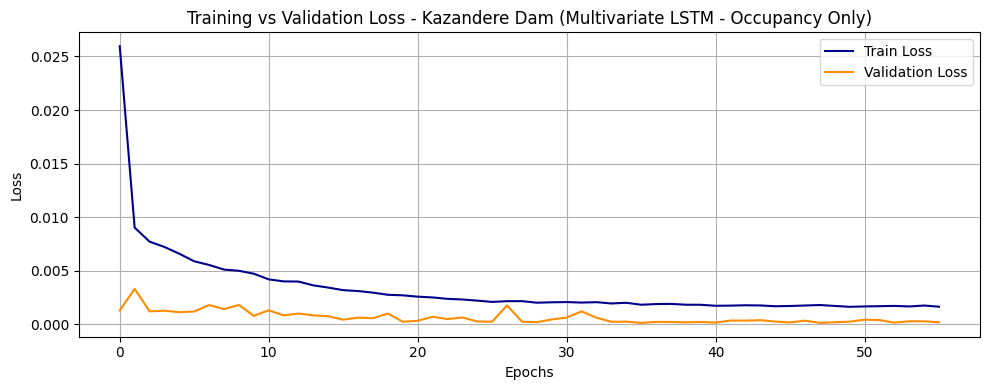

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    > LSTM MAE (Test Set): 0.0089
    > LSTM RMSE (Test Set): 0.0202
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_kazandere_forecast_with_future.png


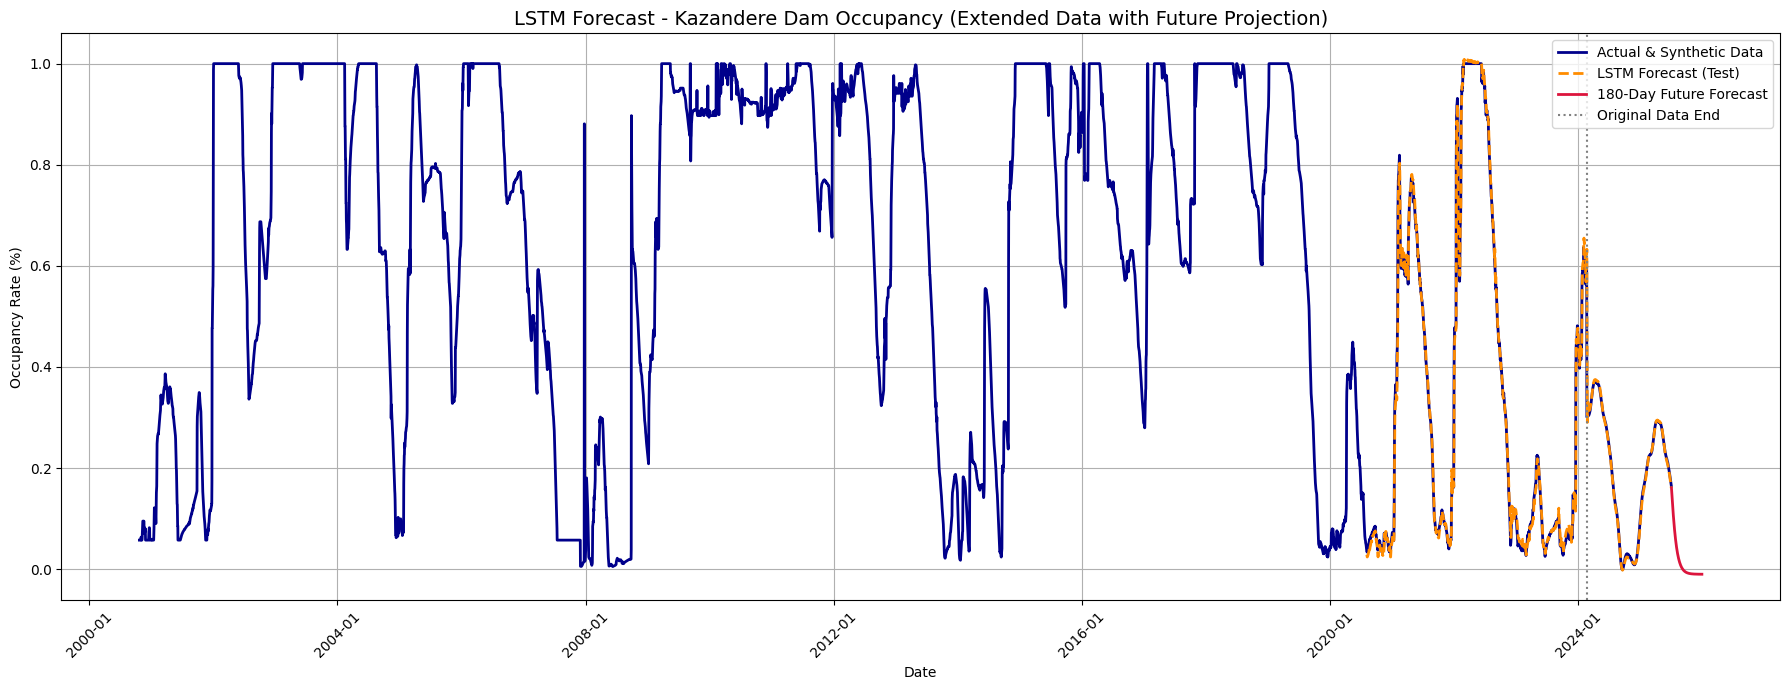

    > Saving trained model and scalers...
    > LSTM model saved: ../models\kazandere\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\kazandere\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\kazandere\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\kazandere\lstm_multivariate_occupancy_only_metrics.txt

  > Training Multivariate LSTM (Occupancy Only) for: Pabucdere
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0481 - val_loss: 0.0077
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0080 - val_loss: 0.0010
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0070 - val_loss: 7.9970e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0059 - val_loss: 5.9899e-04
Epoch 5/100
196/196 ━

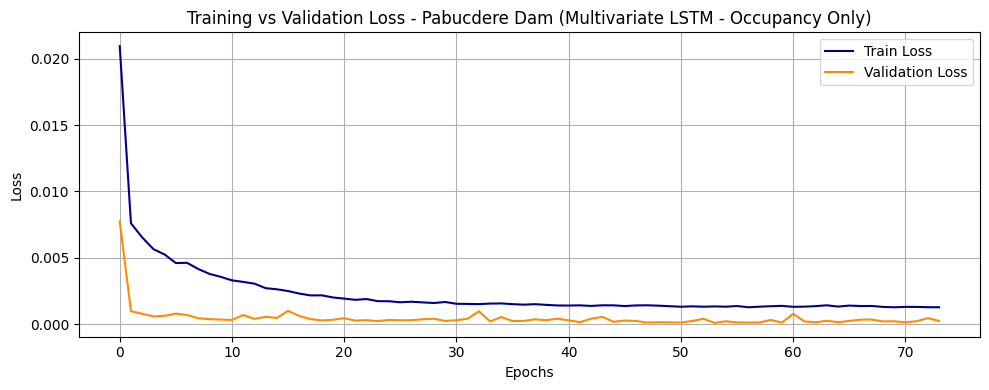

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
    > LSTM MAE (Test Set): 0.0076
    > LSTM RMSE (Test Set): 0.0157
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_pabucdere_forecast_with_future.png


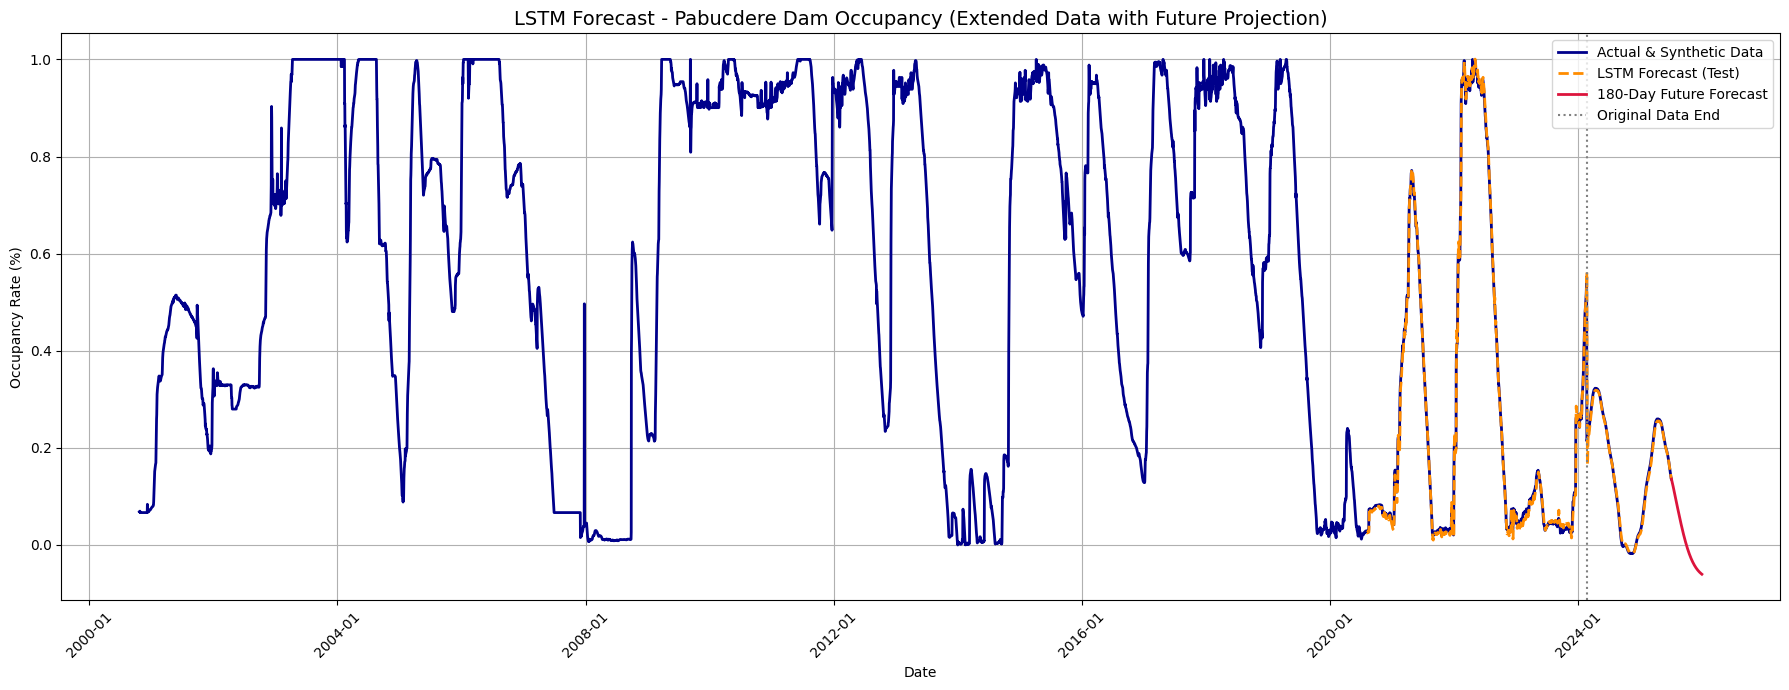

    > Saving trained model and scalers...
    > LSTM model saved: ../models\pabucdere\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\pabucdere\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\pabucdere\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\pabucdere\lstm_multivariate_occupancy_only_metrics.txt

  > Training Multivariate LSTM (Occupancy Only) for: Istrancalar
    > Sequences created with TIME_STEPS = 60.
    > Data split into Train (6270), Validation (895), Test (1793) sets.
    > LSTM model built.
    > Training the LSTM model...
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0480 - val_loss: 0.0078
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0150 - val_loss: 0.0059
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0122 - val_loss: 0.0043
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0106 - val_loss: 0.0035
Epoch 5/100
196/196 ━━━━━━━

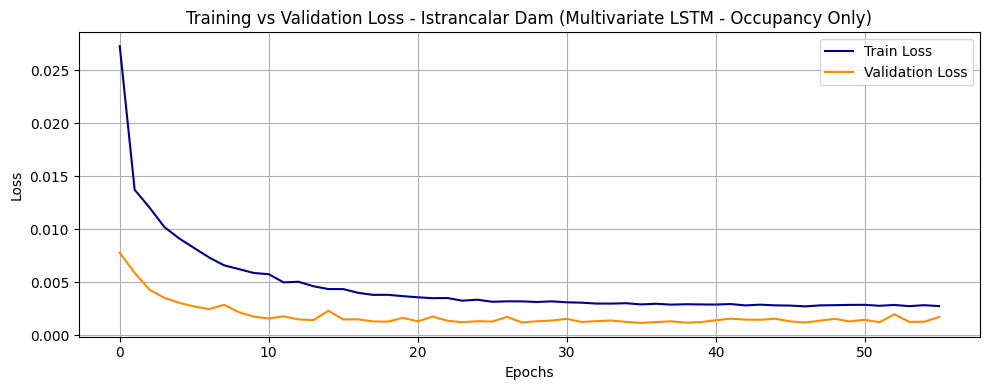

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
    > LSTM MAE (Test Set): 0.0239
    > LSTM RMSE (Test Set): 0.0400
    > Generating 180-day future forecast...
    > Future forecast generated up to: 2025-12-28 00:00:00
    > Plotting forecast with future projection...
    > Plot saved: ../results/plots/lstm_multivariate_occupancy_only_istrancalar_forecast_with_future.png


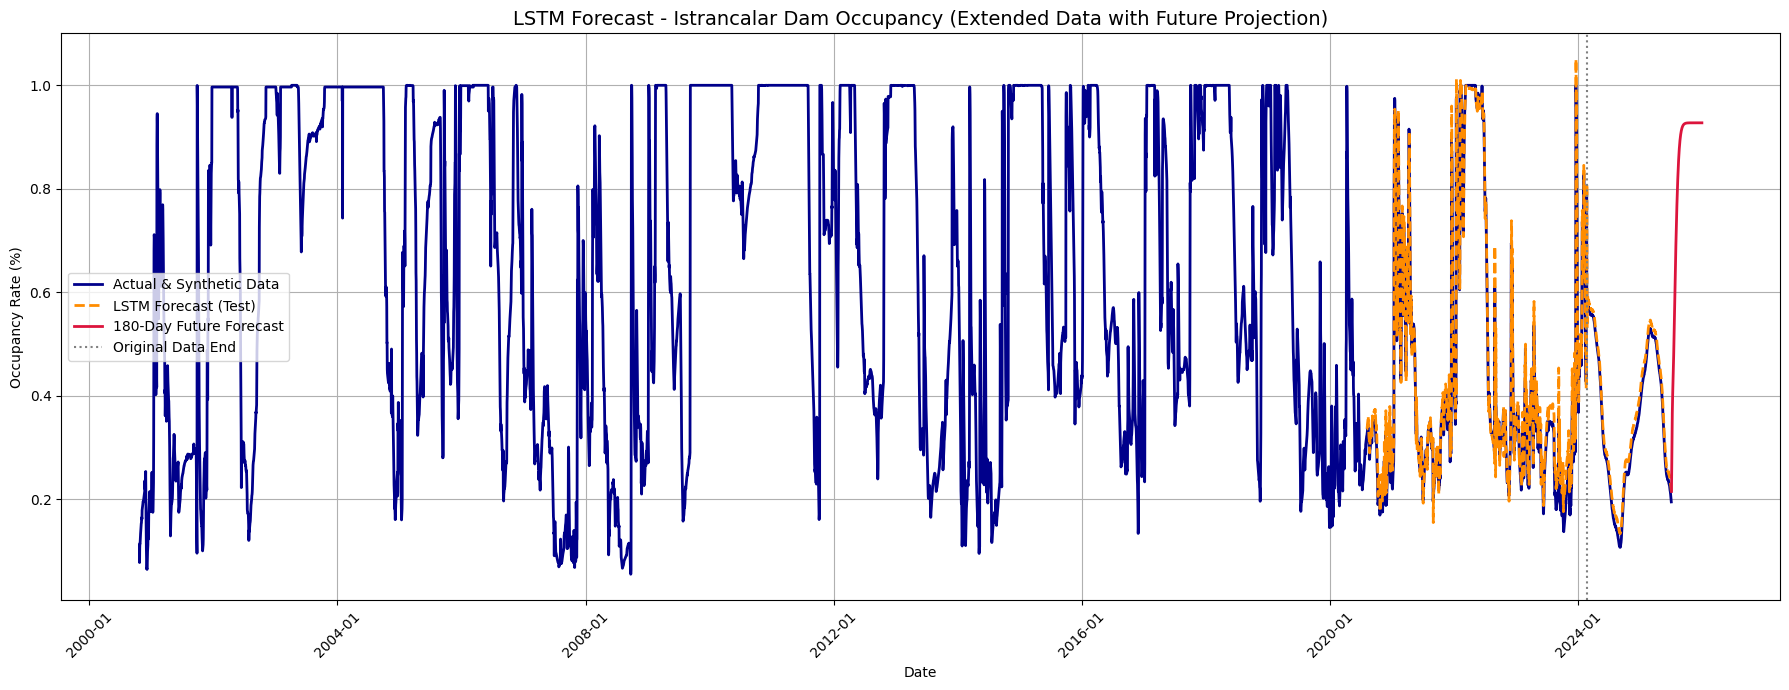

    > Saving trained model and scalers...
    > LSTM model saved: ../models\istrancalar\lstm_multivariate_occupancy_only_model.h5
    > Scaler_X saved: ../models\istrancalar\scaler_X_multivariate_occupancy_only.pkl
    > Scaler_y saved: ../models\istrancalar\scaler_y_multivariate_occupancy_only.pkl
    > Metrics saved: ../models\istrancalar\lstm_multivariate_occupancy_only_metrics.txt

Multivariate LSTM (Occupancy Only) model training and saving process completed for all dams.

--- Next Task Reminder ---
Please share the code for the next model you want to update (e.g., Single Dam Multivariate LSTM with extra inputs).


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Tarih formatlama için
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout # Dropout eklendi
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping eklendi
import os
import joblib

# --- 1. Dizinleri Oluşturma ---
# Her baraj için ayrı klasörler önceden oluşturulmuş olmalı (örn: ../models/omerli)
# Plotları kaydetmek için klasör
os.makedirs("../results/plots", exist_ok=True)

print("Processing Multivariate LSTM models (occupancy only) for each dam...")

# --- 2. Veri Yükleme ve Hazırlık ---
# DÜZELTME: Sentetik verilerle genişletilmiş dam occupancy dosyasını okuyoruz
file_path_occupancy_synthetic = "../data/processed/istanbul-dams-daily-occupancy-rates-cleaned_with_synthetic.csv"
df = pd.read_csv(file_path_occupancy_synthetic)
df['Tarih'] = pd.to_datetime(df['Tarih'])
print("  > Reading extended dam occupancy data.")

df.ffill(inplace=True)
df.bfill(inplace=True)

# Sadece baraj doluluk sütunları (Tarih hariç)
all_dam_occupancy_columns = df.columns.drop('Tarih').tolist()

# Scaling all features (all dam occupancy columns) for X
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[all_dam_occupancy_columns])
# scaler_X genel bir ölçekleyici olduğu için, her baraj klasörüne değil, genel bir yere kaydedilmeli
# Ancak model D ile çakışmaması için, bu modelin kendi içindeki scaler_X'i kaydedelim.


# Saving dates for plotting
dates_full_series = df['Tarih'].reset_index(drop=True)

# --- 3. Sekans Oluşturma Fonksiyonu ---
# X: Tüm barajların ölçeklenmiş dolulukları (çok değişkenli girdi)
# y: Hedef barajın ölçeklenmiş doluluğu (tek çıktı)
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps]) # y burada tek boyutlu olduğu için y[i+time_steps] direkt alınır
    return np.array(Xs), np.array(ys)

# Sabit TIME_STEPS
TIME_STEPS = 60

# --- 4. Her Baraj İçin Döngü ---
for target_dam_name in all_dam_occupancy_columns:
    print(f"\n  > Training Multivariate LSTM (Occupancy Only) for: {target_dam_name}")

    # Output (y) column for the current target dam
    y_target_dam = df[[target_dam_name]].values # 2D array
    scaler_y = MinMaxScaler()
    y_target_dam_scaled = scaler_y.fit_transform(y_target_dam)
    
    # Create sequences using all dam occupancies for X, and target dam for y
    X_seq, y_seq = create_sequences(X_scaled, y_target_dam_scaled, time_steps=TIME_STEPS)
    print(f"    > Sequences created with TIME_STEPS = {TIME_STEPS}.")

    # Train/val/test split
    train_size = int(len(X_seq) * 0.7)
    val_size = int(len(X_seq) * 0.1)
    
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
    X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

    # Test seti için tarihler
    dates_full_series_aligned = dates_full_series[TIME_STEPS:].reset_index(drop=True)
    dates_test = dates_full_series_aligned[train_size + val_size:].reset_index(drop=True)
    print(f"    > Data split into Train ({len(X_train)}), Validation ({len(X_val)}), Test ({len(X_test)}) sets.")


    # Building the model
    model = Sequential()
    # input_shape: (time_steps, number_of_features_in_X)
    # X_train.shape[2] --> tüm baraj doluluklarının sayısı
    model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2)) # Dropout eklendi
    model.add(LSTM(32, activation='tanh'))
    model.add(Dropout(0.2)) # Dropout eklendi
    model.add(Dense(1)) # Tek çıktı
    model.compile(optimizer='adam', loss='mse')
    print("    > LSTM model built.")

    # Training
    # DÜZELTME: EarlyStopping patience 10'dan 20'ye yükseltildi
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    print("    > Training the LSTM model...")
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        epochs=100, # Epoch sayısı artırıldı
                        batch_size=32, 
                        callbacks=[early_stopping],
                        verbose=1)
    print("    > LSTM model training completed.")

    # Kayıp grafiği (overfit kontrolü)
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss', color='darkblue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
    plt.title(f"Training vs Validation Loss - {target_dam_name} Dam (Multivariate LSTM - Occupancy Only)", fontsize=12)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plot_loss_path = f"../results/plots/lstm_multivariate_occupancy_only_{target_dam_name.lower()}_loss_curve.png"
    plt.savefig(plot_loss_path)
    print(f"    > Plot saved: {plot_loss_path}")
    plt.show()

    # Evaluation on test set
    y_pred_scaled = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)
    y_test_inv = scaler_y.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"    > LSTM MAE (Test Set): {mae:.4f}")
    print(f"    > LSTM RMSE (Test Set): {rmse:.4f}")

    # --- Gelecek Tahmini (Future Forecast) ---
    FORECAST_FUTURE_DAYS = 180 # Sonraki 6 ay
    print(f"    > Generating {FORECAST_FUTURE_DAYS}-day future forecast...")

    # Son bilinen sekansı al (X_test'in son elemanı)
    last_sequence = X_test[-1].reshape(1, TIME_STEPS, X_test.shape[2]) # (1, TIME_STEPS, num_features)
    future_preds_scaled = []

    for _ in range(FORECAST_FUTURE_DAYS):
        next_pred_scaled = model.predict(last_sequence, verbose=0)[0,0] # Tahmin edilen tek değer (ölçeklenmiş)
        future_preds_scaled.append(next_pred_scaled)
        
        # Sekansı güncelle: İlk elemanı at, yeni tahmini sona ekle
        # Bu modelde X_scaled tüm barajları içeriyor. Y_target_dam_scaled ise tek bir barajı.
        # Yeni sekansı oluştururken, o günün tüm barajlarının değerlerini içeren bir vektör oluşturmalıyız.
        # Bu durumda, hedef barajın değeri `next_pred_scaled` olacak.
        # Diğer barajların değerleri için ise, en basit yol, `last_sequence`'daki son zaman adımındaki değerlerini kopyalamaktır.
        
        # `last_sequence[0, -1, :]` --> son zaman adımındaki tüm barajların ölçeklenmiş değerleri (şekil: (num_features,))
        new_input_features_vector_scaled = last_sequence[0, -1, :].copy() 
        
        # Hedef barajın (current_dam_name) indeksini bul ve tahmin edilen değeri oraya koy
        # df[all_dam_occupancy_columns] ile X_scaled'i fit ettiğimizden, bu kolonların sırası aynıdır.
        target_dam_index_in_all_dams = all_dam_occupancy_columns.index(target_dam_name)
        new_input_features_vector_scaled[target_dam_index_in_all_dams] = next_pred_scaled
        
        # Sekansı güncelle
        last_sequence = np.append(last_sequence[:, 1:, :], new_input_features_vector_scaled.reshape(1, 1, -1), axis=1)

    future_preds_inv = scaler_y.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

    future_dates = pd.date_range(dates_test.iloc[-1] + pd.Timedelta(days=1), periods=FORECAST_FUTURE_DAYS)
    print(f"    > Future forecast generated up to: {future_dates.max()}")


    # --- Plotting forecast vs actual (Updated to include Future Forecast) ---
    print("    > Plotting forecast with future projection...")
    plt.figure(figsize=(18, 7))

    # Tüm df_occupancy_synthetic'teki geçmiş veriyi çiz (gerçek + sentetik)
    plt.plot(df['Tarih'], df[target_dam_name], color='darkblue', linewidth=2, label='Actual & Synthetic Data')

    # Test seti tahminlerini çiz (turuncu kesikli)
    plt.plot(dates_test, y_pred_inv, color='darkorange', linestyle='--', linewidth=2, label='LSTM Forecast (Test)')

    # Gelecek tahminini çiz (kırmızı düz çizgi)
    plt.plot(future_dates, future_preds_inv, color='crimson', linestyle='-', linewidth=2, label=f'{FORECAST_FUTURE_DAYS}-Day Future Forecast')

    # Orijinal verinin bittiği noktayı işaretle
    original_data_end_date = pd.to_datetime('2024-02-19')
    plt.axvline(original_data_end_date, color='gray', linestyle=':', linewidth=1.5, label='Original Data End')

    plt.title(f"LSTM Forecast - {target_dam_name} Dam Occupancy (Extended Data with Future Projection)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()

    plot_save_path = f"../results/plots/lstm_multivariate_occupancy_only_{target_dam_name.lower()}_forecast_with_future.png"
    plt.savefig(plot_save_path)
    print(f"    > Plot saved: {plot_save_path}")
    plt.show()

    # --- Saving the trained model and scalers ---
    print("    > Saving trained model and scalers...")
    # Yeni klasör yapısına uygun olarak kaydedilecek: ../models/barajadi/
    model_save_dir = os.path.join("../models", target_dam_name.lower())
    
    # Modeli kaydet
    model_save_path = os.path.join(model_save_dir, "lstm_multivariate_occupancy_only_model.h5")
    model.save(model_save_path)
    print(f"    > LSTM model saved: {model_save_path}")

    # Scaler_X (tüm barajlar için) ve scaler_y (hedef baraj için) kaydedilmesi
    # scaler_X her döngüde yeniden fit edildiği için, onu da her baraj için kaydetmeliyiz.
    scaler_X_save_path = os.path.join(model_save_dir, "scaler_X_multivariate_occupancy_only.pkl")
    scaler_y_save_path = os.path.join(model_save_dir, "scaler_y_multivariate_occupancy_only.pkl")
    joblib.dump(scaler_X, scaler_X_save_path)
    joblib.dump(scaler_y, scaler_y_save_path)
    print(f"    > Scaler_X saved: {scaler_X_save_path}")
    print(f"    > Scaler_y saved: {scaler_y_save_path}")

    # Metriklerin kaydedilmesi
    metrics_save_path = os.path.join(model_save_dir, "lstm_multivariate_occupancy_only_metrics.txt")
    with open(metrics_save_path, "w") as f:
        f.write(f"MAE: {mae:.4f}\n")
        f.write(f"RMSE: {rmse:.4f}\n")
    print(f"    > Metrics saved: {metrics_save_path}")

print("\nMultivariate LSTM (Occupancy Only) model training and saving process completed for all dams.")
print("\n--- Next Task Reminder ---")
print("Please share the code for the next model you want to update (e.g., Single Dam Multivariate LSTM with extra inputs).")